**This notebook contains followings:**
* Data Merging
* Feature Extraction
* Model Selection
* Hyperparameter Tuning
* Results on All Datasets
* References
* Conclusion
* Additional Resources


In [1]:
#importing necessary libraries
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn import preprocessing
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
import fitter
from distfit import distfit

# Merging Data

In [6]:
#Data paths
dataset_path_1st = r"C:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\data\kaggle\1st_test\1st_test"
dataset_path_2nd = r"C:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\data\kaggle\2nd_test\2nd_test"
dataset_path_3rd = r"C:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\data\kaggle\3rd_test\4th_test\txt"

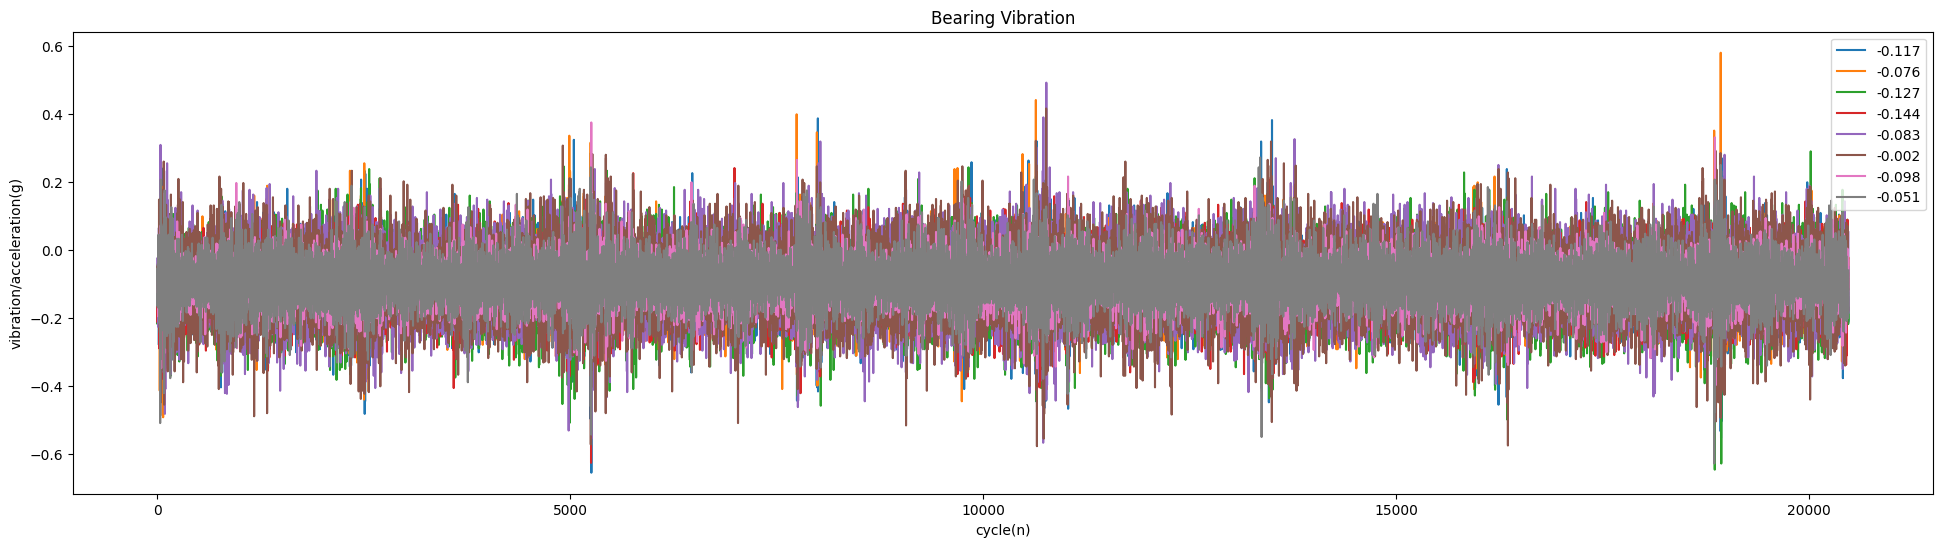

In [7]:
# Test for the first file

#Good condition bearing
dataset = pd.read_csv(r"C:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\data\kaggle\1st_test\1st_test\2003.10.22.12.09.13", sep='\t')

#Bad condition bearing
#dataset = pd.read_csv(r"C:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\data\kaggle\1st_test\1st_test\2003.11.25.23.39.56", sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

# Feature Extraction #

In this section several signal-based statistical features has been extracted from the data                                 
**Definition and formula of the features:**
* ***Absolute Mean*** $$\overline{x} = \frac{1}{N}\sum_{i=1}^{N}|x_i| $$

* ***Standart Deviation:*** $$\sigma         = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(x_i - \overline{x})^2}$$
* ***Skewness:*** 
Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
$$\mathrm{Sk} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^3}{\sigma^3}$$
* ***Kurtosis:***
Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.
$$\mathrm{K} = \frac{1}{N}\sum_{i=1}^{N}\frac{(x_i-\overline{x})^4}{\sigma^4}$$
* ***Entropy:***$$ H(X) = -\sum_{i=1}^{N} P(x_i)\log{P(x_i)} $$
                            
* ***RMS:*** $$x_{rms} =\sqrt{(\frac{1}{N})\sum_{i=1}^{N}(x)^{2}}$$

* ***Peak to Peak:*** $$ x_p = \max \mathrm{value} - \min \mathrm{value}$$

* ***Crest Factor:*** 
Peak value divided by the RMS. Faults often first manifest themselves in changes in the peakiness of a signal before they manifest in the energy represented by the signal root mean squared. The crest factor can provide an early warning for faults when they first develop. 
$$x_{crest} =\frac{\max \mathrm{value}}{\mathrm{x_{rms}}}$$

* ***Clearence Factor:*** 
Peak value divided by the squared mean value of the square roots of the absolute amplitudes. For rotating machinery, this feature is maximum for healthy bearings and goes on decreasing for defective ball, defective outer race, and defective inner race respectively. The clearance factor has the highest separation ability for defective inner race faults.
$$ x_{clear} = \frac{x_p}{(\frac{1}{N}\sum_{i=1}^{N}\sqrt{|x_i|})^2}  $$

* ***Shape Factor:*** 
RMS divided by the mean of the absolute value. Shape factor is dependent on the signal shape while being independent of the signal dimensions.
$$\frac{x_{rms}}{\overline{x}}$$

* ***Impulse:*** 
Compare the height of a peak to the mean level of the signal.
$$\frac{\max \mathrm{value}}{\overline{x}}  $$


In [8]:
# Root Mean Squared Sum
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)
# extract clearence factor
def calculate_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def time_features(dataset_path, id_set=None):
    features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse', 
                "freq_band_0" , "freq_band_1" , "freq_band_2" , "freq_band_3" , "freq_band_4" , "freq_band_5" , "freq_band_6",
                "freq_band_7", "freq_band_8" , "freq_band_9" , "freq_band_10" , "freq_band_11" , "freq_band_12"]
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']

    #From the specs of Kaggle NASA dataset
    Fsamp = 20000
    Ts = 1/Fsamp
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in features]
        data = pd.DataFrame(columns=columns)
        
        
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(calculate_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs

        h_signal = np.abs(hilbert(raw_data))
        N = len(h_signal)
        fft = np.abs(np.fft.fft(h_signal) /len (h_signal))
        fft= 2 * fft [0:int(N/2+1)]
        fft[0]= fft[0] / 2
        # Excluding continuous expression
        start_index = 1
        freq_interested = [17, 36, 234, 276, 295, 350, 550, 750, 950, 1150, 1350, len(fft)]
        fft_n = [None] * 12
        i = 0
        for index in freq_interested:
            temp_mean = fft [start_index : index]
            fft_n [i]= np.mean(temp_mean, axis= 0) 
            start_index = index
            i += 1

        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_freq_band_0' for c in cols1])
            fft_1 = pd.DataFrame(fft_n [0].reshape(1,8), columns=[c+'_freq_band_1' for c in cols1])
            fft_2 = pd.DataFrame(fft_n [1].reshape(1,8), columns=[c+'_freq_band_2' for c in cols1])
            fft_3 = pd.DataFrame(fft_n [2].reshape(1,8), columns=[c+'_freq_band_3' for c in cols1])
            fft_4 = pd.DataFrame(fft_n [3].reshape(1,8), columns=[c+'_freq_band_4' for c in cols1])
            fft_5 = pd.DataFrame(fft_n [4].reshape(1,8), columns=[c+'_freq_band_5' for c in cols1])
            fft_6 = pd.DataFrame(fft_n [5].reshape(1,8), columns=[c+'_freq_band_6' for c in cols1])
            fft_7 = pd.DataFrame(fft_n [6].reshape(1,8), columns=[c+'_freq_band_7' for c in cols1])
            fft_8 = pd.DataFrame(fft_n [7].reshape(1,8), columns=[c+'_freq_band_8' for c in cols1])
            fft_9 = pd.DataFrame(fft_n [8].reshape(1,8), columns=[c+'_freq_band_9' for c in cols1])
            fft_10 = pd.DataFrame(fft_n [9].reshape(1,8), columns=[c+'_freq_band_10' for c in cols1])
            fft_11 = pd.DataFrame(fft_n [10].reshape(1,8), columns=[c+'_freq_band_11' for c in cols1])
            fft_12 = pd.DataFrame(fft_n [11].reshape(1,8), columns=[c+'_freq_band_12' for c in cols1])
            
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_freq_band_0' for c in cols2])
            fft_1 = pd.DataFrame(fft_n [0].reshape(1,4), columns=[c+'_freq_band_1' for c in cols2])
            fft_2 = pd.DataFrame(fft_n [1].reshape(1,4), columns=[c+'_freq_band_2' for c in cols2])
            fft_3 = pd.DataFrame(fft_n [2].reshape(1,4), columns=[c+'_freq_band_3' for c in cols2])
            fft_4 = pd.DataFrame(fft_n [3].reshape(1,4), columns=[c+'_freq_band_4' for c in cols2])
            fft_5 = pd.DataFrame(fft_n [4].reshape(1,4), columns=[c+'_freq_band_5' for c in cols2])
            fft_6 = pd.DataFrame(fft_n [5].reshape(1,4), columns=[c+'_freq_band_6' for c in cols2])
            fft_7 = pd.DataFrame(fft_n [6].reshape(1,4), columns=[c+'_freq_band_7' for c in cols2])
            fft_8 = pd.DataFrame(fft_n [7].reshape(1,4), columns=[c+'_freq_band_8' for c in cols2])
            fft_9 = pd.DataFrame(fft_n [8].reshape(1,4), columns=[c+'_freq_band_9' for c in cols2])
            fft_10 = pd.DataFrame(fft_n [9].reshape(1,4), columns=[c+'_freq_band_10' for c in cols2])
            fft_11 = pd.DataFrame(fft_n [10].reshape(1,4), columns=[c+'_freq_band_11' for c in cols2])
            fft_12 = pd.DataFrame(fft_n [11].reshape(1,4), columns=[c+'_freq_band_12' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename]
        fft_1.index = [filename]
        fft_2.index = [filename]
        fft_3.index = [filename] 
        fft_4.index = [filename]
        fft_5.index = [filename]    
        fft_6.index = [filename] 
        fft_7.index = [filename] 
        fft_8.index = [filename] 
        fft_9.index = [filename] 
        fft_10.index = [filename] 
        fft_11.index = [filename] 
        fft_12.index = [filename] 
        
        # concat
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse, 
                           fft_1, fft_2, fft_3, fft_4, fft_5, fft_6, fft_7, fft_8, fft_9 ,fft_10, fft_11, fft_12], axis=1)
        data = pd.concat([data,merge])
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data                                  

1.  Calling feature extraction function defined above to merge extracted features      
2.  Saving as .csv file

In [6]:
set1 = time_features(dataset_path_1st, id_set=1)
set1.to_csv('set1_timefeatures.csv')

In [7]:
set2 = time_features(dataset_path_2nd, id_set=2)
set2.to_csv('set2_timefeatures.csv')

Reading Data again

In [9]:
set1 = pd.read_csv("./set1_timefeatures.csv")
set2= pd.read_csv("./set2_timefeatures.csv")

Changing indexing column to time which is also name of the each file

In [10]:
pd.set_option('display.max_columns', None)
set1 = set1.rename(columns={'Unnamed: 0':'time'})
# set1.set_index('time')
set1.describe()

B1_x_mean     B1_x_std    B1_x_skew  B1_x_kurtosis  B1_x_entropy  \
count  2156.000000  2156.000000  2156.000000    2156.000000   2156.000000   
mean      0.127485     0.098575    -0.038621       0.998634      4.981065   
std       0.006072     0.005345     0.030224       0.197405      0.074409   
min       0.103651     0.079417    -0.137060       0.279887      4.507776   
25%       0.127830     0.096967    -0.058600       0.868275      4.936962   
50%       0.128906     0.099051    -0.038491       0.996362      4.983200   
75%       0.129829     0.101153    -0.017578       1.124417      5.027213   
max       0.142147     0.129748     0.071573       1.700413      5.304080   

          B1_x_rms     B1_x_max     B1_x_p2p   B1_x_crest  B1_x_clearence  \
count  2156.000000  2156.000000  2156.000000  2156.000000     2156.000000   
mean      0.152221     0.726346     1.177997     4.774991        0.111784   
std       0.007184     0.079033     0.107634     0.500902        0.005428   
min       0.123812     0.510000     0.822000     3.667188        0.090784   
25%       0.152206     0.669000     1.104000     4.407653        0.112297   
50%       0.153733     0.720000     1.175500     4.712466        0.113093   
75%       0.155259     0.776000     1.250000     5.063995        0.113818   
max       0.174977     1.042000     1.533000     7.123639        0.122149   

        B1_x_shape  B1_x_impulse  B1_x_freq_band_0  B1_x_freq_band_1  \
count  2156.000000           0.0       2156.000000       2156.000000   
mean      1.194091           NaN          5.702422          0.000122   
std       0.006763           NaN          0.605757          0.000015   
min       1.177202           NaN          4.364625          0.000085   
25%       1.190236           NaN          5.256642          0.000113   
50%       1.193651           NaN          5.628548          0.000120   
75%       1.197083           NaN          6.045752          0.000129   
max       1.230958           NaN          8.657607          0.000249   

       B1_x_freq_band_2  B1_x_freq_band_3  B1_x_freq_band_4  B1_x_freq_band_5  \
count       2156.000000       2156.000000       2156.000000       2156.000000   
mean           0.000122          0.000122          0.000122          0.000122   
std            0.000016          0.000013          0.000014          0.000016   
min            0.000085          0.000090          0.000086          0.000083   
25%            0.000113          0.000116          0.000114          0.000113   
50%            0.000120          0.000120          0.000119          0.000119   
75%            0.000129          0.000128          0.000128          0.000128   
max            0.000261          0.000242          0.000263          0.000282   

       B1_x_freq_band_6  B1_x_freq_band_7  B1_x_freq_band_8  B1_x_freq_band_9  \
count       2156.000000       2156.000000       2156.000000       2156.000000   
mean           0.000122          0.000122          0.000122          0.000122   
std            0.000015          0.000013          0.000013          0.000013   
min            0.000089          0.000087          0.000090          0.000088   
25%            0.000114          0.000115          0.000115          0.000115   
50%            0.000119          0.000119          0.000120          0.000119   
75%            0.000128          0.000127          0.000127          0.000127   
max            0.000233          0.000272          0.000271          0.000264   

       B1_x_freq_band_10  B1_x_freq_band_11  B1_x_freq_band_12    B1_y_mean  \
count        2156.000000        2156.000000        2156.000000  2156.000000   
mean            0.000122           0.000121           0.000121     0.124183   
std             0.000012           0.000012           0.000010     0.006244   
min             0.000091           0.000091           0.000096     0.099854   
25%             0.000115           0.000115           0.000118     0.124814   
50%             0.000120           0.0

In [7]:
set2 = set2.rename(columns={'Unnamed: 0':'time'})
set2.set_index('time')
set2.describe()

B1_mean      B1_std     B1_skew  B1_kurtosis  B1_entropy  \
count  984.000000  984.000000  984.000000   984.000000  984.000000   
mean     0.080905    0.106090   -0.033128     0.827643    4.985907   
std      0.040171    0.058234    0.089037     0.966001    0.260572   
min      0.001168    0.000987   -0.766212    -1.609923    0.592386   
25%      0.060765    0.077112   -0.047476     0.393975    4.860787   
50%      0.062007    0.078748   -0.009827     0.485346    4.880541   
75%      0.083223    0.108790    0.013673     0.879248    5.135371   
max      0.453335    0.725031    0.579749    14.113736    5.676568   

           B1_rms      B1_max      B1_p2p    B1_crest  B1_clearence  ...  \
count  984.000000  984.000000  984.000000  984.000000    984.000000  ...   
mean     0.106111    0.555001    1.054736    5.173858      0.066902  ...   
std      0.058225    0.388084    0.740102    0.576191      0.032068  ...   
min      0.001533    0.005000    0.005000    2.377538      0.000681  ...   
25%      0.077136    0.393000    0.752000    4.816641      0.051044  ...   
50%      0.078779    0.442000    0.830000    5.097674      0.052136  ...   
75%      0.108819    0.576000    1.101750    5.440268      0.068917  ...   
max      0.725019    5.000000    9.998000    9.333170      0.352339  ...   

       B4_freq_band_3  B4_freq_band_4  B4_freq_band_5  B4_freq_band_6  \
count    9.840000e+02    9.840000e+02    9.840000e+02    9.840000e+02   
mean     8.380531e-06    8.405894e-06    8.305228e-06    8.404769e-06   
std      2.618633e-06    3.376931e-06    3.013373e-06    2.921076e-06   
min      3.451898e-08    5.287721e-08    8.224086e-08    5.858286e-08   
25%      7.127425e-06    6.770918e-06    6.656113e-06    6.951211e-06   
50%      7.643875e-06    7.686634e-06    7.667602e-06    7.754923e-06   
75%      8.639181e-06    8.960732e-06    9.005670e-06    8.872953e-06   
max      3.156320e-05    5.689841e-05    3.272858e-05    4.256772e-05   

       B4_freq_band_7  B4_freq_band_8  B4_freq_band_9  B4_freq_band_10  \
count    9.840000e+02    9.840000e+02    9.840000e+02     9.840000e+02   
mean     8.405399e-06    8.394329e-06    8.392086e-06     8.387545e-06   
std      2.633161e-06    2.659662e-06    2.753538e-06     2.639038e-06   
min      6.089621e-08    5.394448e-08    3.966439e-08     6.407208e-08   
25%      7.190335e-06    7.171952e-06    7.168163e-06     7.154802e-06   
50%      7.725422e-06    7.656781e-06    7.727104e-06     7.724588e-06   
75%      8.661154e-06    8.713445e-06    8.584674e-06     8.584737e-06   
max      3.455598e-05    3.372797e-05    4.131047e-05     3.488672e-05   

       B4_freq_band_11  B4_freq_band_12  
count     9.840000e+02     9.840000e+02  
mean      8.412142e-06     8.400035e-06  
std       2.647395e-06     2.599624e-06  
min       4.540103e-08     7.059477e-08  
25%       7.204390e-06     7.347424e-06  
50%       7.754898e-06     7.512395e-06  
75%       8.637653e-06     8.152654e-06  
max       3.491900e-05     3.545954e-05  

[8 rows x 100 columns]

In [37]:
print (set1.tail(240))

                     time  B1_x_mean  B1_x_std  B1_x_skew  B1_x_kurtosis  \
1916  2003-11-23 09:06:56   0.129977  0.099230  -0.020451       0.823109   
1917  2003-11-23 09:16:56   0.130296  0.100184  -0.003251       0.937201   
1918  2003-11-23 09:26:56   0.129574  0.099300  -0.009549       0.884685   
1919  2003-11-23 09:36:56   0.129561  0.101096  -0.053151       1.045774   
1920  2003-11-23 09:46:56   0.130603  0.103958  -0.085492       1.211033   
...                   ...        ...       ...        ...            ...   
2151  2003-11-25 16:07:32   0.138784  0.120934   0.000689       0.477060   
2152  2003-11-25 23:13:21   0.142147  0.129748  -0.052217       0.555174   
2153  2003-11-25 23:19:56   0.142098  0.128376  -0.080830       0.383461   
2154  2003-11-25 23:29:56   0.141889  0.126898  -0.009047       0.515840   
2155  2003-11-25 23:39:56   0.142014  0.128898  -0.040078       0.557871   

      B1_x_entropy  B1_x_rms  B1_x_max  B1_x_p2p  B1_x_crest  ...  B4_y_skew  \
1916   

Plotting features of all bearings in both x and y axis

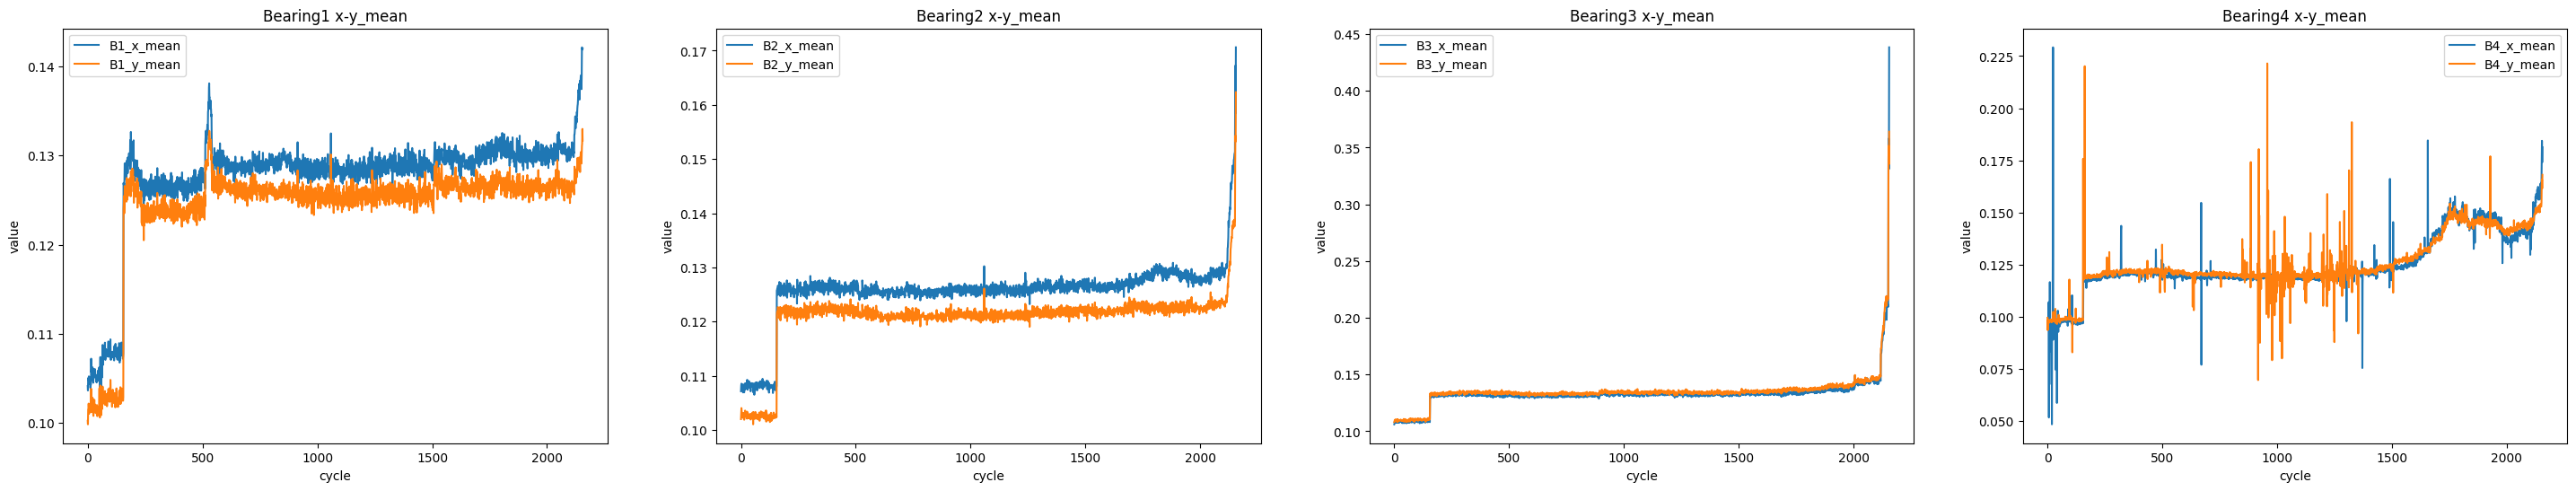

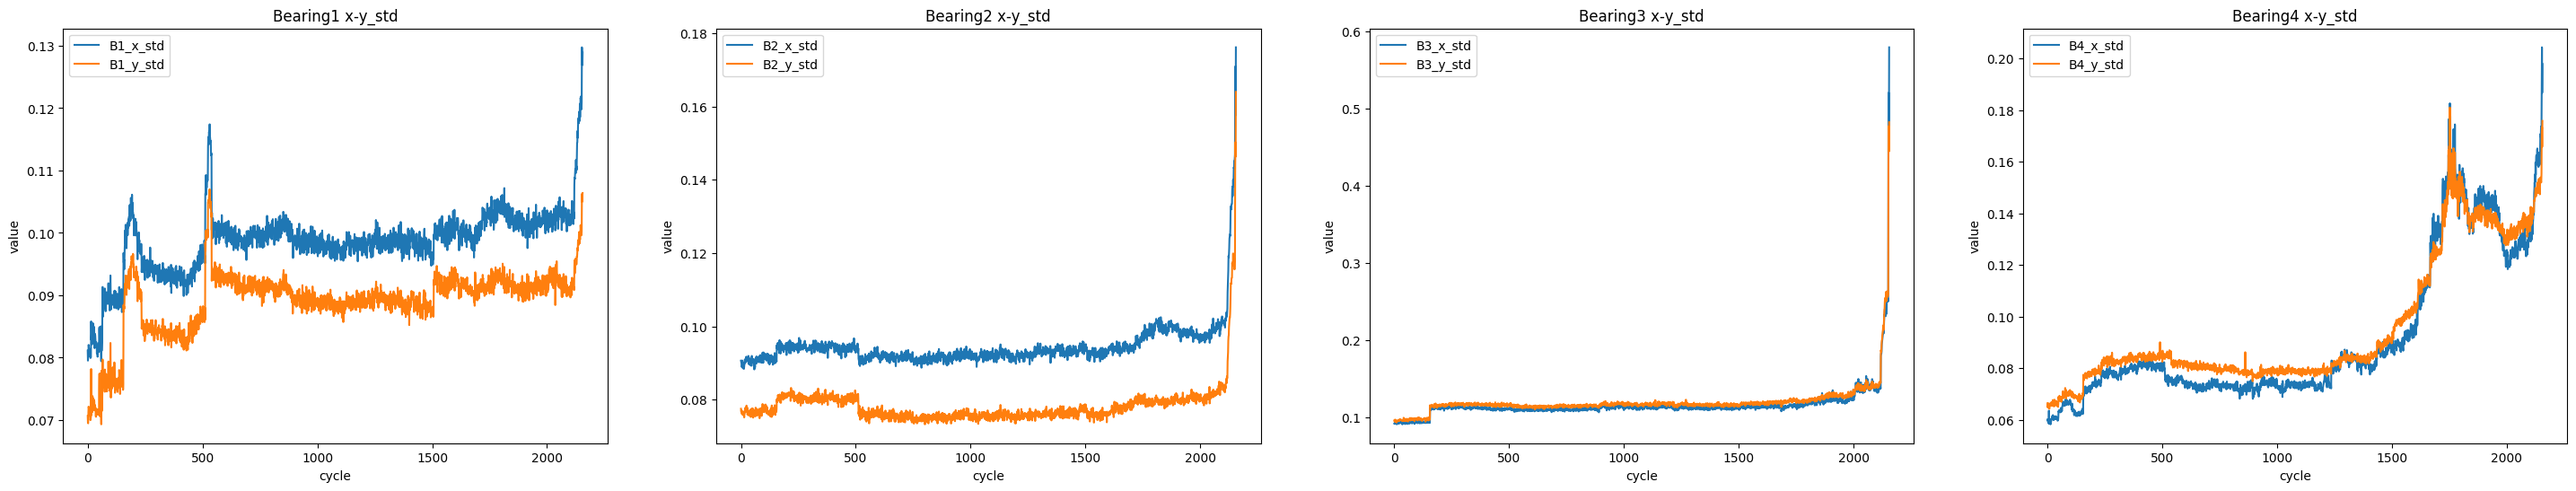

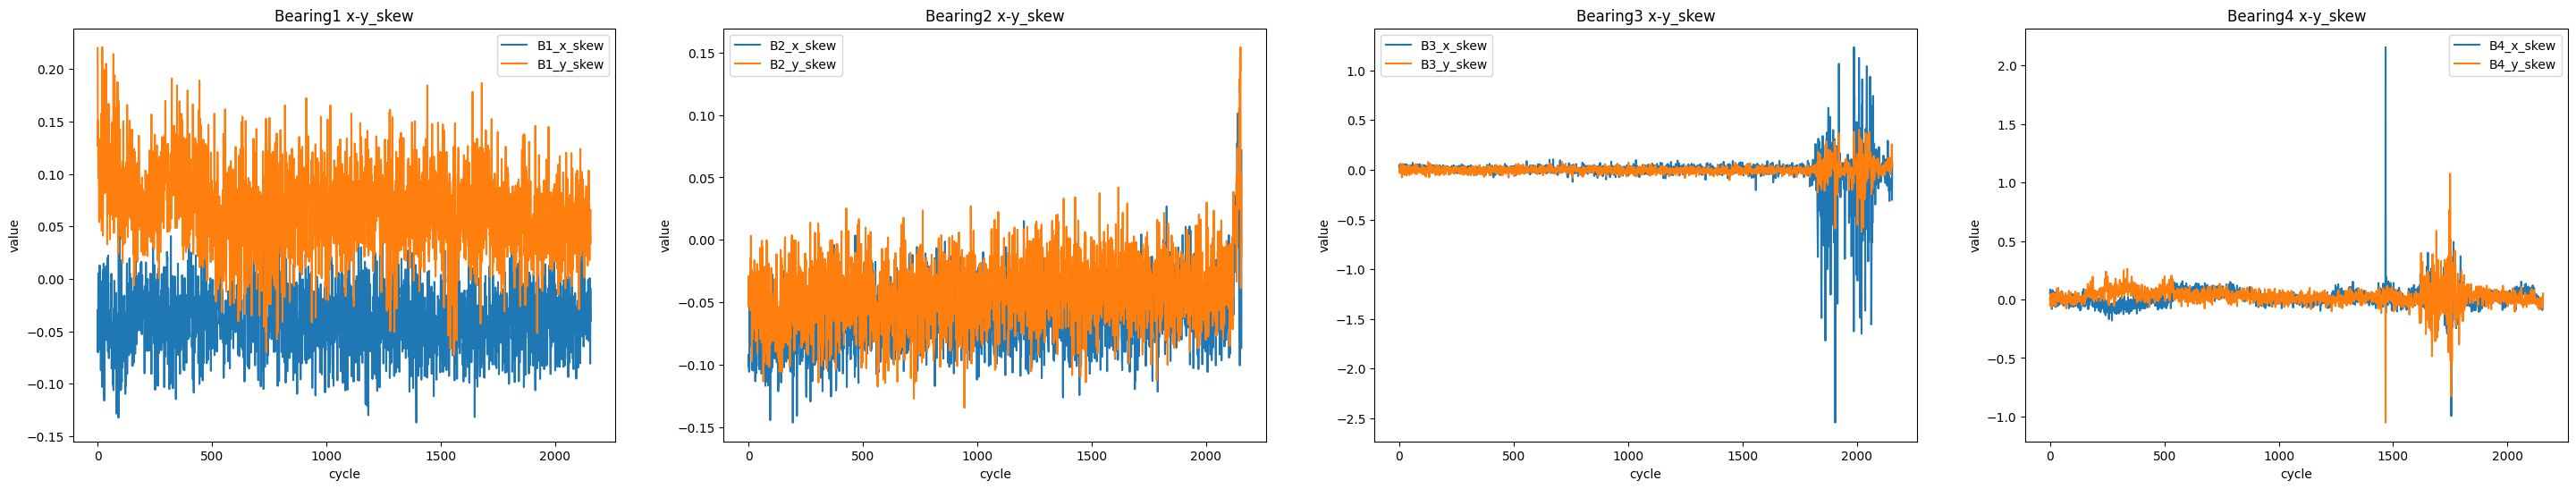

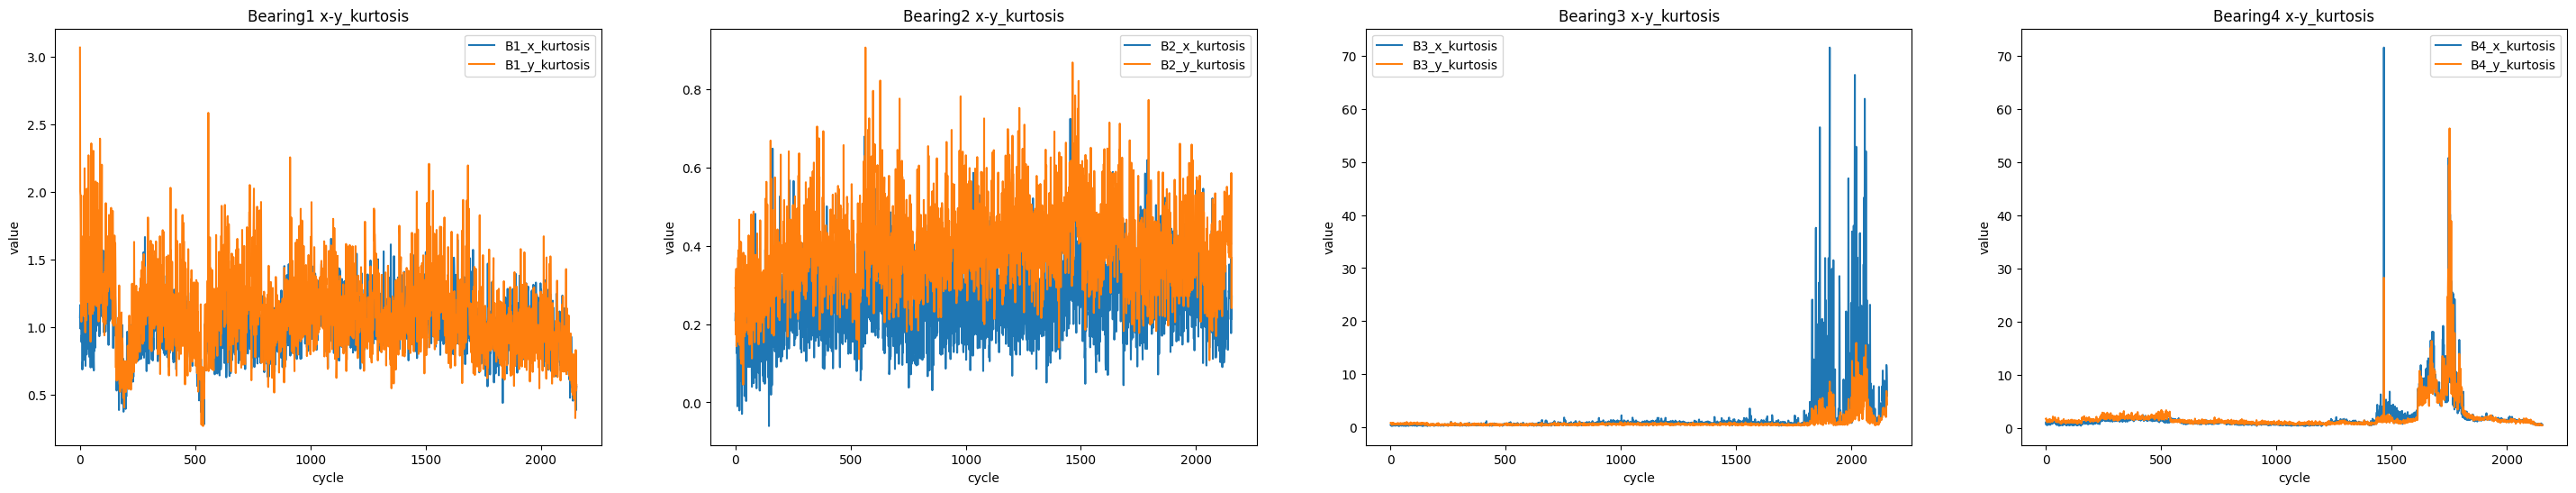

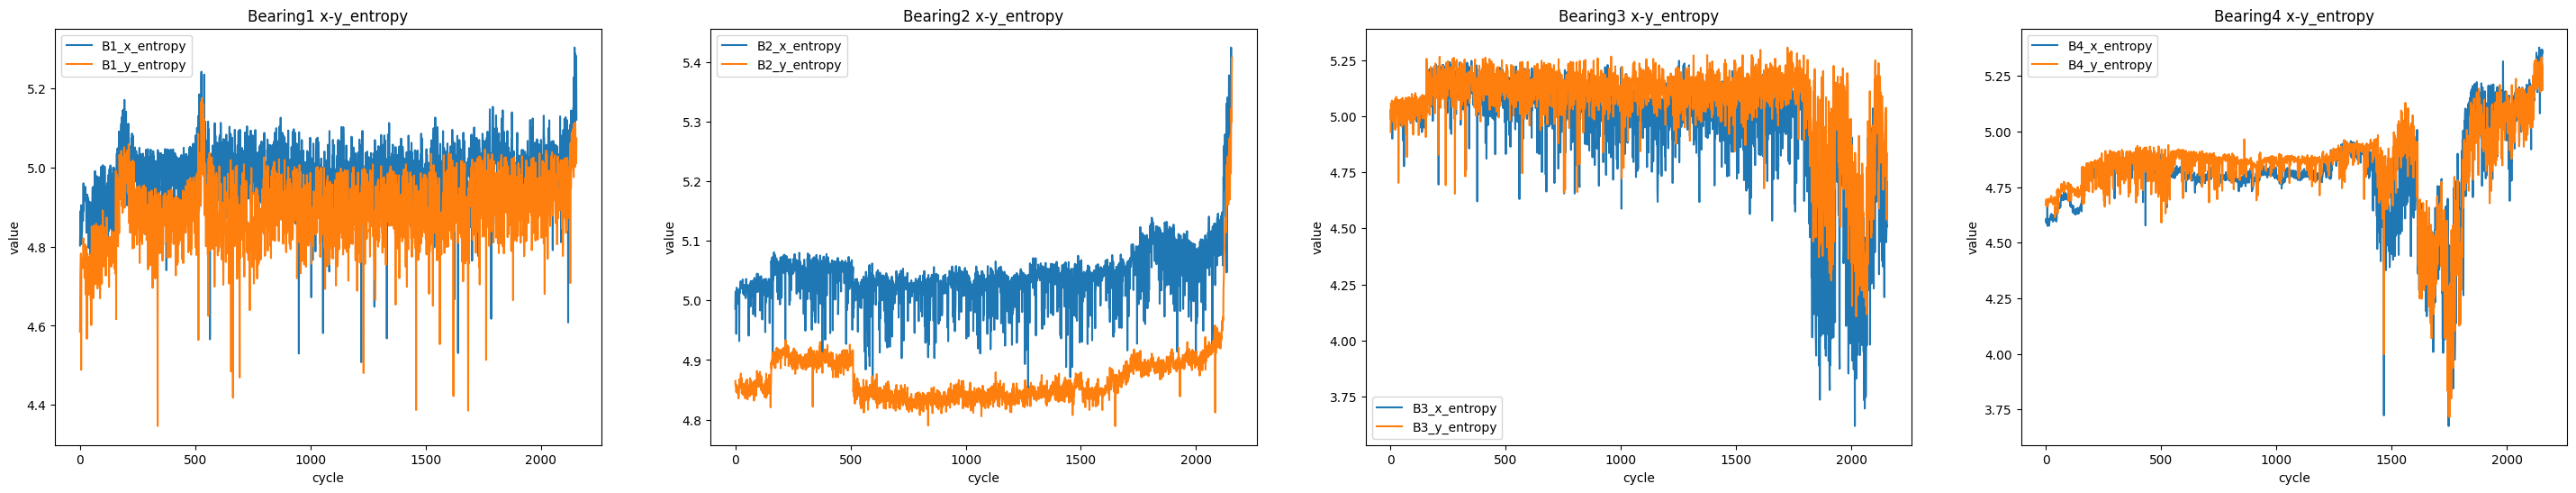

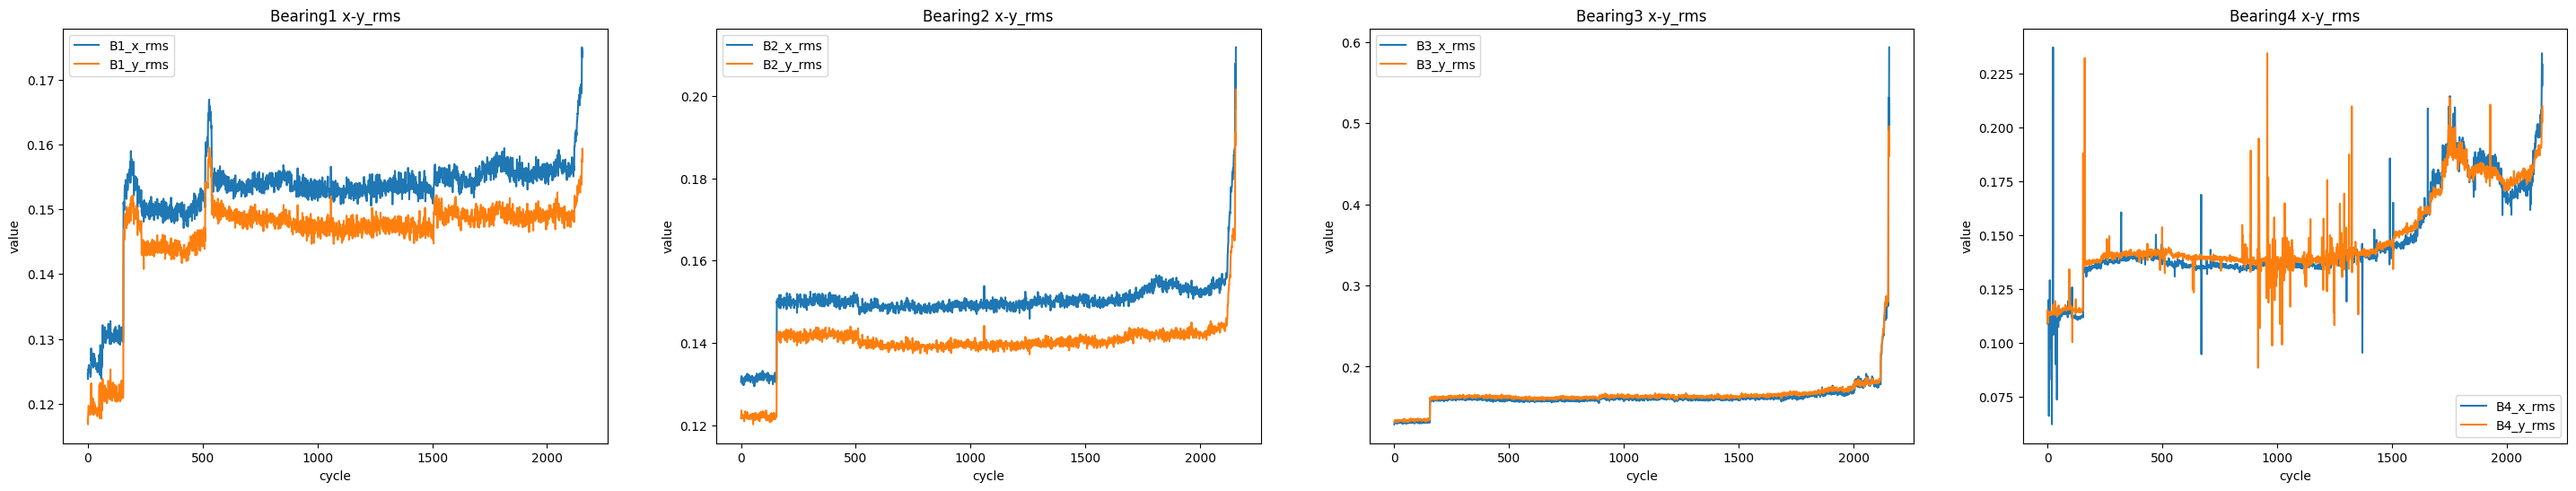

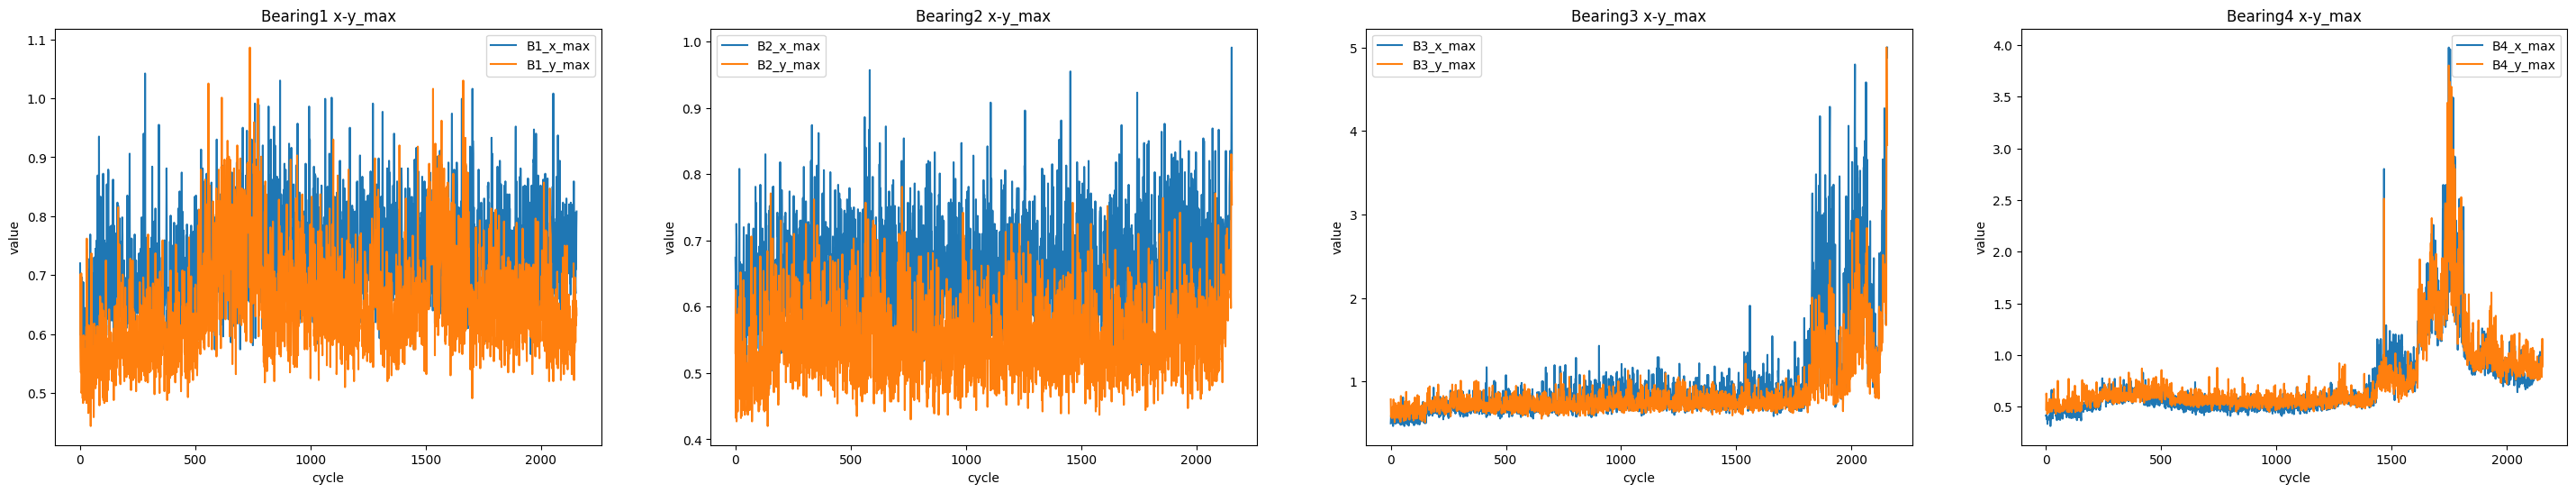

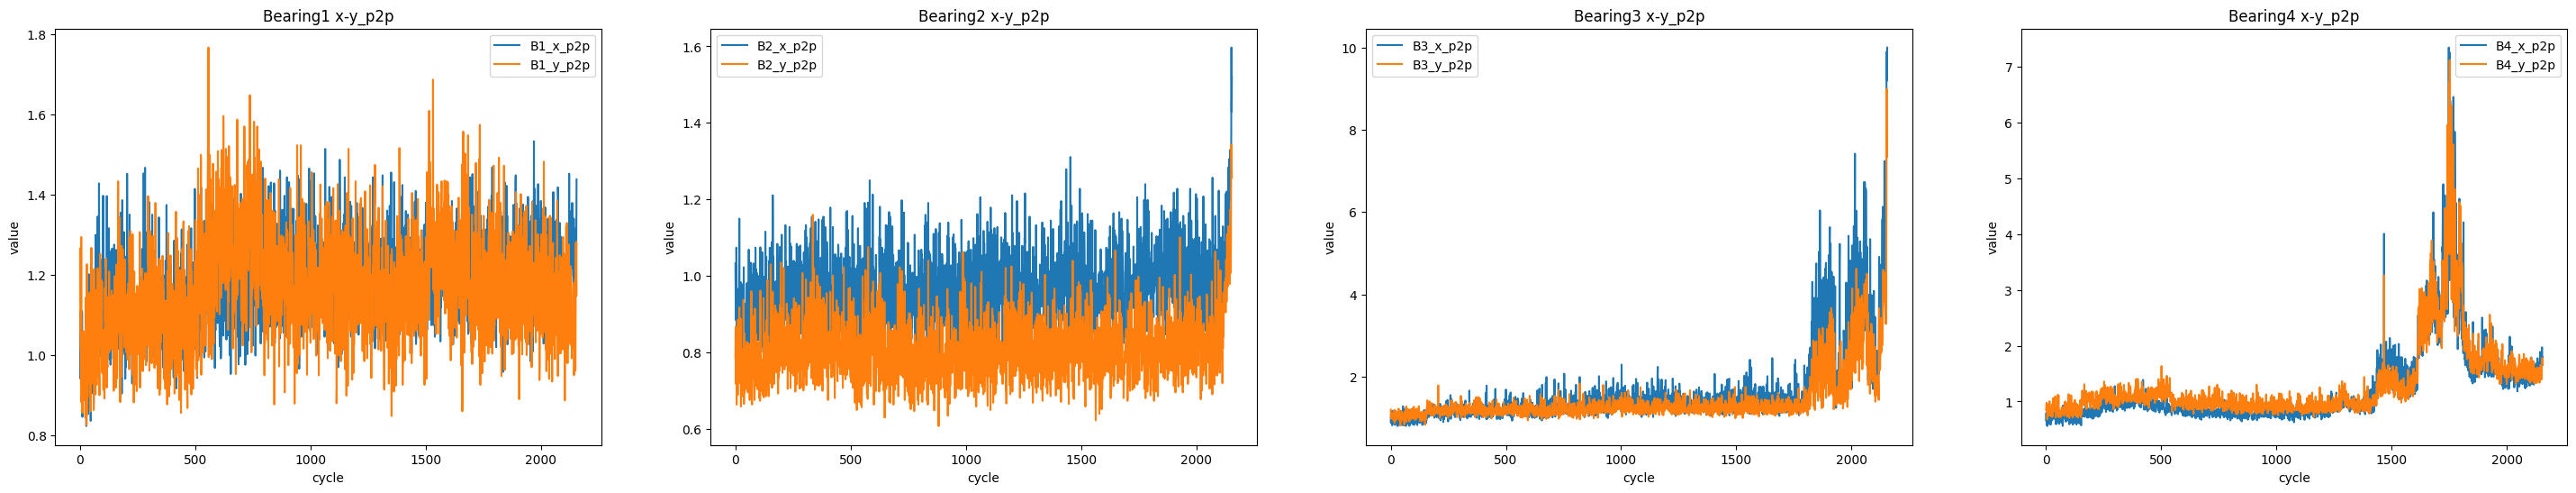

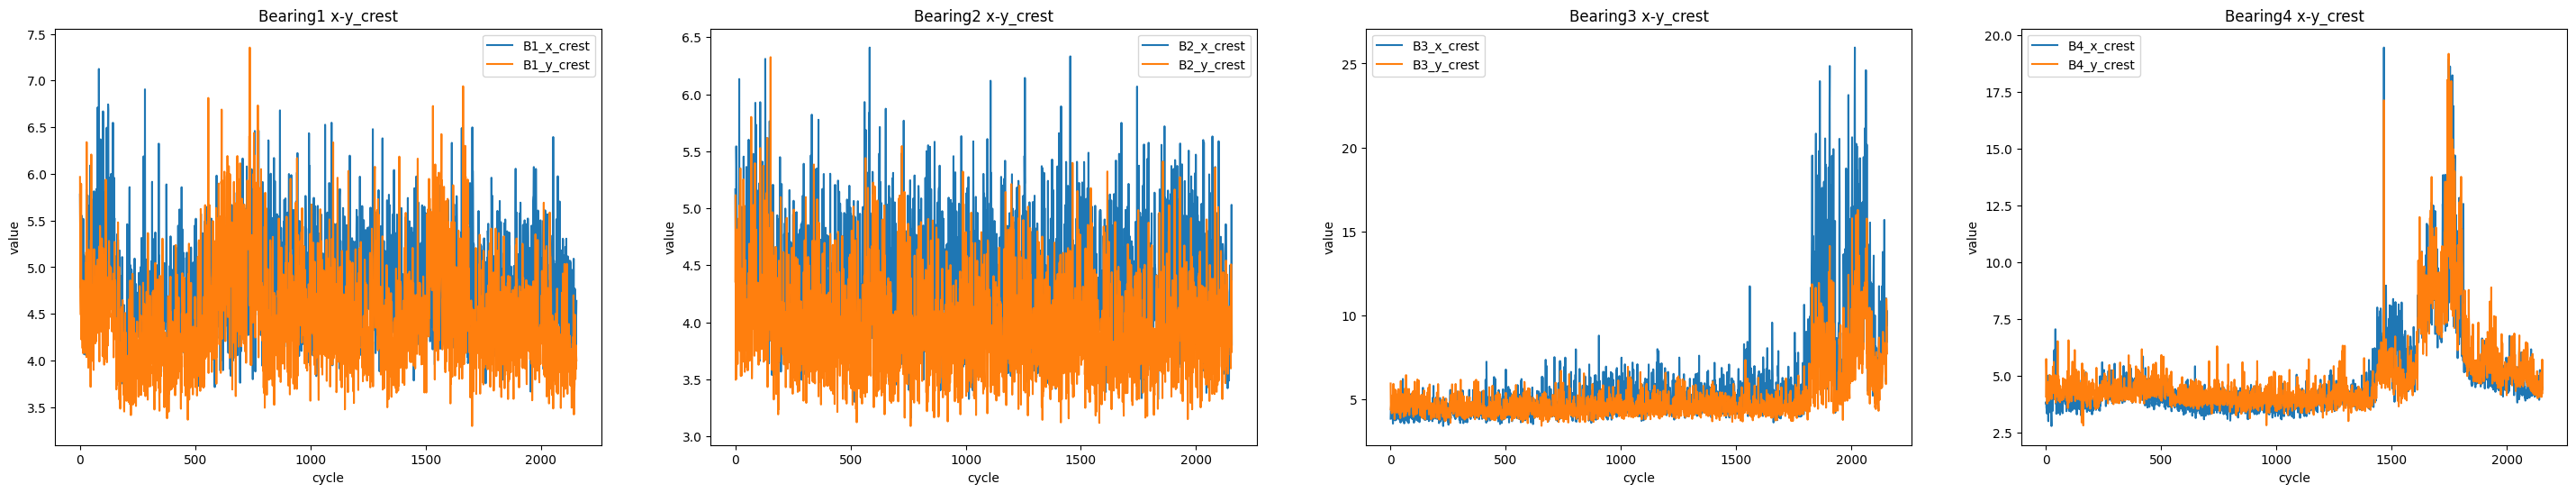

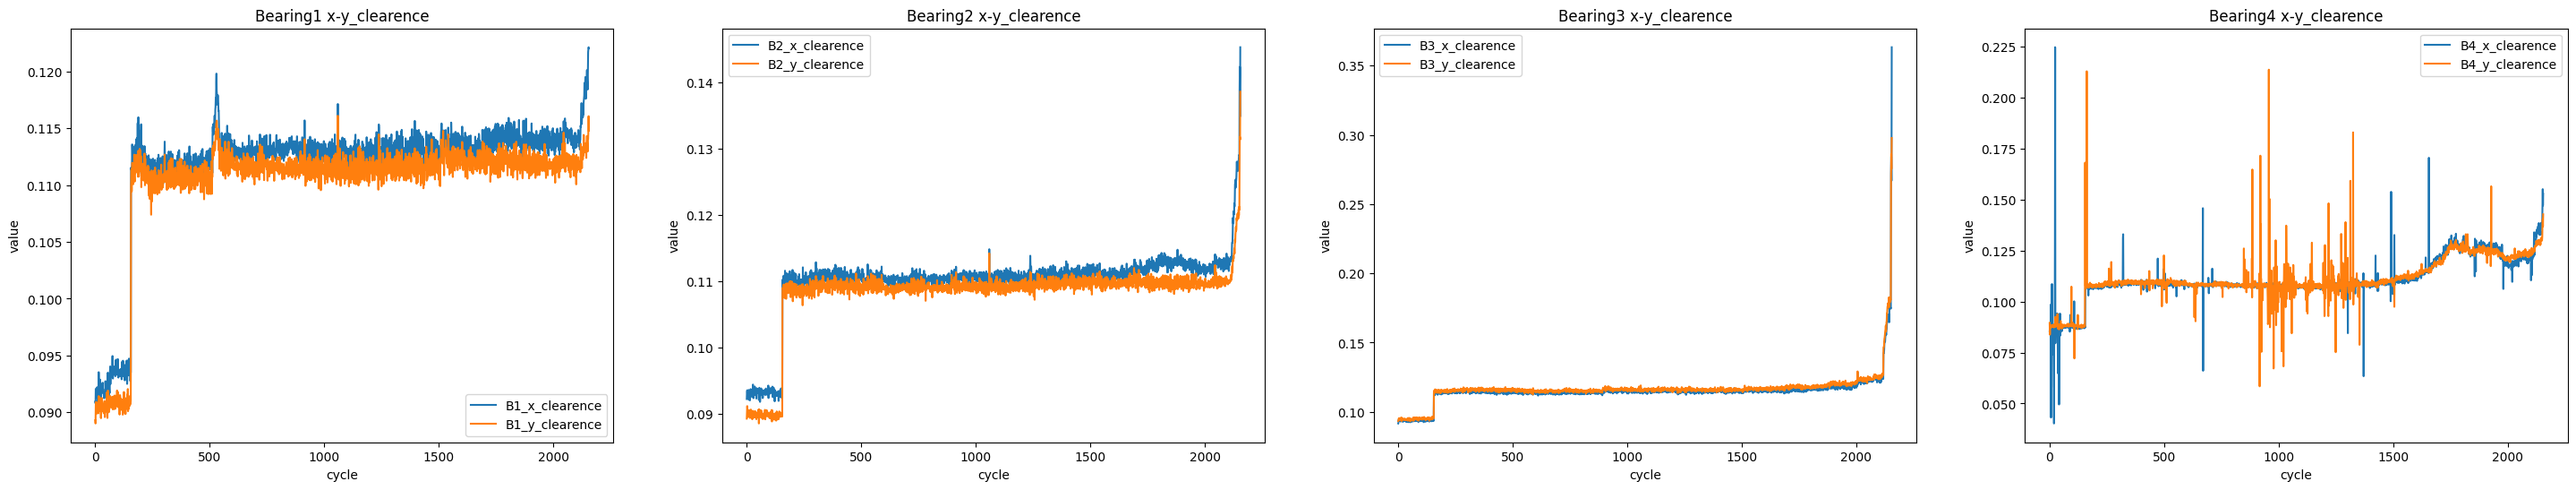

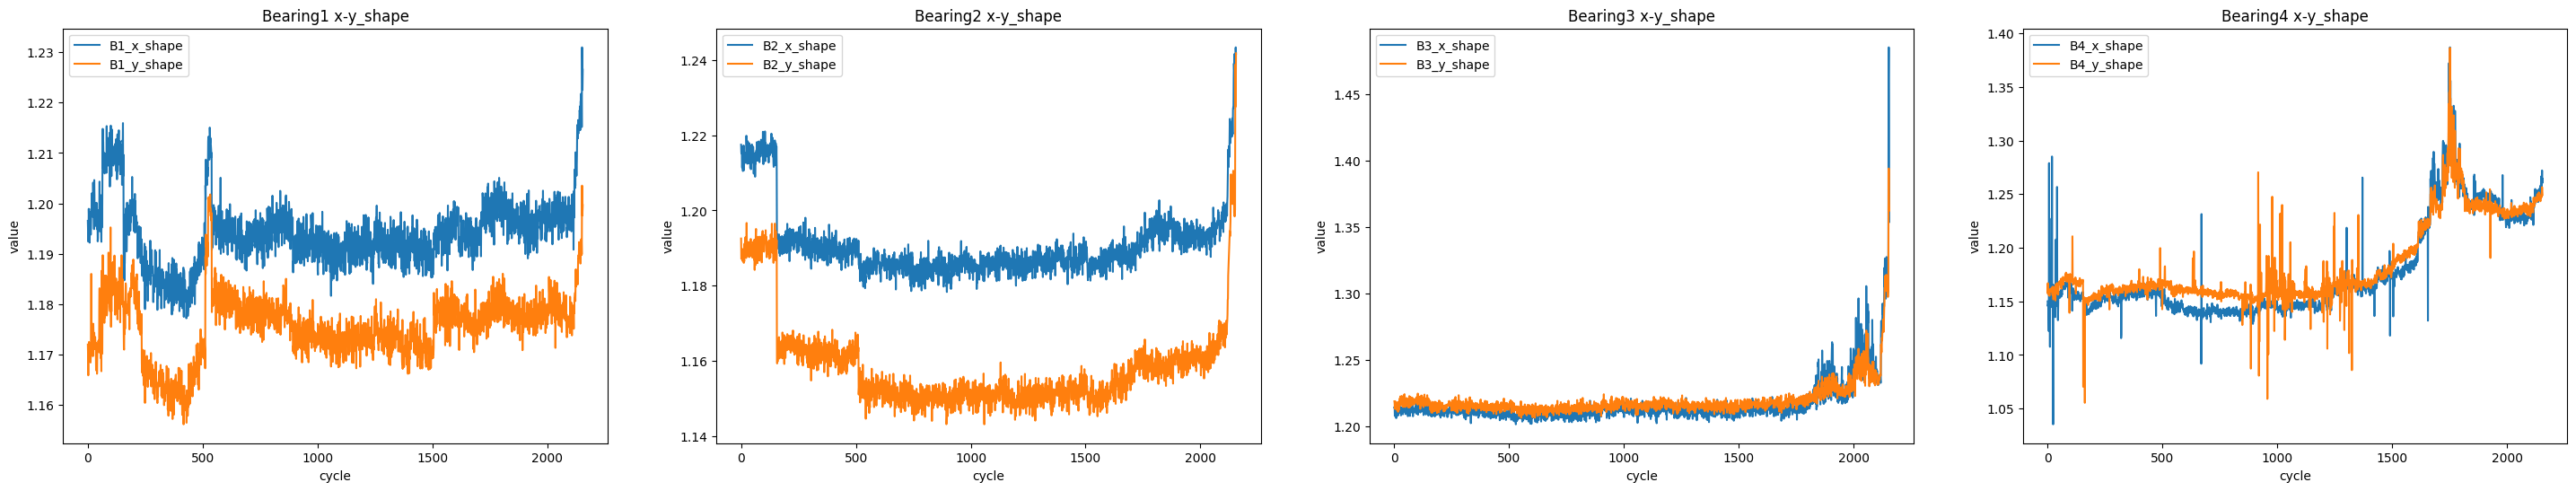

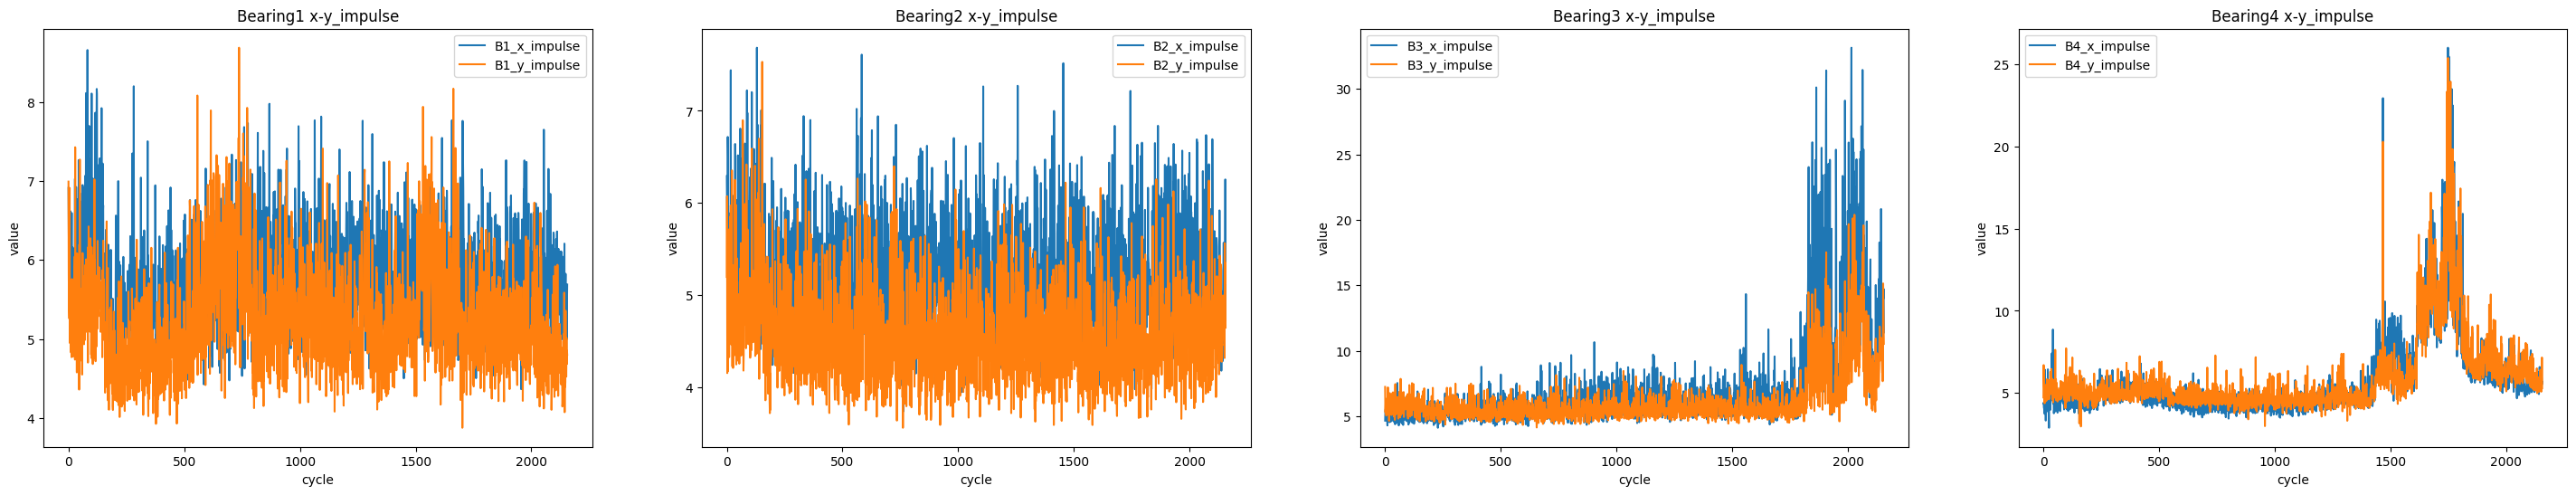

In [10]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_xy = [["B"+str(n)+"_"+str(o)+"_" for n in range(1,5)] for o in ['x','y'] ] 
#print(bearings_xy)
for tf in time_features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(141)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(142)
    #...so on
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    axes = [ax1,ax2,ax3, ax4]
    
    for i in range(4):
        col = bearings_xy[0][i]+tf
        set1[col].plot(figsize = (36,6), title="Bearing{} x-y_".format(i+1)+tf , legend = True, ax=axes[i])
        col = bearings_xy[1][i]+tf
        set1[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
        axes[i].set(xlabel="cycle", ylabel="value")
        
    
    

In [129]:
# set1_hil= dataset.iloc[:,1]
# duration = 1
# fs = len(dataset)
# samples = int(fs*duration)
# t = np.arange(samples) / fs

In [24]:
# analytic_signal = hilbert(set1_hil)
# amplitude_envelope = np.abs(analytic_signal)
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# instantaneous_frequency = (np.diff(instantaneous_phase) /
#                            (2.0*np.pi) * fs)

20479


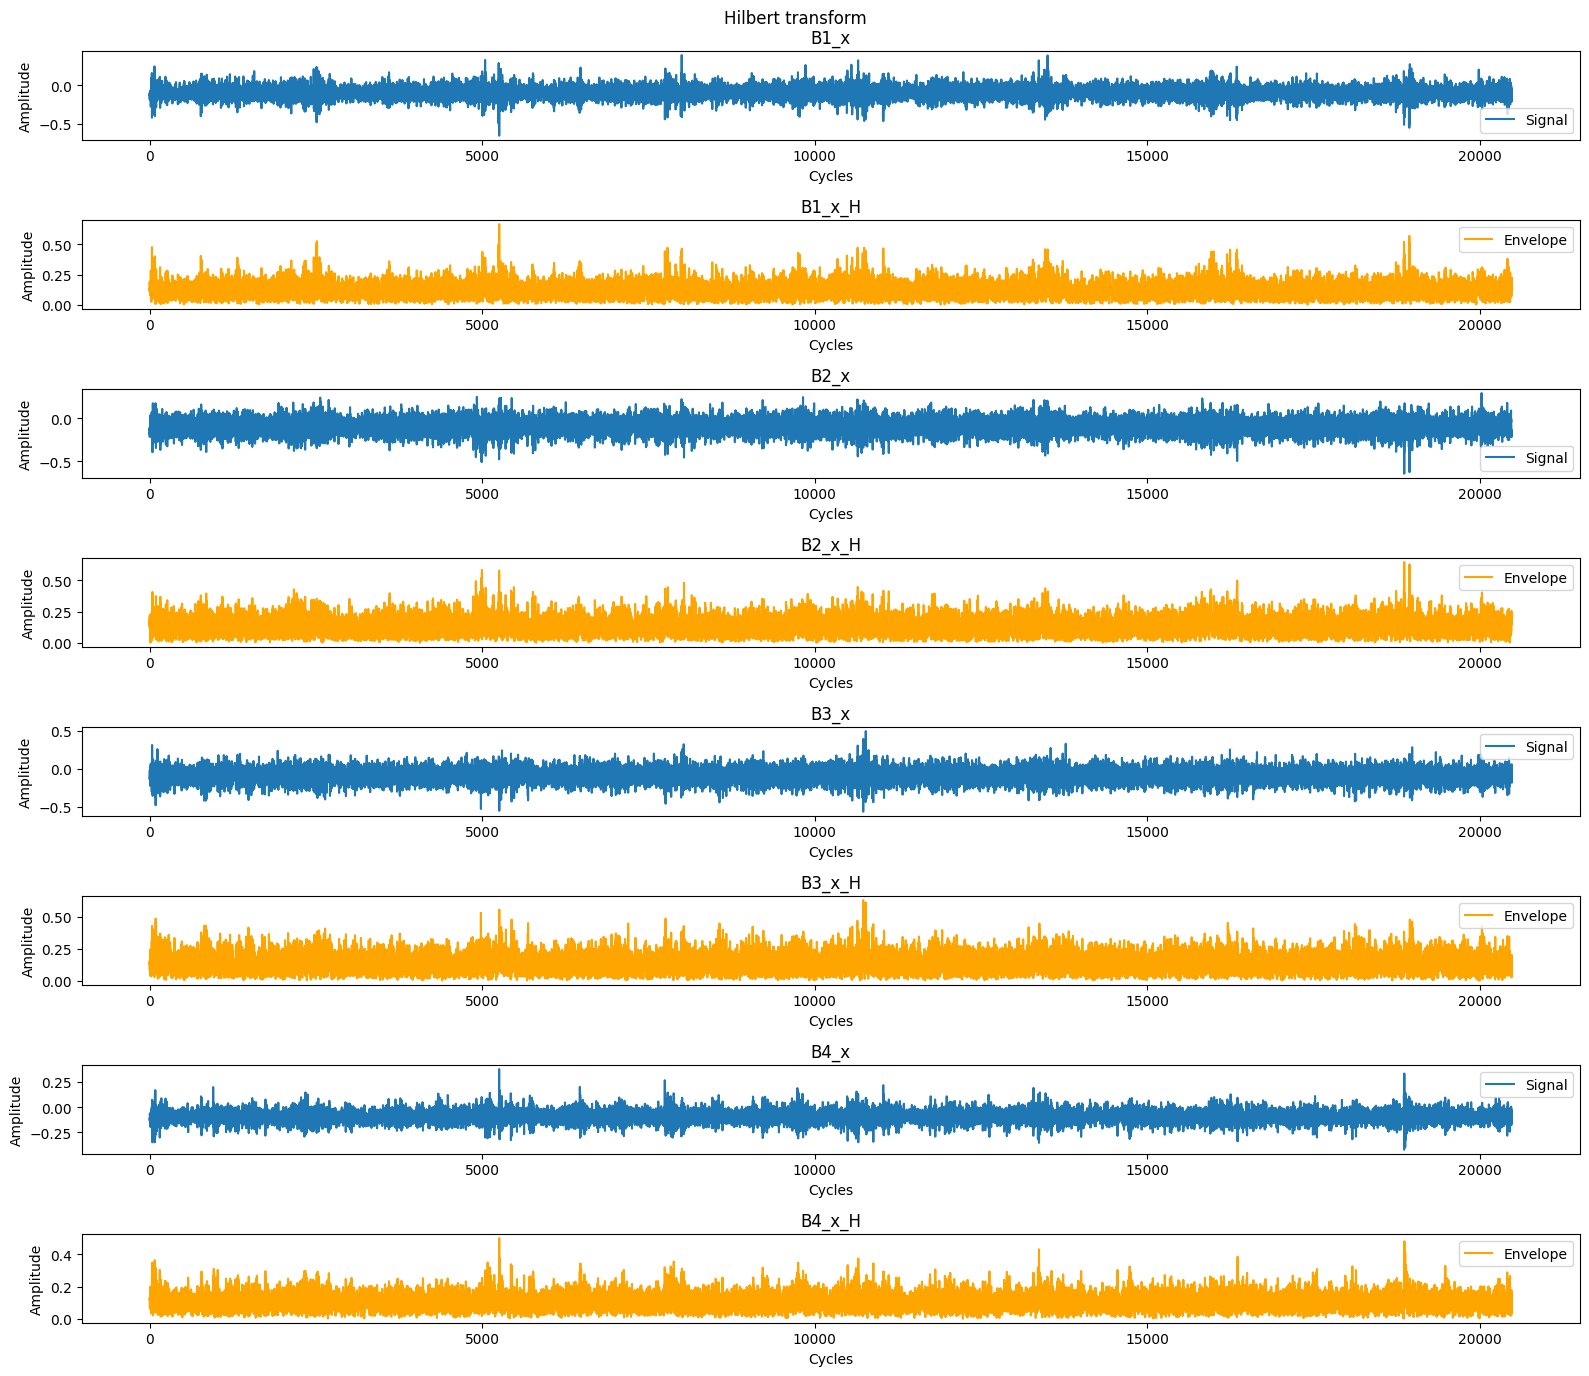

In [11]:
set1_pure= dataset.iloc[:,0]
h_signal_1 = np.abs(hilbert(set1_pure))
set2_pure= dataset.iloc[:,2]
h_signal_2 = np.abs(hilbert(set2_pure))
set3_pure= dataset.iloc[:,4]
h_signal_3 = np.abs(hilbert(set3_pure))
set4_pure= dataset.iloc[:,6]
h_signal_4 = np.abs(hilbert(set4_pure))
set5_pure= dataset.iloc[:,1]
h_signal_5 = np.abs(hilbert(set5_pure))
set6_pure= dataset.iloc[:,3]
h_signal_6 = np.abs(hilbert(set6_pure))
set7_pure= dataset.iloc[:,5]
h_signal_7 = np.abs(hilbert(set7_pure))
set8_pure= dataset.iloc[:,7]
h_signal_8 = np.abs(hilbert(set8_pure))


fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(16, 14), nrows=8)
ax0.plot(set1_pure, label='Signal')
ax0.set_title("B1_x")
ax0.set_xlabel("Cycles")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(h_signal_1, label='Envelope', color= 'orange')
ax1.set_title("B1_x_H")
ax1.set_xlabel("Cycles")
ax1.set_ylabel("Amplitude")
ax1.legend()

ax2.plot(set2_pure, label='Signal')
ax2.set_title("B2_x")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(h_signal_2, label='Envelope', color= 'orange')
ax3.set_title("B2_x_H")
ax3.set_xlabel("Cycles")
ax3.set_ylabel("Amplitude")
ax3.legend()

ax4.plot(set3_pure, label='Signal')
ax4.set_title("B3_x")
ax4.set_xlabel("Cycles")
ax4.set_ylabel("Amplitude")
ax4.legend()
ax5.plot(h_signal_3, label='Envelope', color= 'orange')
ax5.set_title("B3_x_H")
ax5.set_xlabel("Cycles")
ax5.set_ylabel("Amplitude")
ax5.legend()

ax6.plot(set4_pure, label='Signal')
ax6.set_title("B4_x")
ax6.set_xlabel("Cycles")
ax6.set_ylabel("Amplitude")
ax6.legend()
ax7.plot(h_signal_4, label='Envelope', color= 'orange')
ax7.set_title("B4_x_H")
ax7.set_xlabel("Cycles")
ax7.set_ylabel("Amplitude")
ax7.legend()

fig.suptitle('Hilbert transform')
fig.tight_layout()

In [12]:
#sine information
set1_fft_r= np.fft.fft(h_signal_1).real
set2_fft_r= np.fft.fft(h_signal_2).real
set3_fft_r= np.fft.fft(h_signal_3).real
set4_fft_r= np.fft.fft(h_signal_4).real
set5_fft_r= np.fft.fft(h_signal_5).real
set6_fft_r= np.fft.fft(h_signal_6).real
set7_fft_r= np.fft.fft(h_signal_7).real
set8_fft_r= np.fft.fft(h_signal_8).real

#cosine information
set1_fft_i= np.fft.fft(h_signal_1).imag
set2_fft_i= np.fft.fft(h_signal_2).imag
set3_fft_i= np.fft.fft(h_signal_3).imag
set4_fft_i= np.fft.fft(h_signal_4).imag
set5_fft_i= np.fft.fft(h_signal_5).imag
set6_fft_i= np.fft.fft(h_signal_6).imag
set7_fft_i= np.fft.fft(h_signal_7).imag
set8_fft_i= np.fft.fft(h_signal_8).imag

#magnitude
set1_fft= np.abs(np.fft.fft(h_signal_1) /len (h_signal_1))
set2_fft= np.abs(np.fft.fft(h_signal_2) /len (h_signal_2))
set3_fft= np.abs(np.fft.fft(h_signal_3) /len (h_signal_3))
set4_fft= np.abs(np.fft.fft(h_signal_4) /len (h_signal_4))
set5_fft= np.abs(np.fft.fft(h_signal_5) /len (h_signal_5))
set6_fft= np.abs(np.fft.fft(h_signal_6) /len (h_signal_6))
set7_fft= np.abs(np.fft.fft(h_signal_7) /len (h_signal_7))
set8_fft= np.abs(np.fft.fft(h_signal_8) /len (h_signal_8))

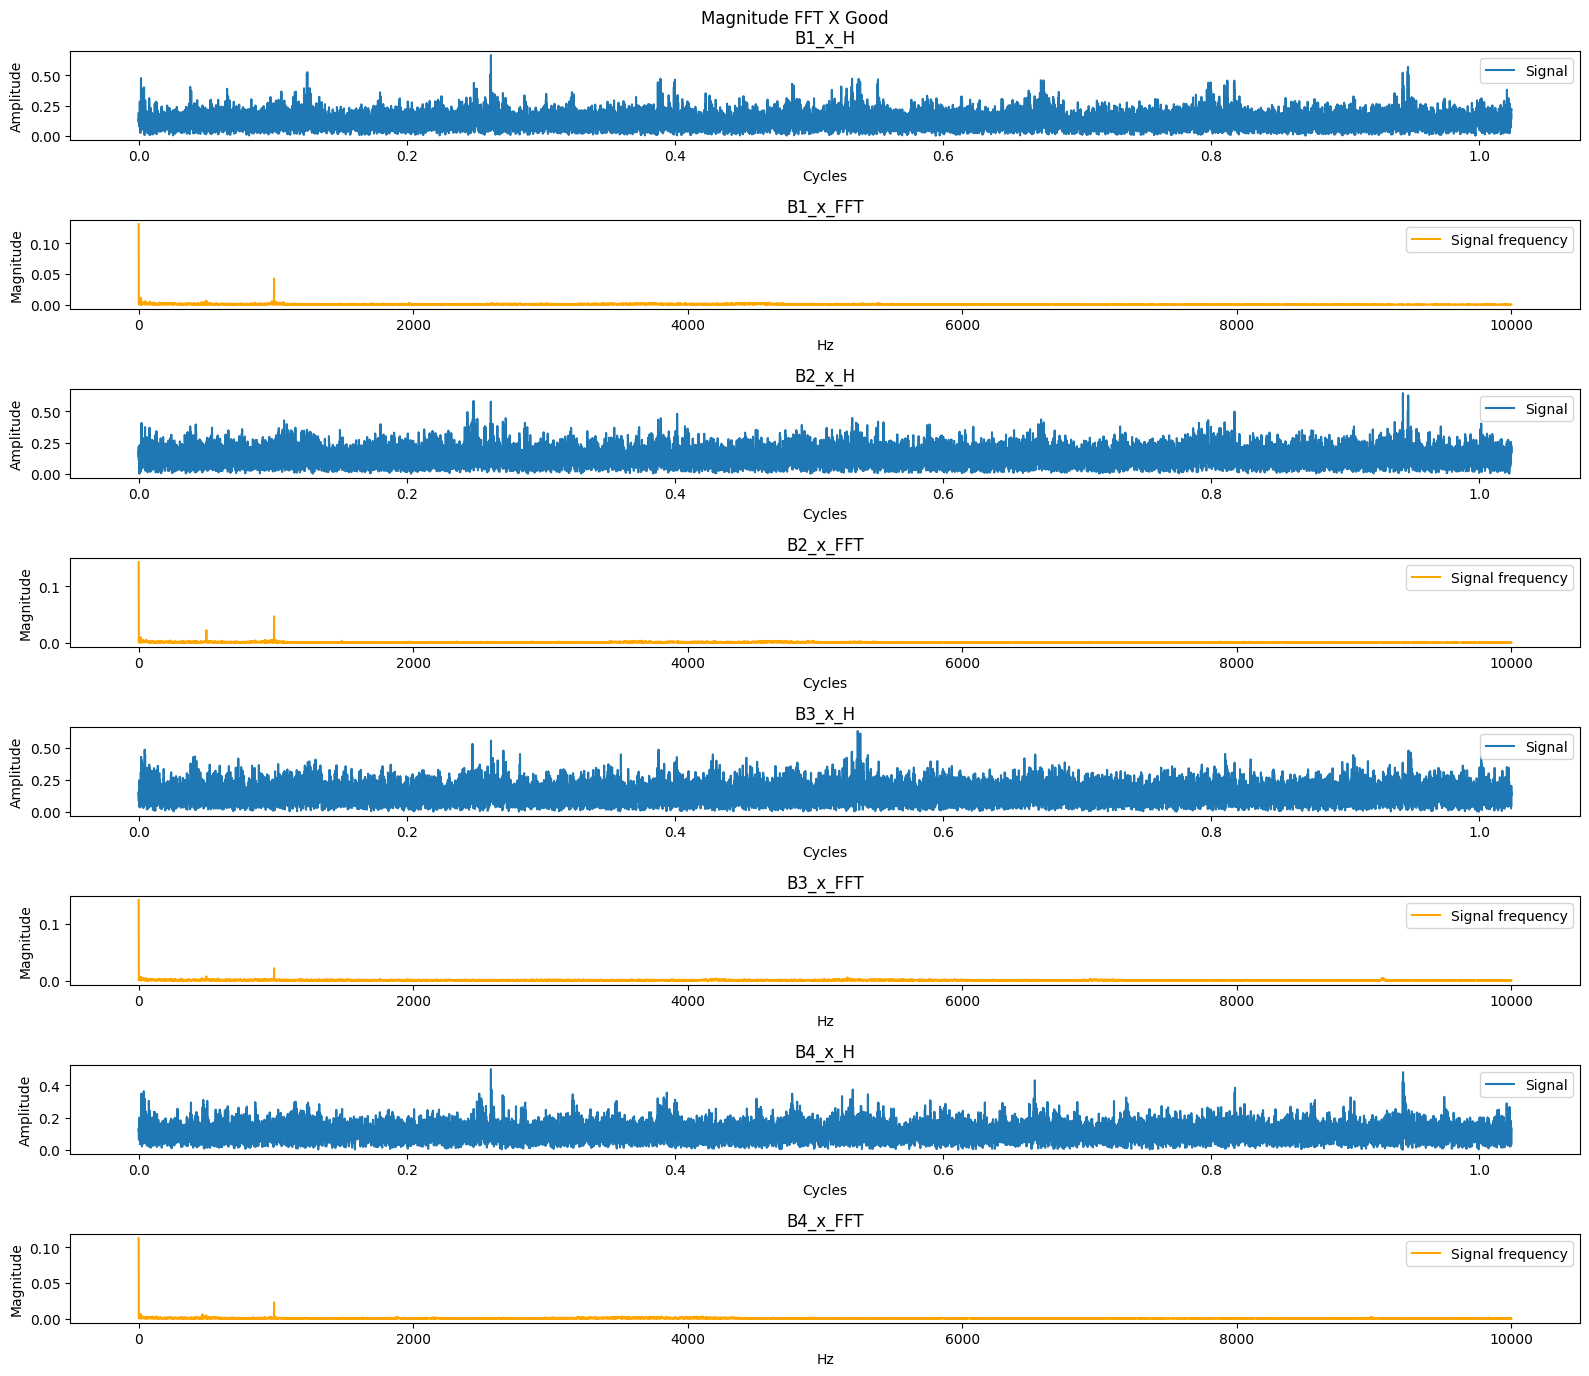

In [13]:
N = len(set1_fft)

#From the specs of Kaggle NASA dataset
Fsamp = 20000

Ts = 1/Fsamp

# timestep = 10
# freq = np.fft.fftfreq(N, d=timestep)

t= np.linspace(0, (N-1)*Ts, N)
Fs= Fsamp/ N
f= np.linspace(0, (N-1)*Fs, N)

f_plot= f[0:int(N/2+1)]
set1_fft_mag= 2 * set1_fft [0:int(N/2+1)]
set1_fft_mag[0]= set1_fft_mag[0] / 2
set2_fft_mag= 2 * set2_fft [0:int(N/2+1)]
set2_fft_mag[0]= set2_fft_mag[0] / 2
set3_fft_mag= 2 * set3_fft [0:int(N/2+1)]
set3_fft_mag[0]= set3_fft_mag[0] / 2
set4_fft_mag= 2 * set4_fft [0:int(N/2+1)]
set4_fft_mag[0]= set4_fft_mag[0] / 2
set5_fft_mag= 2 * set5_fft [0:int(N/2+1)]
set5_fft_mag[0]= set5_fft_mag[0] / 2
set6_fft_mag= 2 * set6_fft [0:int(N/2+1)]
set6_fft_mag[0]= set6_fft_mag[0] / 2
set7_fft_mag= 2 * set7_fft [0:int(N/2+1)]
set7_fft_mag[0]= set7_fft_mag[0] / 2
set8_fft_mag= 2 * set8_fft [0:int(N/2+1)]
set8_fft_mag[0]= set8_fft_mag[0] / 2

fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(16, 14), nrows=8)
ax0.plot(t, h_signal_1, label='Signal')
ax0.set_title("B1_x_H")
ax0.set_xlabel("Cycles")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(f_plot, set1_fft_mag, label='Signal frequency', color= 'orange')
ax1.set_title("B1_x_FFT")
ax1.set_xlabel("Hz")
ax1.set_ylabel("Magnitude")
ax1.legend()

ax2.plot(t, h_signal_2, label='Signal')
ax2.set_title("B2_x_H")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(f_plot, set2_fft_mag, label='Signal frequency', color= 'orange')
ax3.set_title("B2_x_FFT")
ax3.set_xlabel("Cycles")
ax3.set_ylabel("Magnitude")
ax3.legend()

ax4.plot(t, h_signal_3, label='Signal')
ax4.set_title("B3_x_H")
ax4.set_xlabel("Cycles")
ax4.set_ylabel("Amplitude")
ax4.legend()
ax5.plot(f_plot, set3_fft_mag, label='Signal frequency', color= 'orange')
ax5.set_title("B3_x_FFT")
ax5.set_xlabel("Hz")
ax5.set_ylabel("Magnitude")
ax5.legend()

ax6.plot(t, h_signal_4, label='Signal')
ax6.set_title("B4_x_H")
ax6.set_xlabel("Cycles")
ax6.set_ylabel("Amplitude")
ax6.legend()
ax7.plot(f_plot, set4_fft_mag, label='Signal frequency', color= 'orange')
ax7.set_title("B4_x_FFT")
ax7.set_xlabel("Hz")
ax7.set_ylabel("Magnitude")
ax7.legend()

fig.suptitle('Magnitude FFT X Good')
fig.tight_layout()

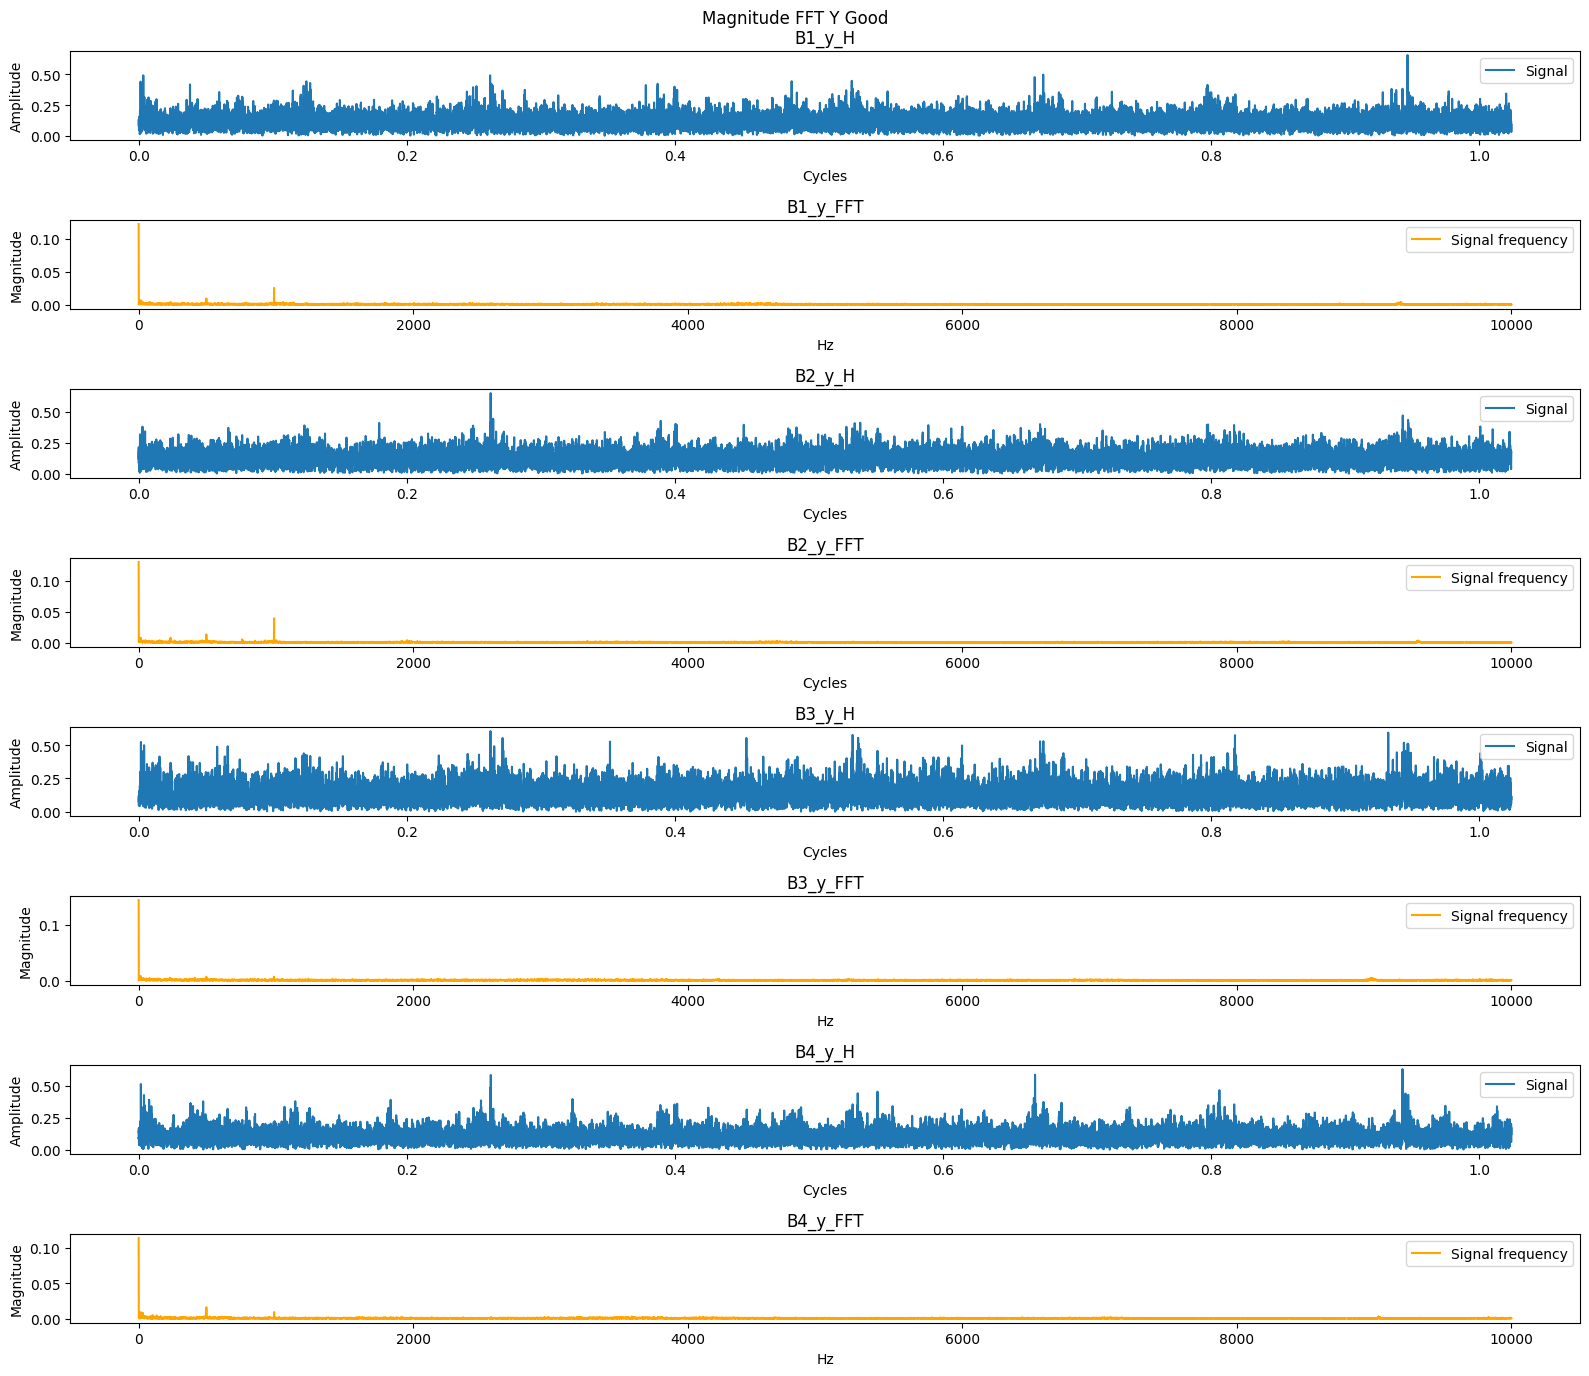

In [7]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(16, 14), nrows=8)
ax0.plot(t, h_signal_5, label='Signal')
ax0.set_title("B1_y_H")
ax0.set_xlabel("Cycles")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(f_plot, set5_fft_mag, label='Signal frequency', color= 'orange')
ax1.set_title("B1_y_FFT")
ax1.set_xlabel("Hz")
ax1.set_ylabel("Magnitude")
ax1.legend()

ax2.plot(t, h_signal_6, label='Signal')
ax2.set_title("B2_y_H")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(f_plot, set6_fft_mag, label='Signal frequency', color= 'orange')
ax3.set_title("B2_y_FFT")
ax3.set_xlabel("Cycles")
ax3.set_ylabel("Magnitude")
ax3.legend()

ax4.plot(t, h_signal_7, label='Signal')
ax4.set_title("B3_y_H")
ax4.set_xlabel("Cycles")
ax4.set_ylabel("Amplitude")
ax4.legend()
ax5.plot(f_plot, set7_fft_mag, label='Signal frequency', color= 'orange')
ax5.set_title("B3_y_FFT")
ax5.set_xlabel("Hz")
ax5.set_ylabel("Magnitude")
ax5.legend()

ax6.plot(t, h_signal_8, label='Signal')
ax6.set_title("B4_y_H")
ax6.set_xlabel("Cycles")
ax6.set_ylabel("Amplitude")
ax6.legend()
ax7.plot(f_plot, set8_fft_mag, label='Signal frequency', color= 'orange')
ax7.set_title("B4_y_FFT")
ax7.set_xlabel("Hz")
ax7.set_ylabel("Magnitude")
ax7.legend()

fig.suptitle('Magnitude FFT Y Good')
fig.tight_layout()

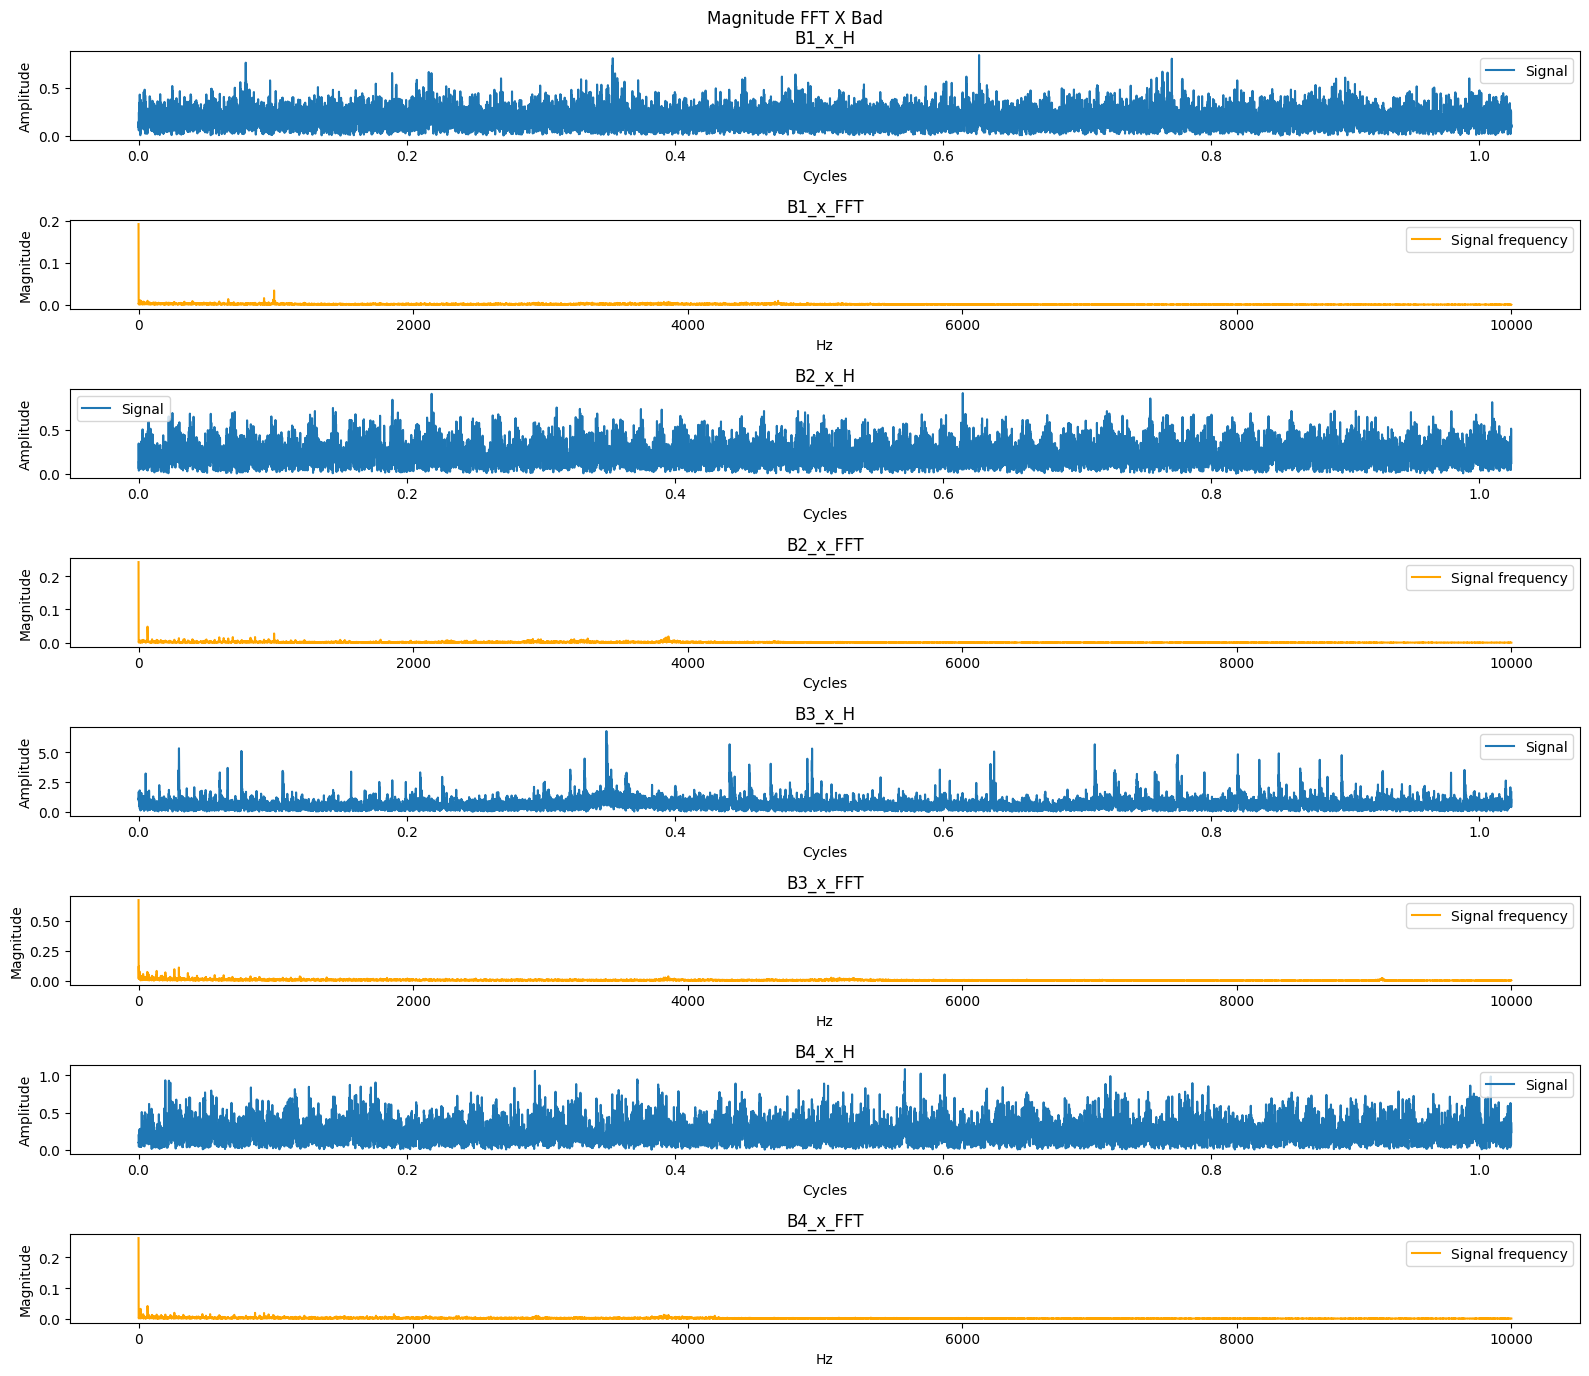

In [14]:
N = len(set1_fft)

#From the specs of Kaggle NASA dataset
Fsamp = 20000

Ts = 1/Fsamp

# timestep = 10
# freq = np.fft.fftfreq(N, d=timestep)

t= np.linspace(0, (N-1)*Ts, N)
Fs= Fsamp/ N
f= np.linspace(0, (N-1)*Fs, N)

f_plot= f[0:int(N/2+1)]
set1_fft_mag= 2 * set1_fft [0:int(N/2+1)]
set1_fft_mag[0]= set1_fft_mag[0] / 2
set2_fft_mag= 2 * set2_fft [0:int(N/2+1)]
set2_fft_mag[0]= set2_fft_mag[0] / 2
set3_fft_mag= 2 * set3_fft [0:int(N/2+1)]
set3_fft_mag[0]= set3_fft_mag[0] / 2
set4_fft_mag= 2 * set4_fft [0:int(N/2+1)]
set4_fft_mag[0]= set4_fft_mag[0] / 2
set5_fft_mag= 2 * set5_fft [0:int(N/2+1)]
set5_fft_mag[0]= set5_fft_mag[0] / 2
set6_fft_mag= 2 * set6_fft [0:int(N/2+1)]
set6_fft_mag[0]= set6_fft_mag[0] / 2
set7_fft_mag= 2 * set7_fft [0:int(N/2+1)]
set7_fft_mag[0]= set7_fft_mag[0] / 2
set8_fft_mag= 2 * set8_fft [0:int(N/2+1)]
set8_fft_mag[0]= set8_fft_mag[0] / 2

fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(16, 14), nrows=8)
ax0.plot(t, h_signal_1, label='Signal')
ax0.set_title("B1_x_H")
ax0.set_xlabel("Cycles")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(f_plot, set1_fft_mag, label='Signal frequency', color= 'orange')
ax1.set_title("B1_x_FFT")
ax1.set_xlabel("Hz")
ax1.set_ylabel("Magnitude")
ax1.legend()

ax2.plot(t, h_signal_2, label='Signal')
ax2.set_title("B2_x_H")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(f_plot, set2_fft_mag, label='Signal frequency', color= 'orange')
ax3.set_title("B2_x_FFT")
ax3.set_xlabel("Cycles")
ax3.set_ylabel("Magnitude")
ax3.legend()

ax4.plot(t, h_signal_3, label='Signal')
ax4.set_title("B3_x_H")
ax4.set_xlabel("Cycles")
ax4.set_ylabel("Amplitude")
ax4.legend()
ax5.plot(f_plot, set3_fft_mag, label='Signal frequency', color= 'orange')
ax5.set_title("B3_x_FFT")
ax5.set_xlabel("Hz")
ax5.set_ylabel("Magnitude")
ax5.legend()

ax6.plot(t, h_signal_4, label='Signal')
ax6.set_title("B4_x_H")
ax6.set_xlabel("Cycles")
ax6.set_ylabel("Amplitude")
ax6.legend()
ax7.plot(f_plot, set4_fft_mag, label='Signal frequency', color= 'orange')
ax7.set_title("B4_x_FFT")
ax7.set_xlabel("Hz")
ax7.set_ylabel("Magnitude")
ax7.legend()

fig.suptitle('Magnitude FFT X Bad')
fig.tight_layout()

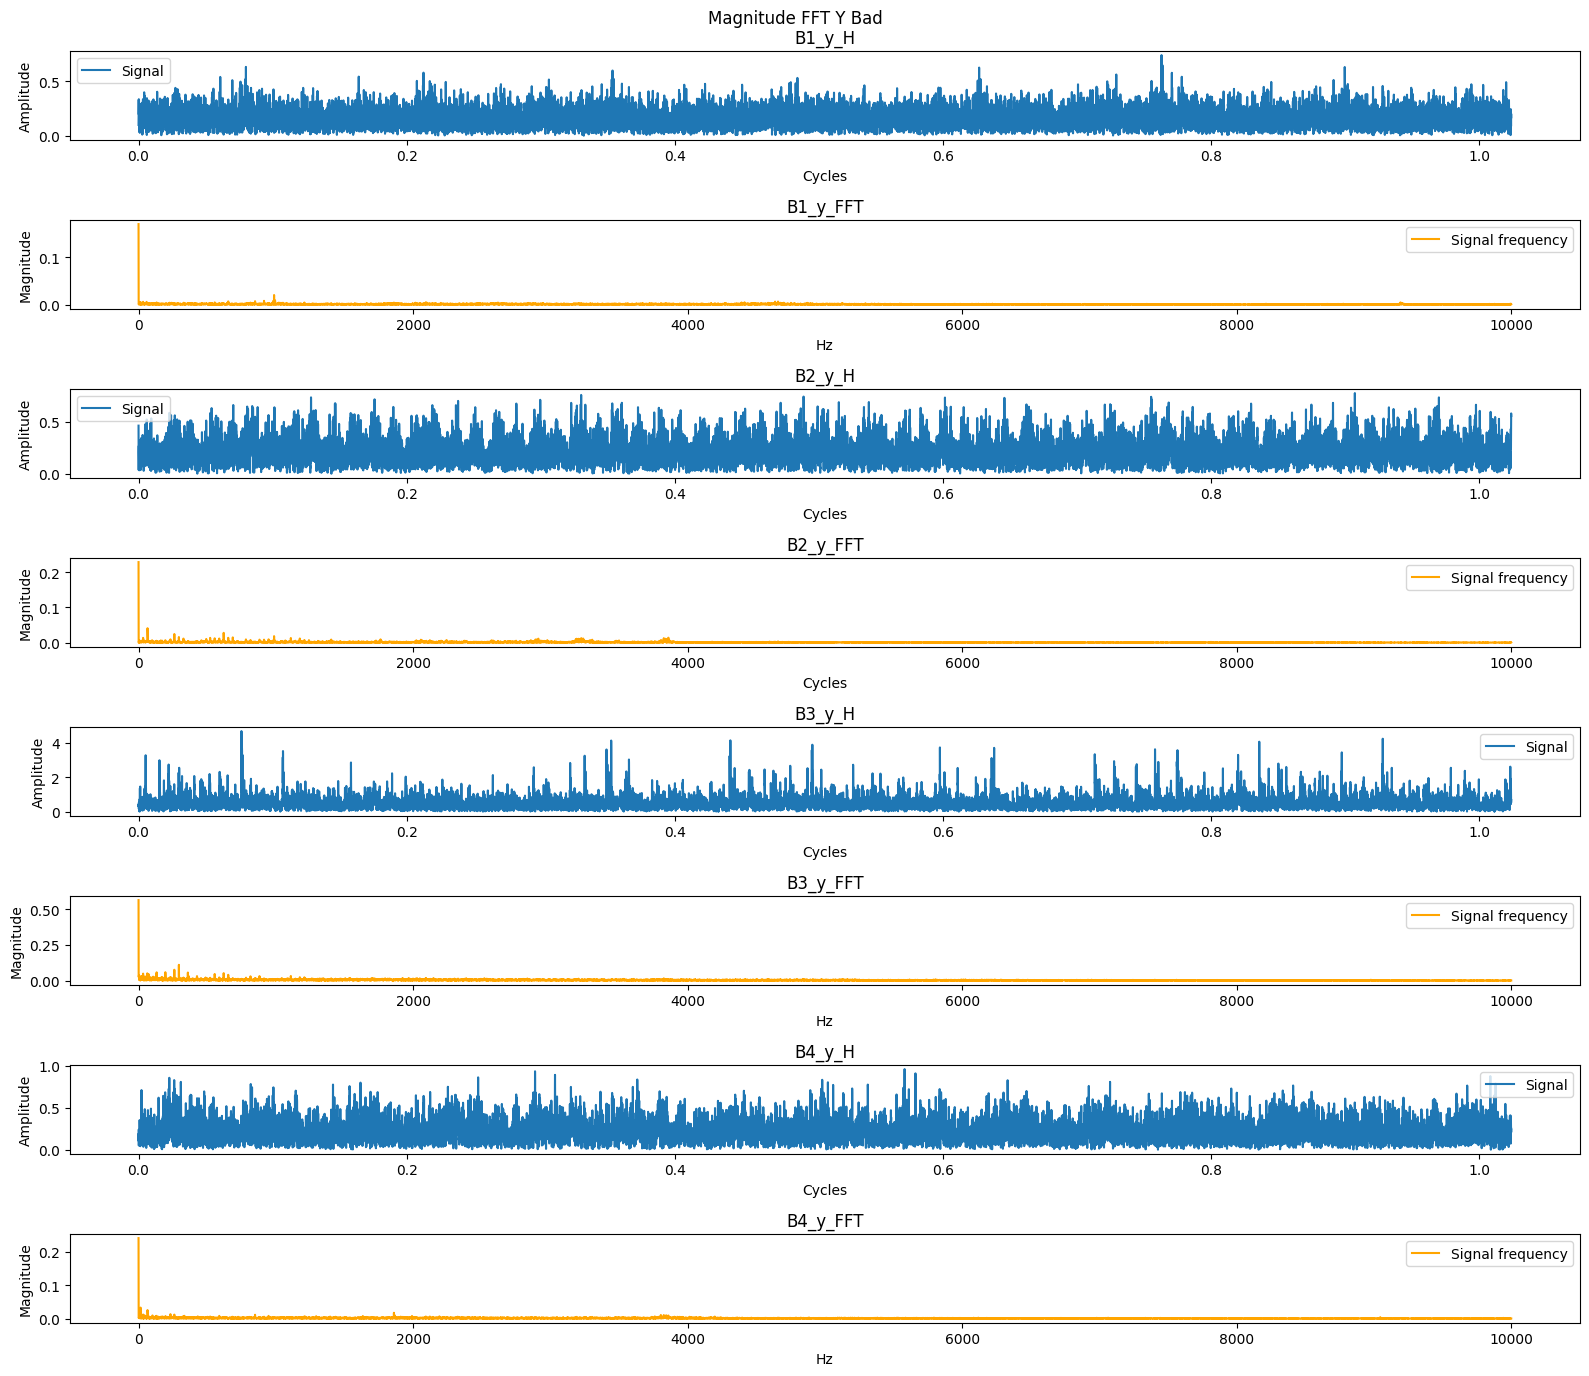

In [13]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(16, 14), nrows=8)
ax0.plot(t, h_signal_5, label='Signal')
ax0.set_title("B1_y_H")
ax0.set_xlabel("Cycles")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(f_plot, set5_fft_mag, label='Signal frequency', color= 'orange')
ax1.set_title("B1_y_FFT")
ax1.set_xlabel("Hz")
ax1.set_ylabel("Magnitude")
ax1.legend()

ax2.plot(t, h_signal_6, label='Signal')
ax2.set_title("B2_y_H")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(f_plot, set6_fft_mag, label='Signal frequency', color= 'orange')
ax3.set_title("B2_y_FFT")
ax3.set_xlabel("Cycles")
ax3.set_ylabel("Magnitude")
ax3.legend()

ax4.plot(t, h_signal_7, label='Signal')
ax4.set_title("B3_y_H")
ax4.set_xlabel("Cycles")
ax4.set_ylabel("Amplitude")
ax4.legend()
ax5.plot(f_plot, set7_fft_mag, label='Signal frequency', color= 'orange')
ax5.set_title("B3_y_FFT")
ax5.set_xlabel("Hz")
ax5.set_ylabel("Magnitude")
ax5.legend()

ax6.plot(t, h_signal_8, label='Signal')
ax6.set_title("B4_y_H")
ax6.set_xlabel("Cycles")
ax6.set_ylabel("Amplitude")
ax6.legend()
ax7.plot(f_plot, set8_fft_mag, label='Signal frequency', color= 'orange')
ax7.set_title("B4_y_FFT")
ax7.set_xlabel("Hz")
ax7.set_ylabel("Magnitude")
ax7.legend()

fig.suptitle('Magnitude FFT Y Bad')
fig.tight_layout()

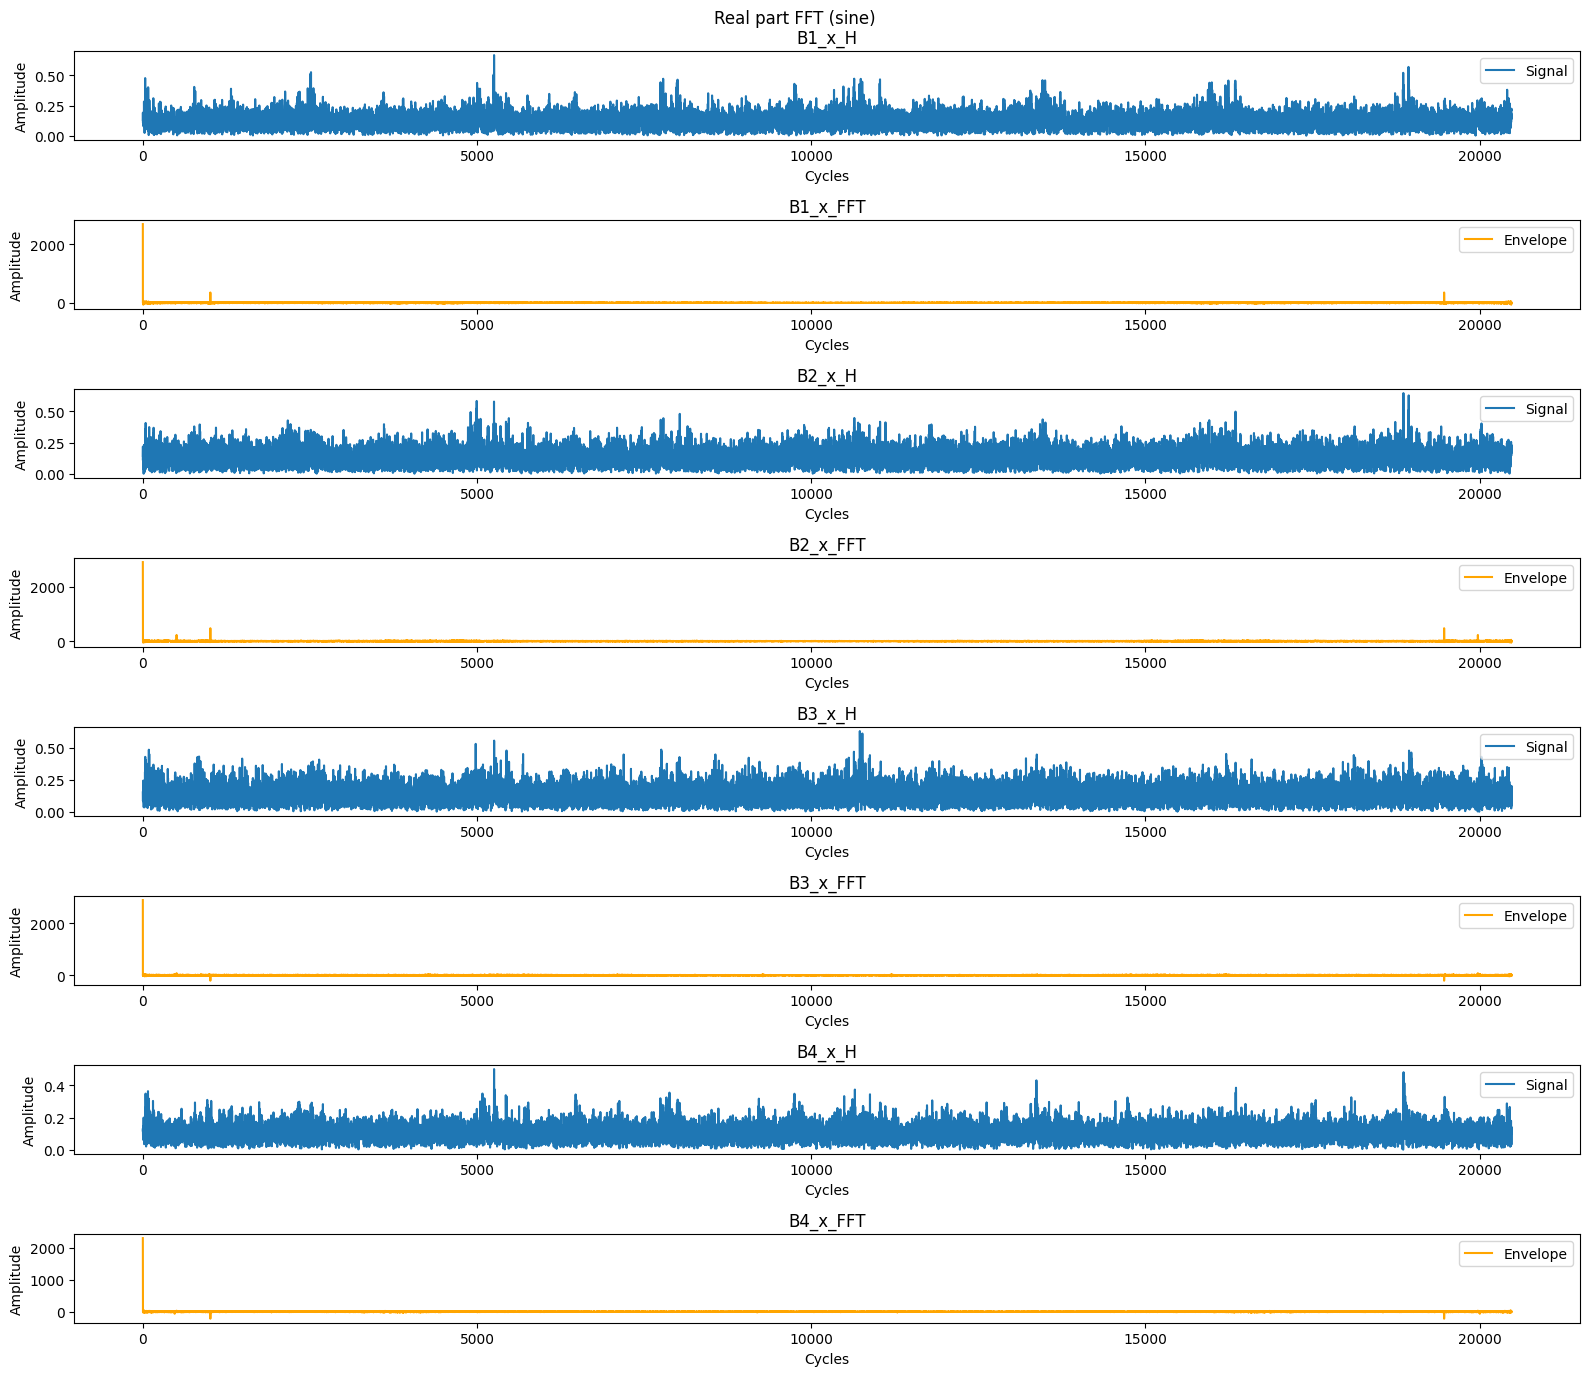

In [13]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(16, 14), nrows=8)
ax0.plot(h_signal_1, label='Signal')
ax0.set_title("B1_x_H")
ax0.set_xlabel("Cycles")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(set1_fft_r, label='Envelope', color= 'orange')
ax1.set_title("B1_x_FFT")
ax1.set_xlabel("Cycles")
ax1.set_ylabel("Amplitude")
ax1.legend()

ax2.plot(h_signal_2, label='Signal')
ax2.set_title("B2_x_H")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(set2_fft_r, label='Envelope', color= 'orange')
ax3.set_title("B2_x_FFT")
ax3.set_xlabel("Cycles")
ax3.set_ylabel("Amplitude")
ax3.legend()

ax4.plot(h_signal_3, label='Signal')
ax4.set_title("B3_x_H")
ax4.set_xlabel("Cycles")
ax4.set_ylabel("Amplitude")
ax4.legend()
ax5.plot(set3_fft_r, label='Envelope', color= 'orange')
ax5.set_title("B3_x_FFT")
ax5.set_xlabel("Cycles")
ax5.set_ylabel("Amplitude")
ax5.legend()

ax6.plot(h_signal_4, label='Signal')
ax6.set_title("B4_x_H")
ax6.set_xlabel("Cycles")
ax6.set_ylabel("Amplitude")
ax6.legend()
ax7.plot(set4_fft_r, label='Envelope', color= 'orange')
ax7.set_title("B4_x_FFT")
ax7.set_xlabel("Cycles")
ax7.set_ylabel("Amplitude")
ax7.legend()

fig.suptitle('Real part FFT (sine)')
fig.tight_layout()

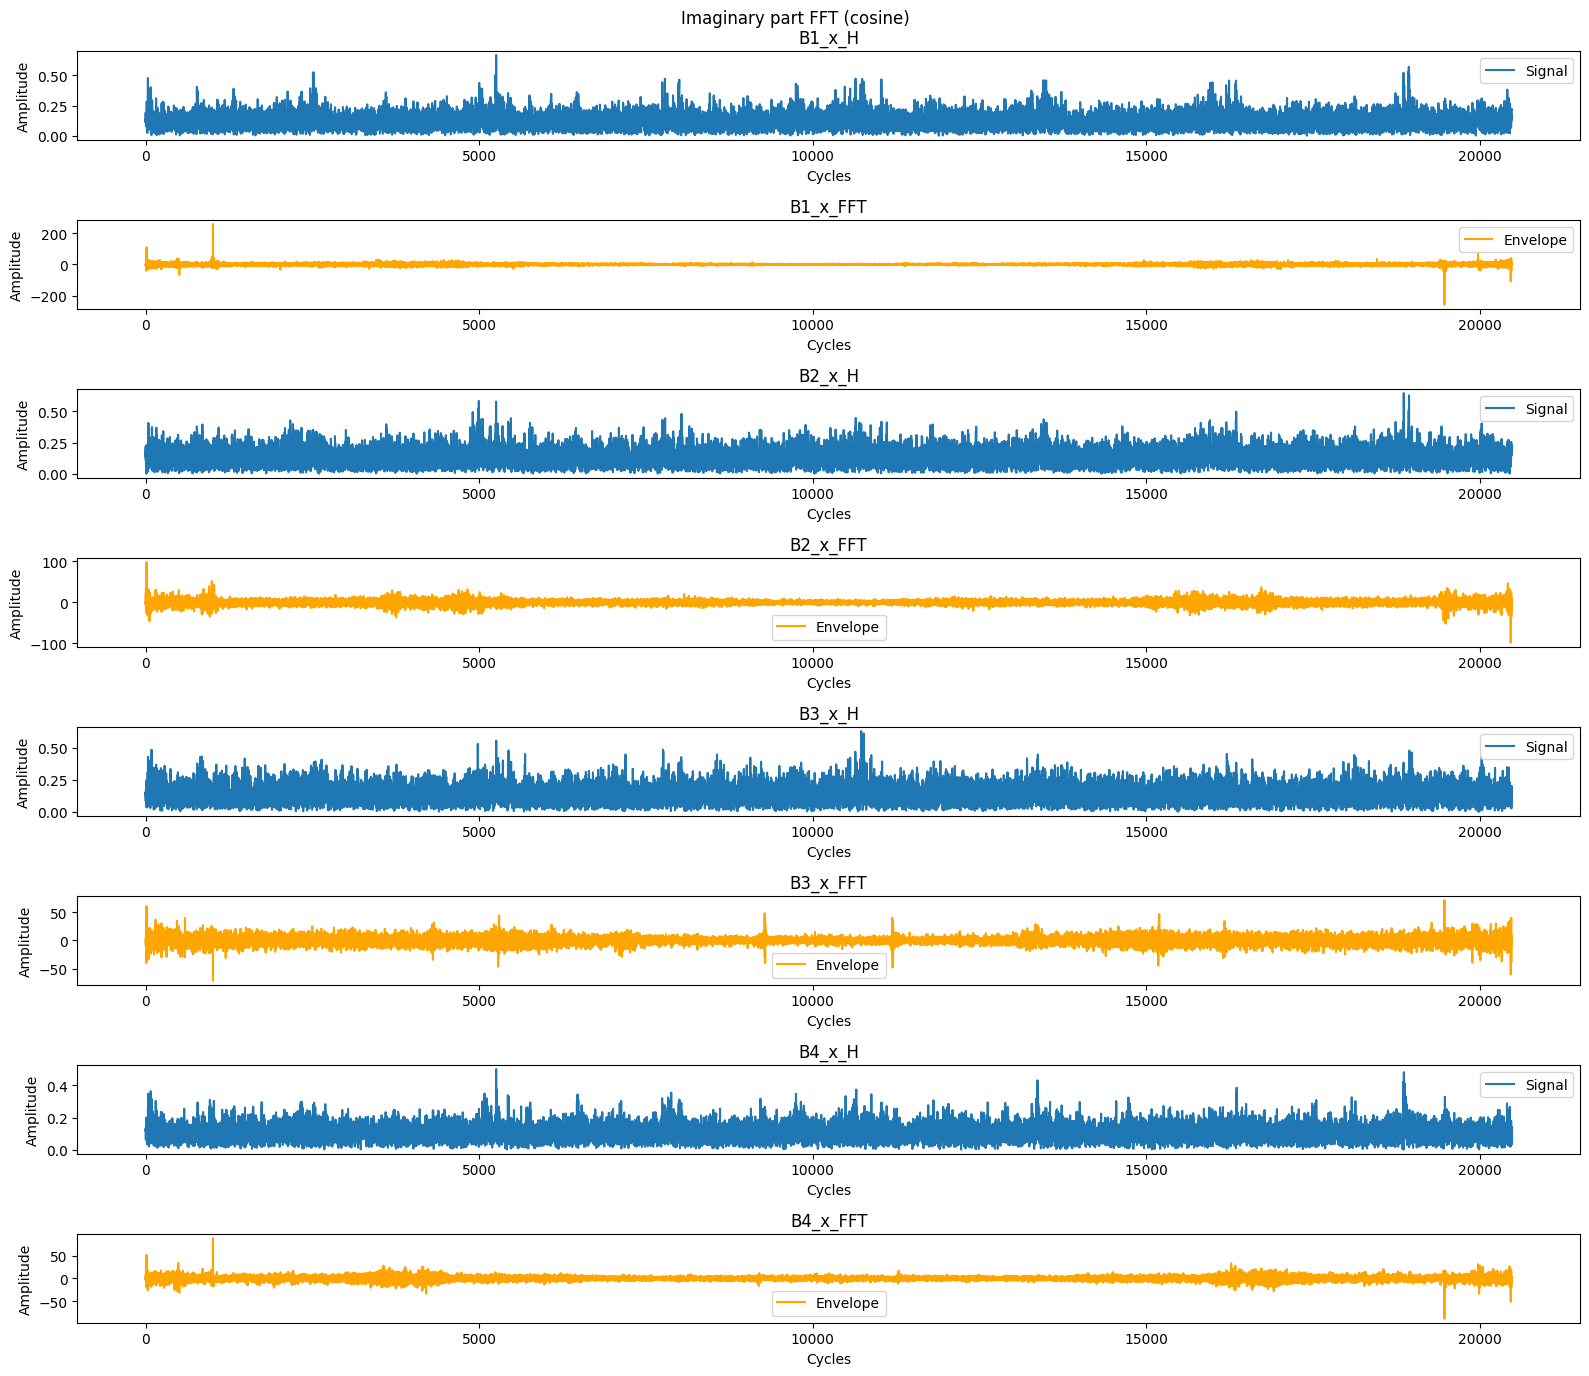

In [45]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(figsize=(16, 14), nrows=8)
ax0.plot(h_signal_1, label='Signal')
ax0.set_title("B1_x_H")
ax0.set_xlabel("Cycles")
ax0.set_ylabel("Amplitude")
ax0.legend()
ax1.plot(set1_fft_i, label='Envelope', color= 'orange')
ax1.set_title("B1_x_FFT")
ax1.set_xlabel("Cycles")
ax1.set_ylabel("Amplitude")
ax1.legend()

ax2.plot(h_signal_2, label='Signal')
ax2.set_title("B2_x_H")
ax2.set_xlabel("Cycles")
ax2.set_ylabel("Amplitude")
ax2.legend()
ax3.plot(set2_fft_i, label='Envelope', color= 'orange')
ax3.set_title("B2_x_FFT")
ax3.set_xlabel("Cycles")
ax3.set_ylabel("Amplitude")
ax3.legend()

ax4.plot(h_signal_3, label='Signal')
ax4.set_title("B3_x_H")
ax4.set_xlabel("Cycles")
ax4.set_ylabel("Amplitude")
ax4.legend()
ax5.plot(set3_fft_i, label='Envelope', color= 'orange')
ax5.set_title("B3_x_FFT")
ax5.set_xlabel("Cycles")
ax5.set_ylabel("Amplitude")
ax5.legend()

ax6.plot(h_signal_4, label='Signal')
ax6.set_title("B4_x_H")
ax6.set_xlabel("Cycles")
ax6.set_ylabel("Amplitude")
ax6.legend()
ax7.plot(set4_fft_i, label='Envelope', color= 'orange')
ax7.set_title("B4_x_FFT")
ax7.set_xlabel("Cycles")
ax7.set_ylabel("Amplitude")
ax7.legend()

fig.suptitle('Imaginary part FFT (cosine)')
fig.tight_layout()

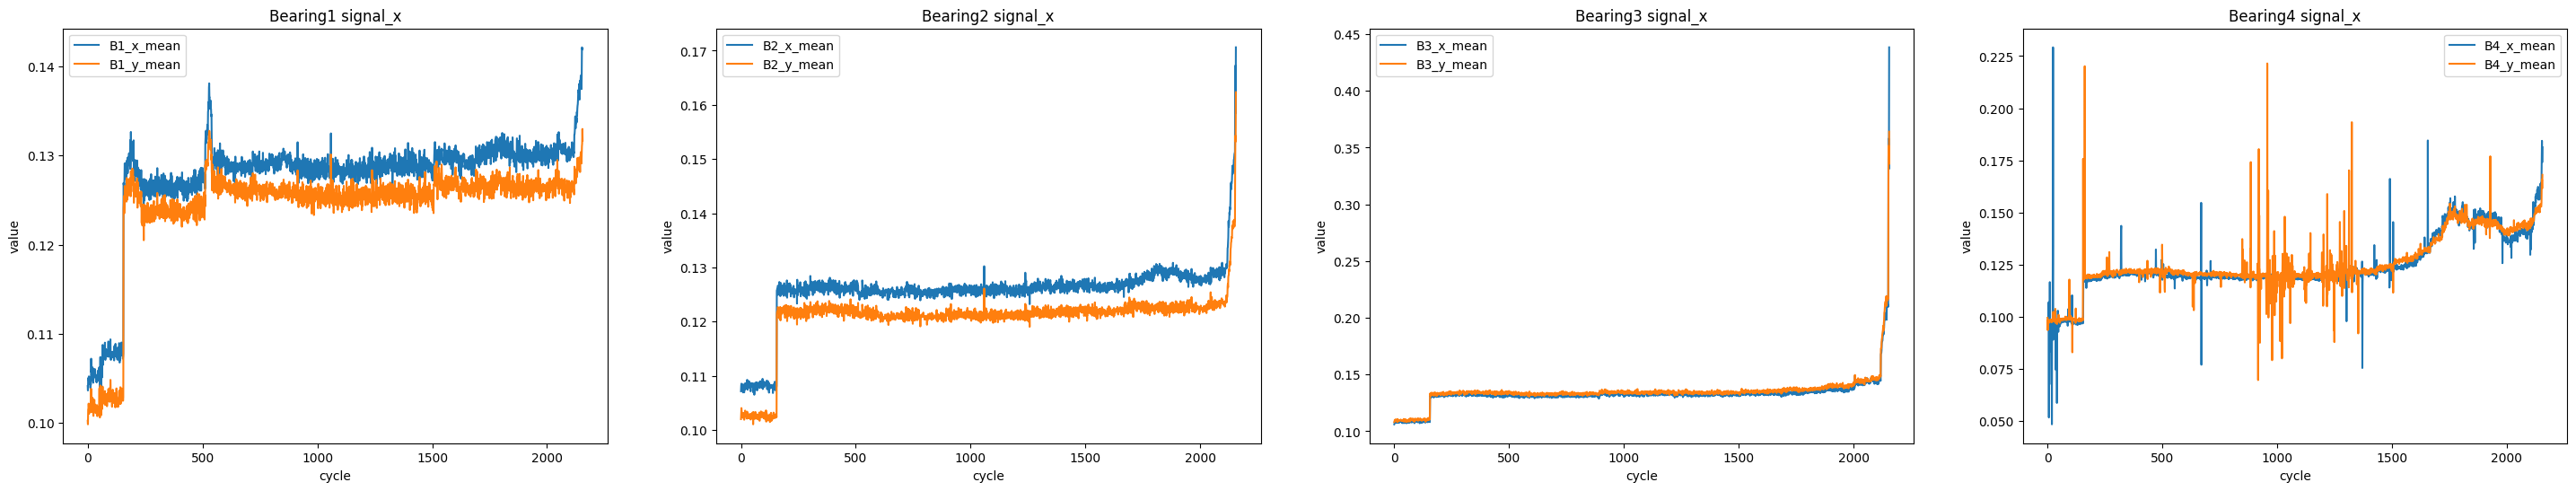

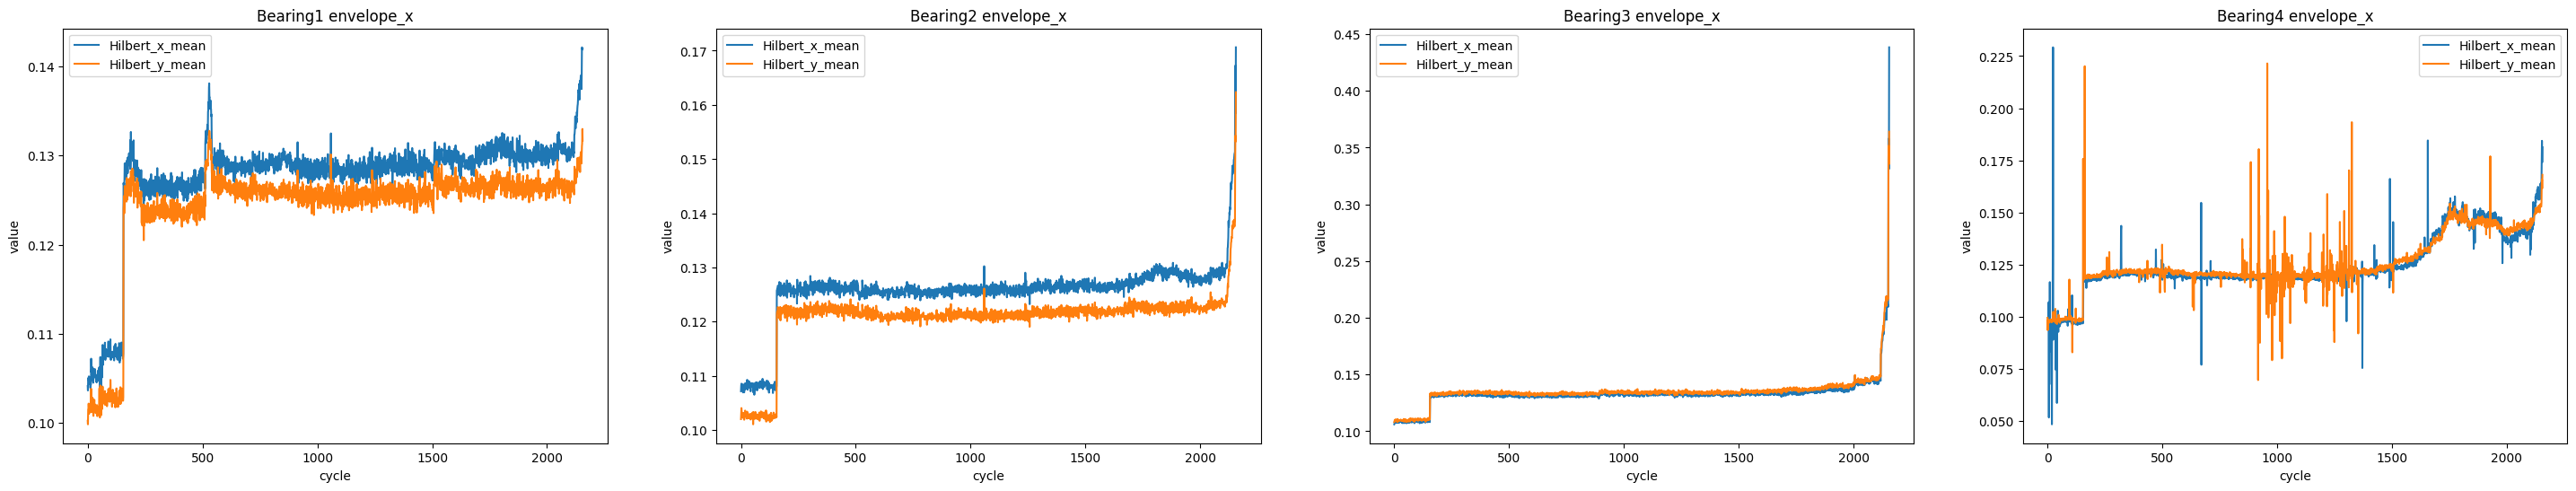

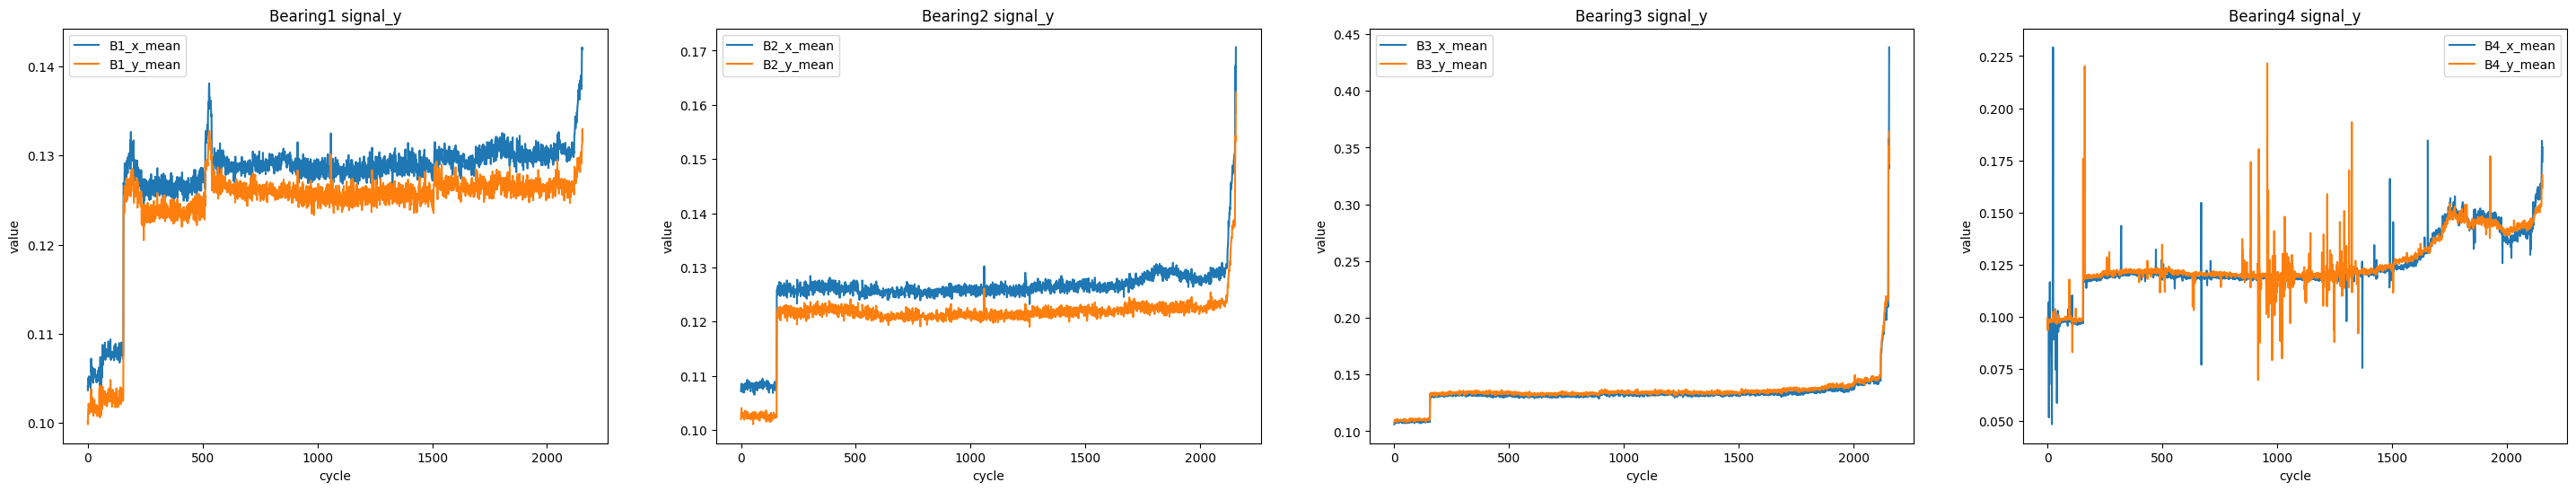

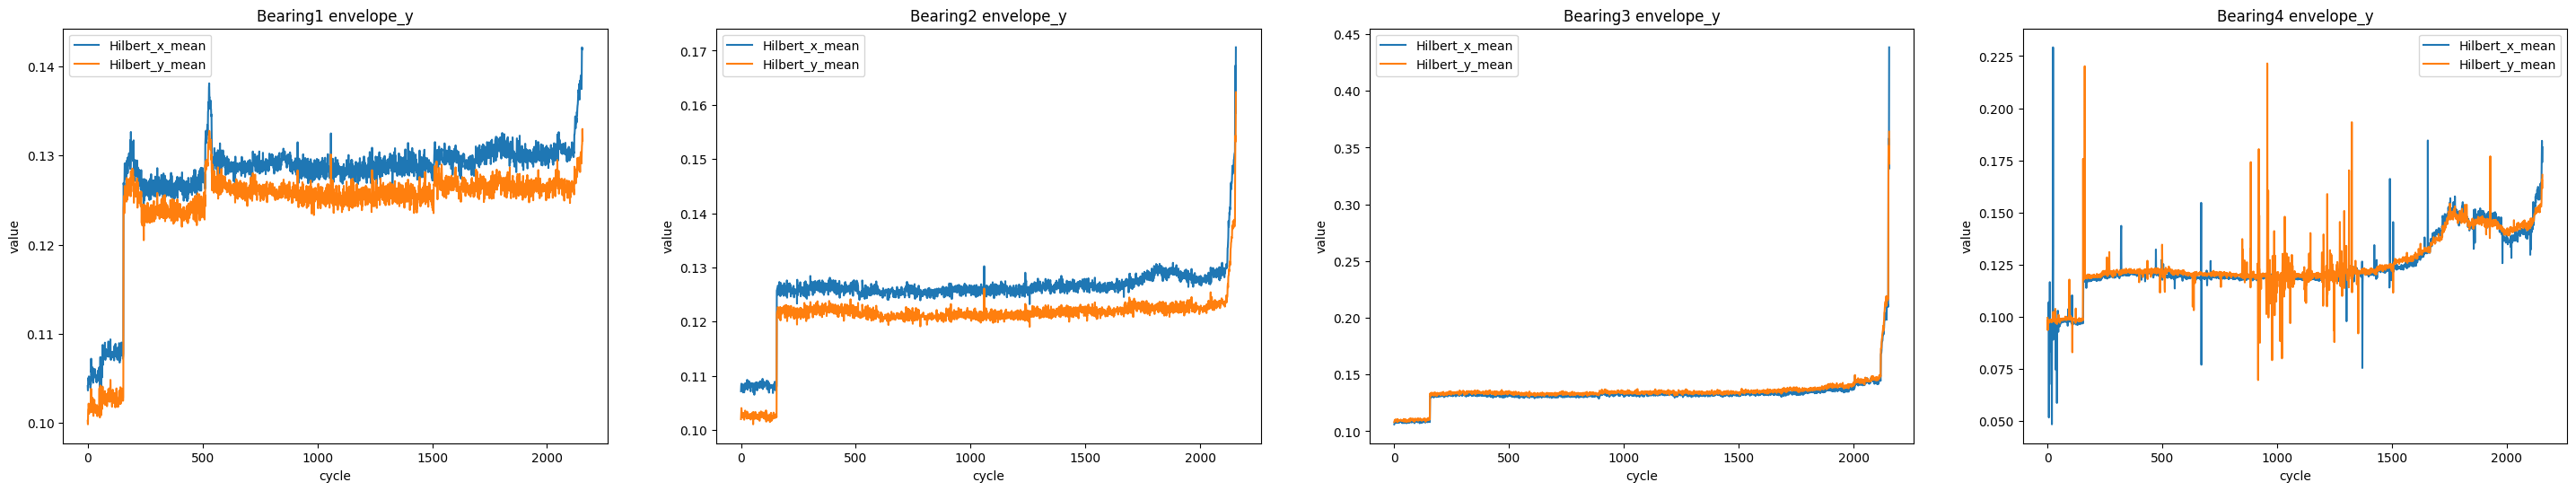

In [172]:
time_features_list = ["signal_x","envelope_x", "signal_y","envelope_y"]
bearings_xy = [["B"+str(n)+"_"+str(o)+"_" for n in range(1,5)] for o in ['x','y'] ] 
#print(bearings_xy)
for tf in time_features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(141)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(142)
    #...so on
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    axes = [ax1,ax2,ax3, ax4]
    
    if (tf== "signal_x" or tf== "signal_y"):
        for i in range(4):
            col = bearings_xy[0][i]+"mean"
            set1[col].plot(figsize = (36,6), title="Bearing{} ".format(i+1)+tf , legend = True, ax=axes[i])
            col = bearings_xy[1][i]+"mean"
            set1[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
            axes[i].set(xlabel="cycle", ylabel="value")
    else:
        for i in range(4):
            col = bearings_xy[0][i]+"mean"
            pd.DataFrame(hilbert(set1[col]).real, columns=['Hilbert_x_mean']).plot(figsize = (36,6), title="Bearing{} ".format(i+1)+tf , legend = True, ax=axes[i])
            col = bearings_xy[1][i]+"mean"
            pd.DataFrame(hilbert(set1[col]).real, columns=['Hilbert_y_mean']).plot(figsize = (36,6) , legend = True, ax=axes[i])
            axes[i].set(xlabel="cycle", ylabel="value") 

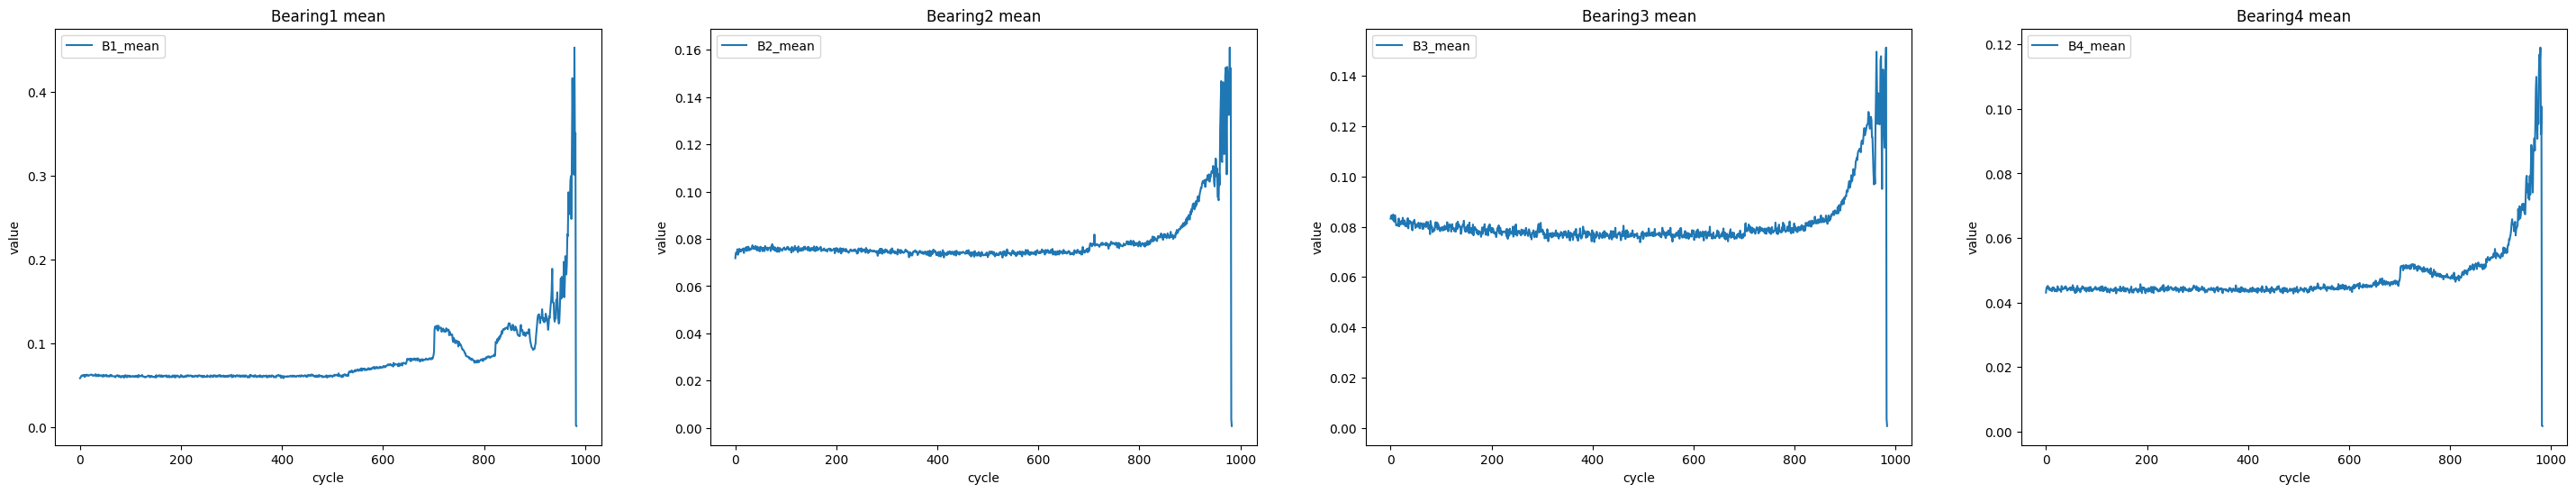

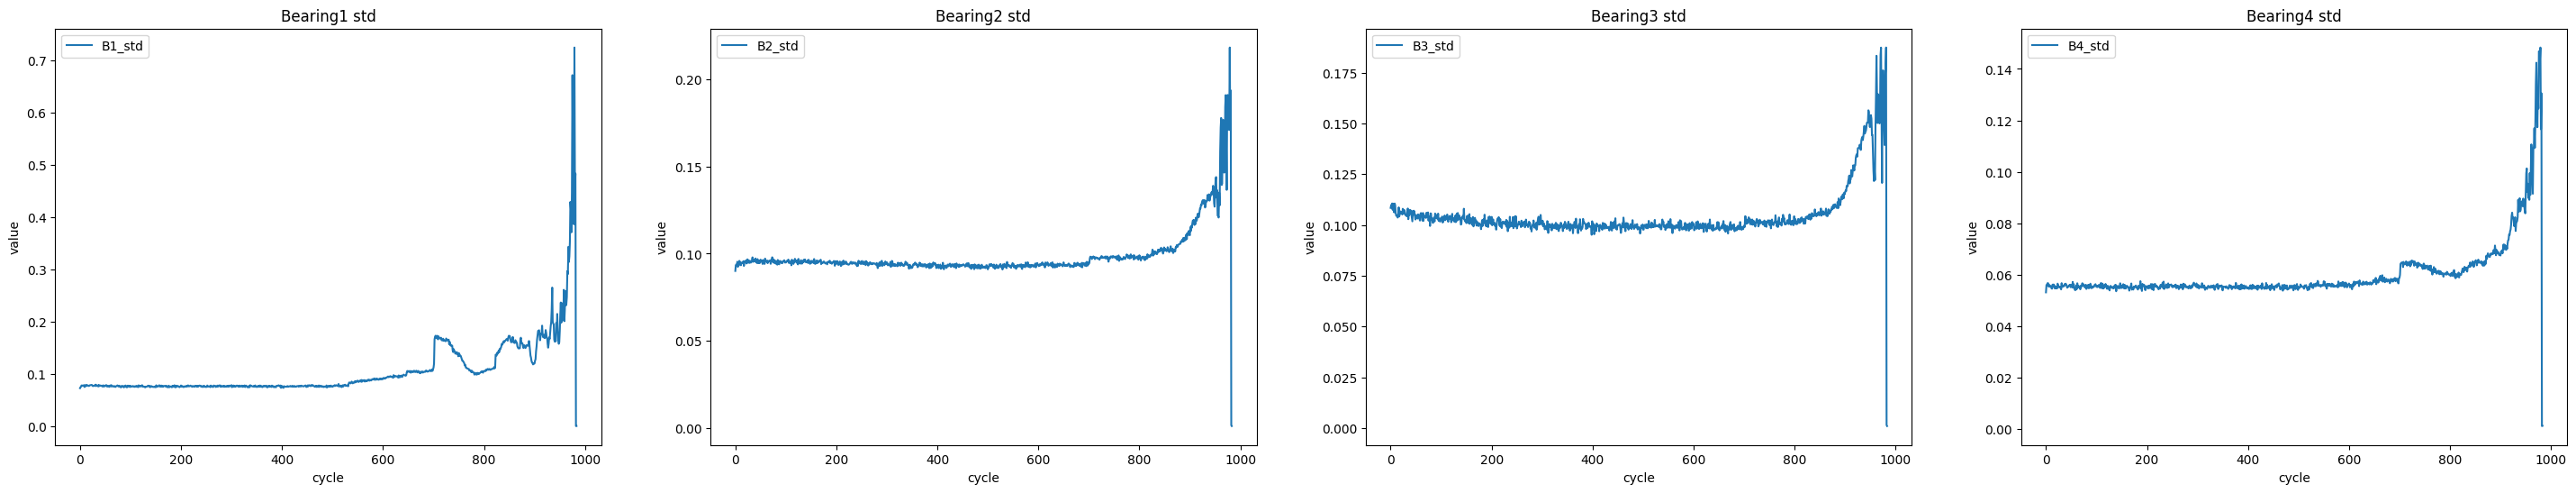

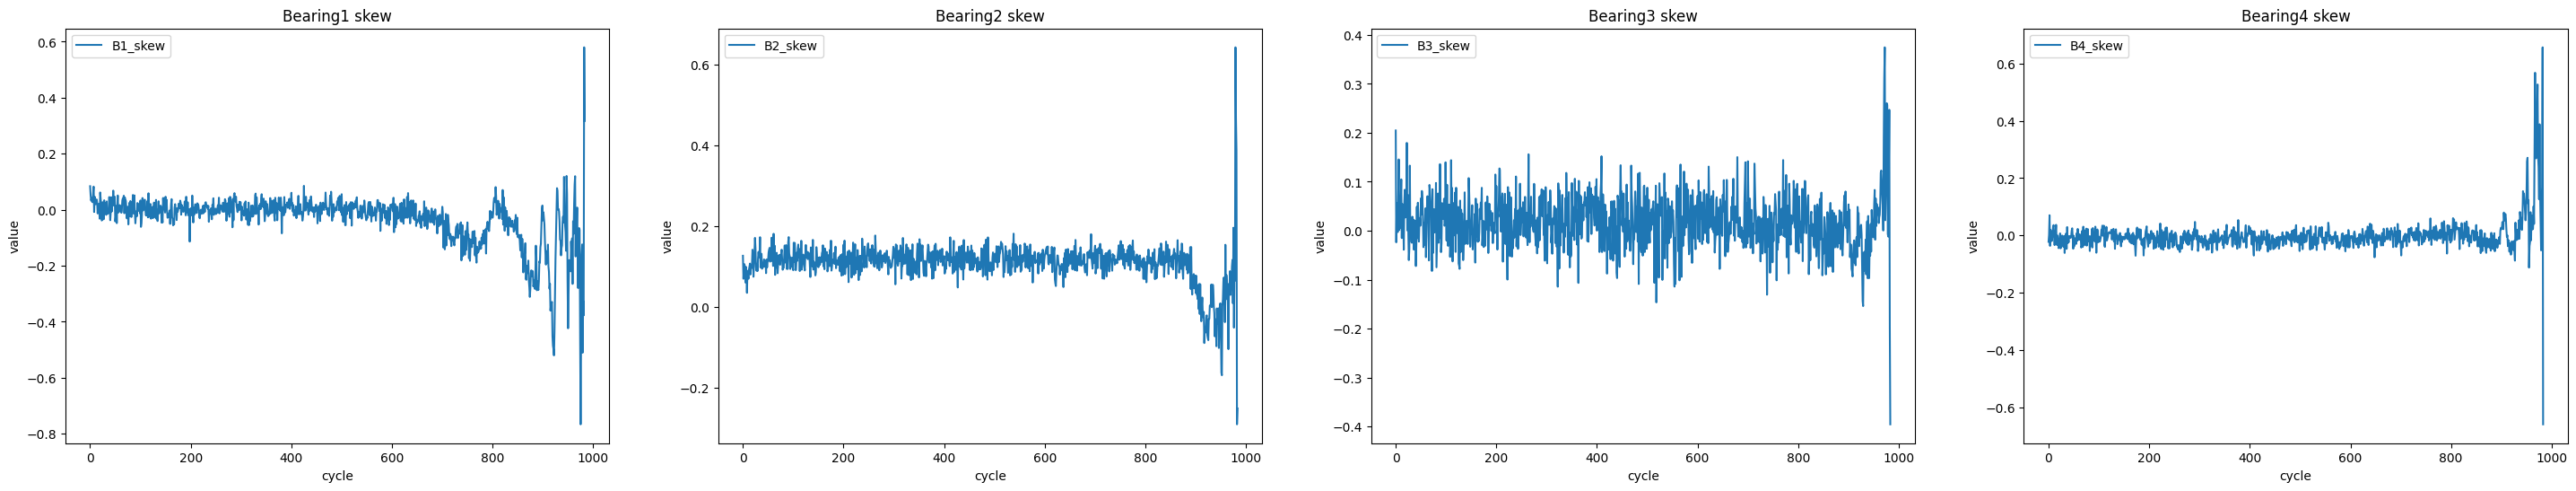

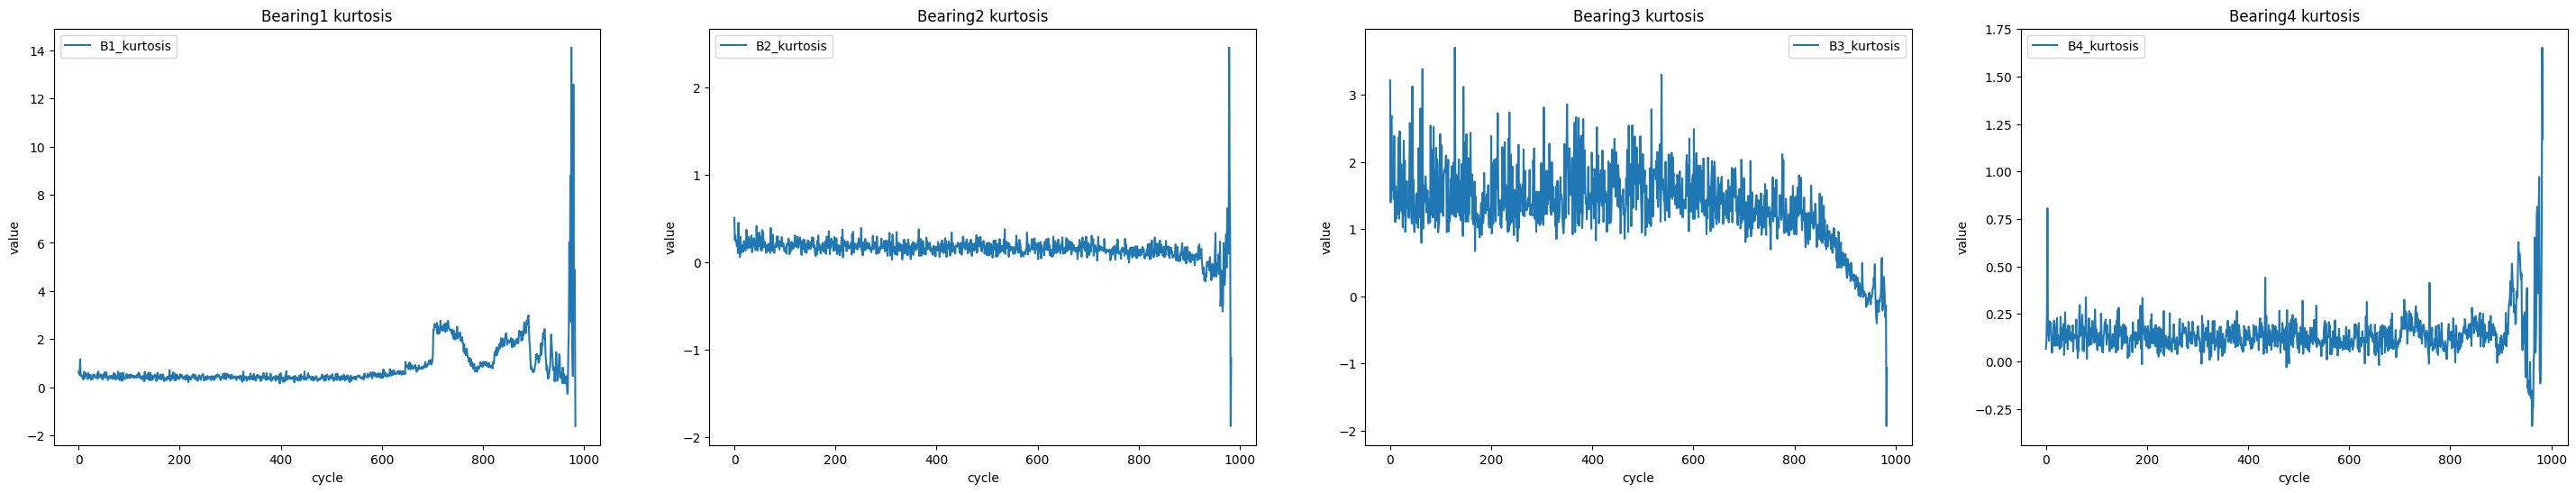

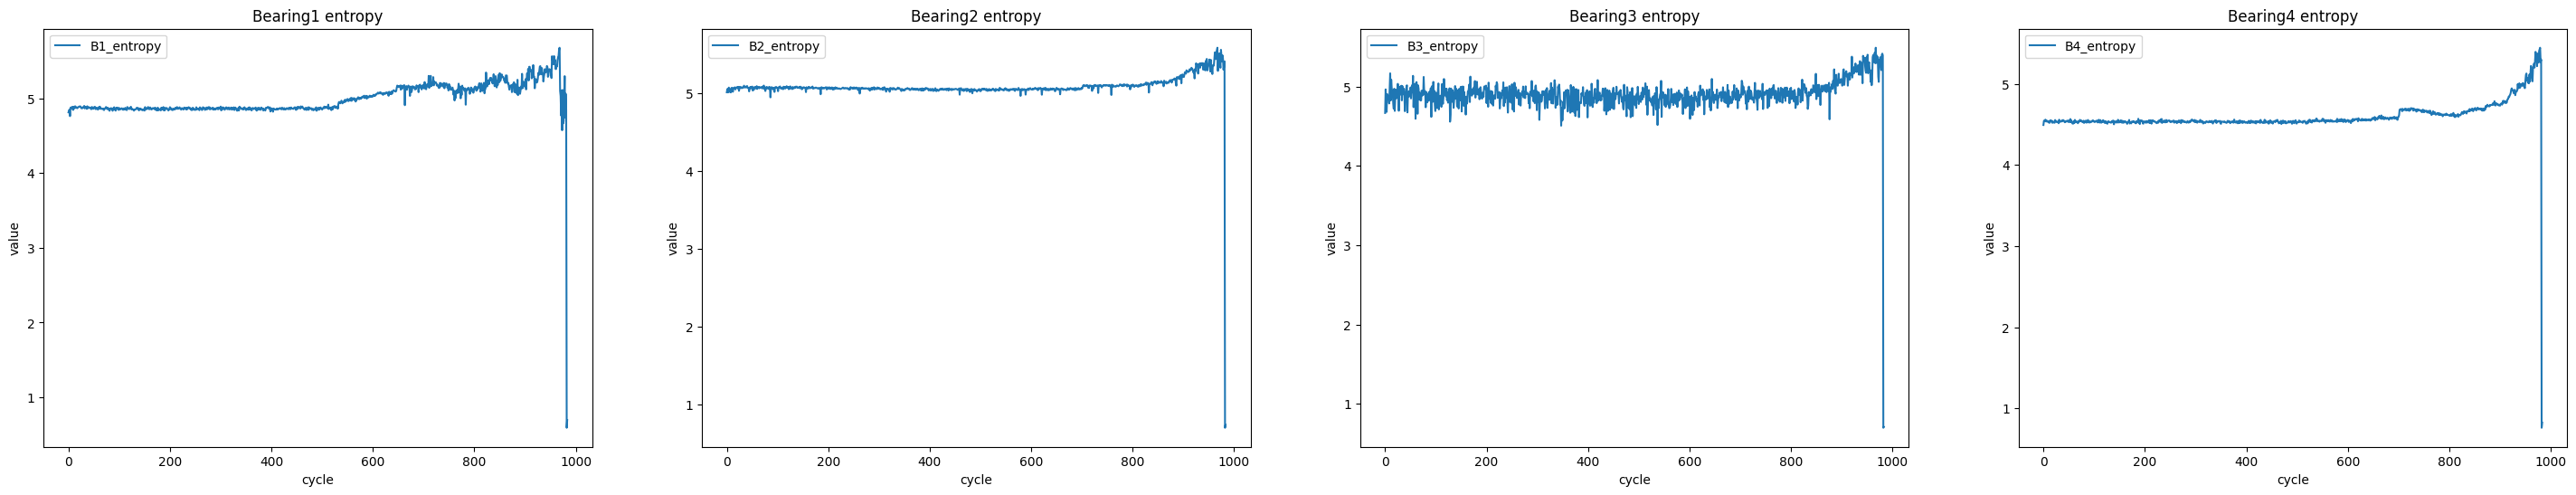

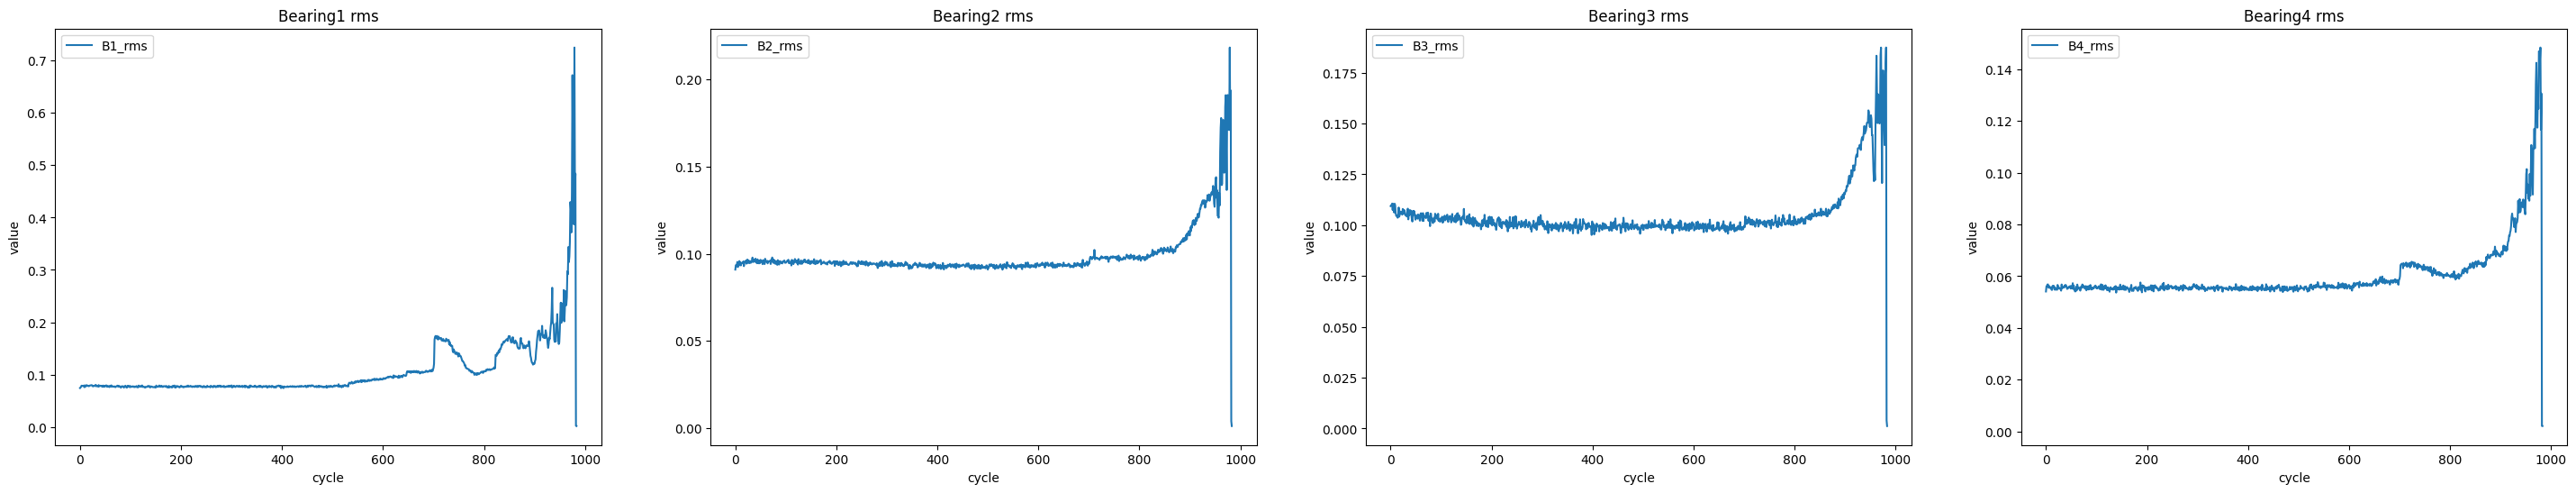

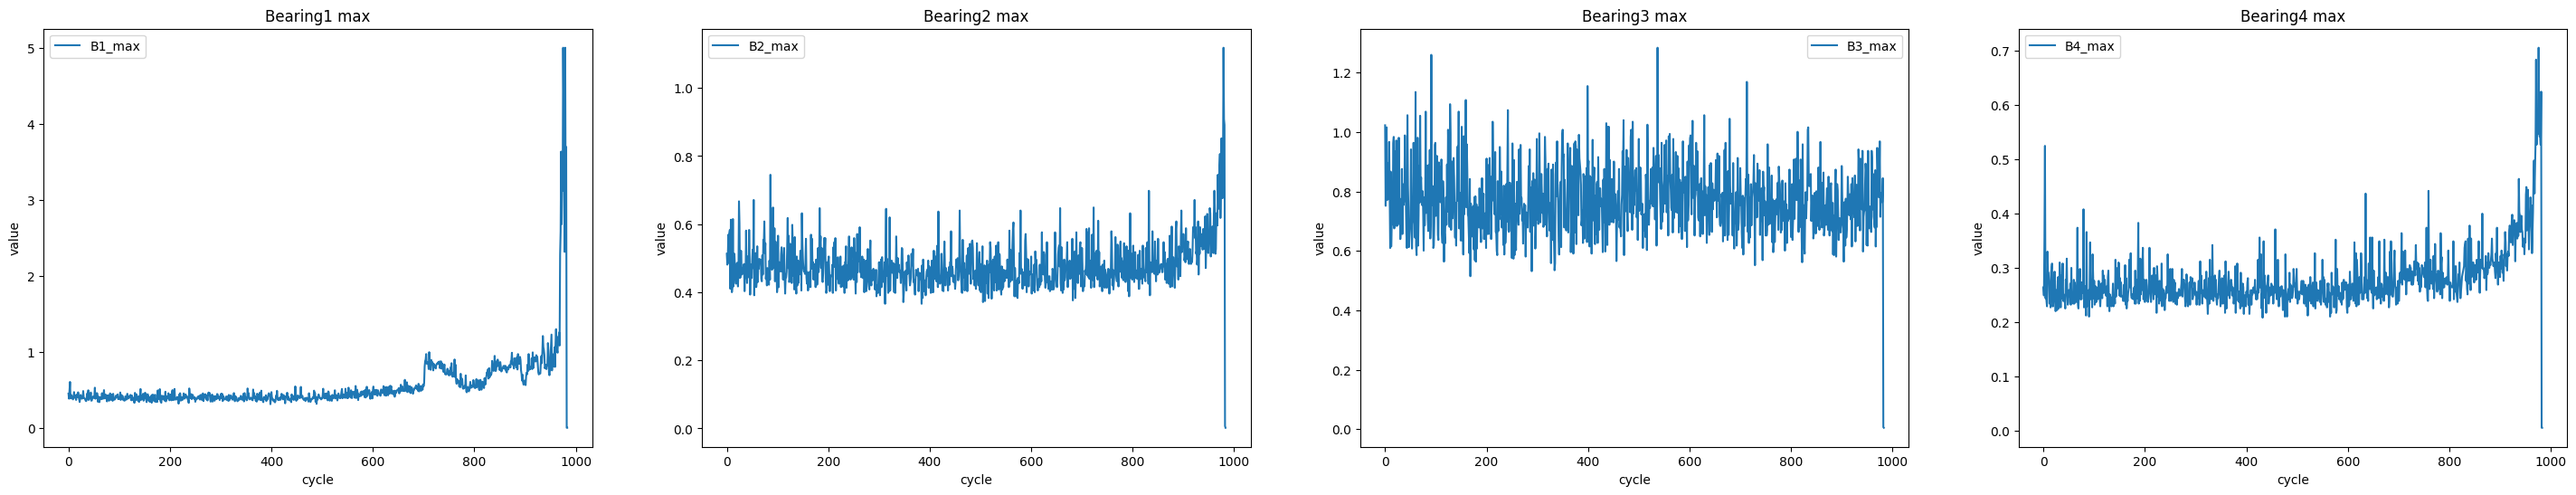

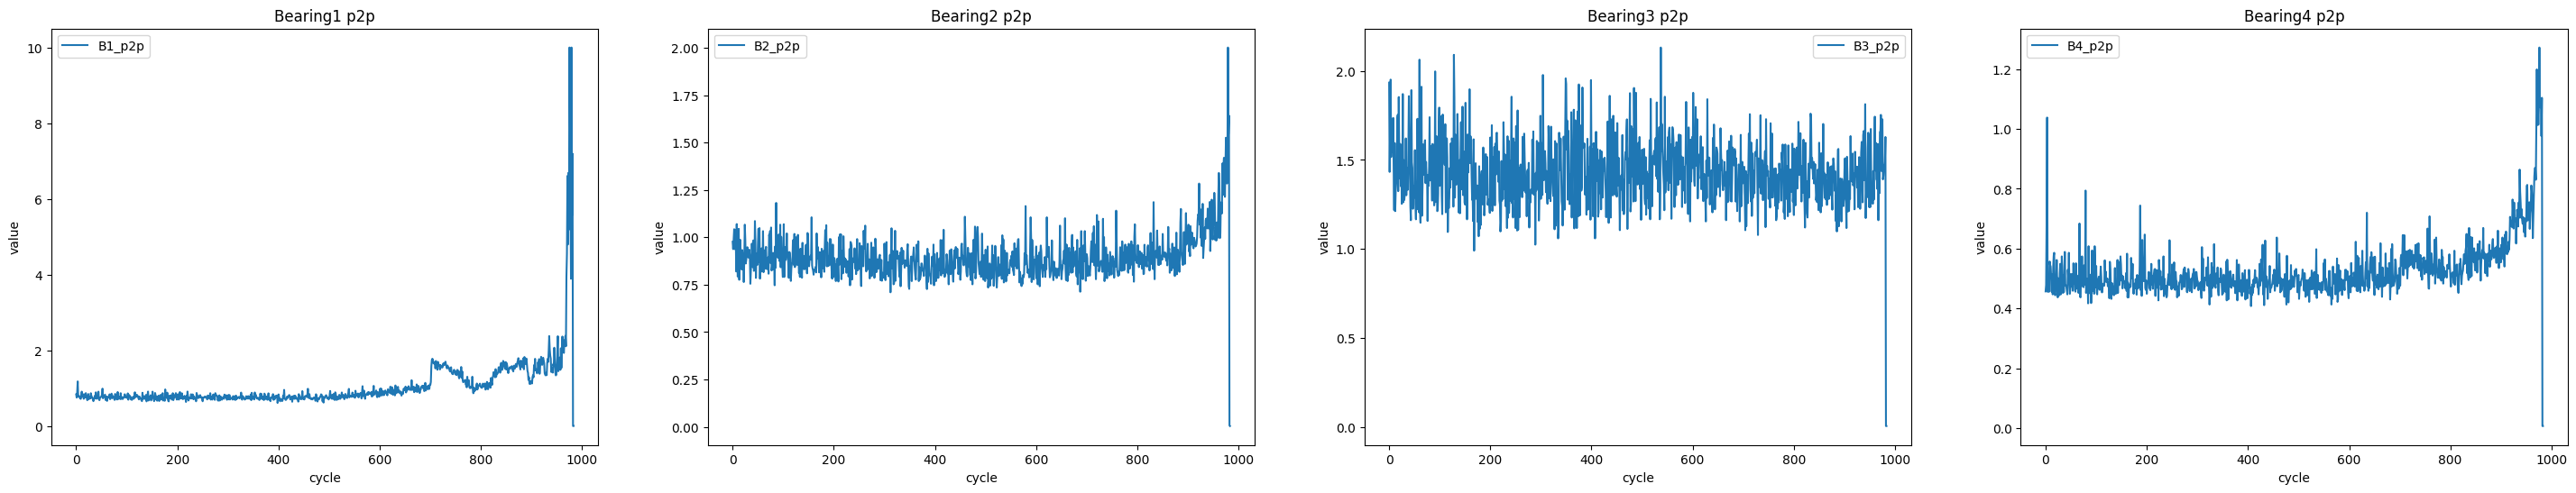

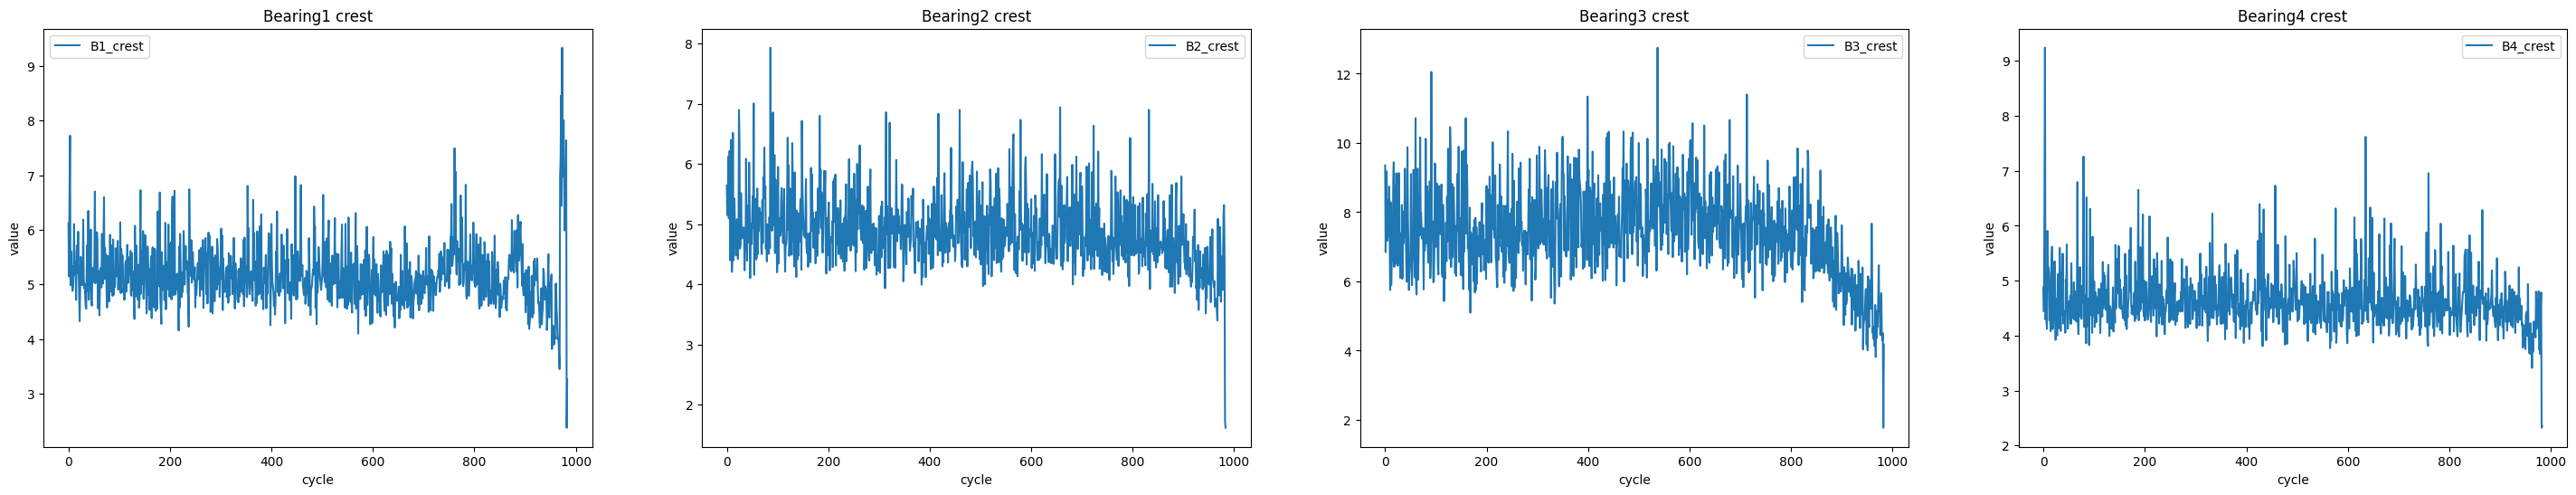

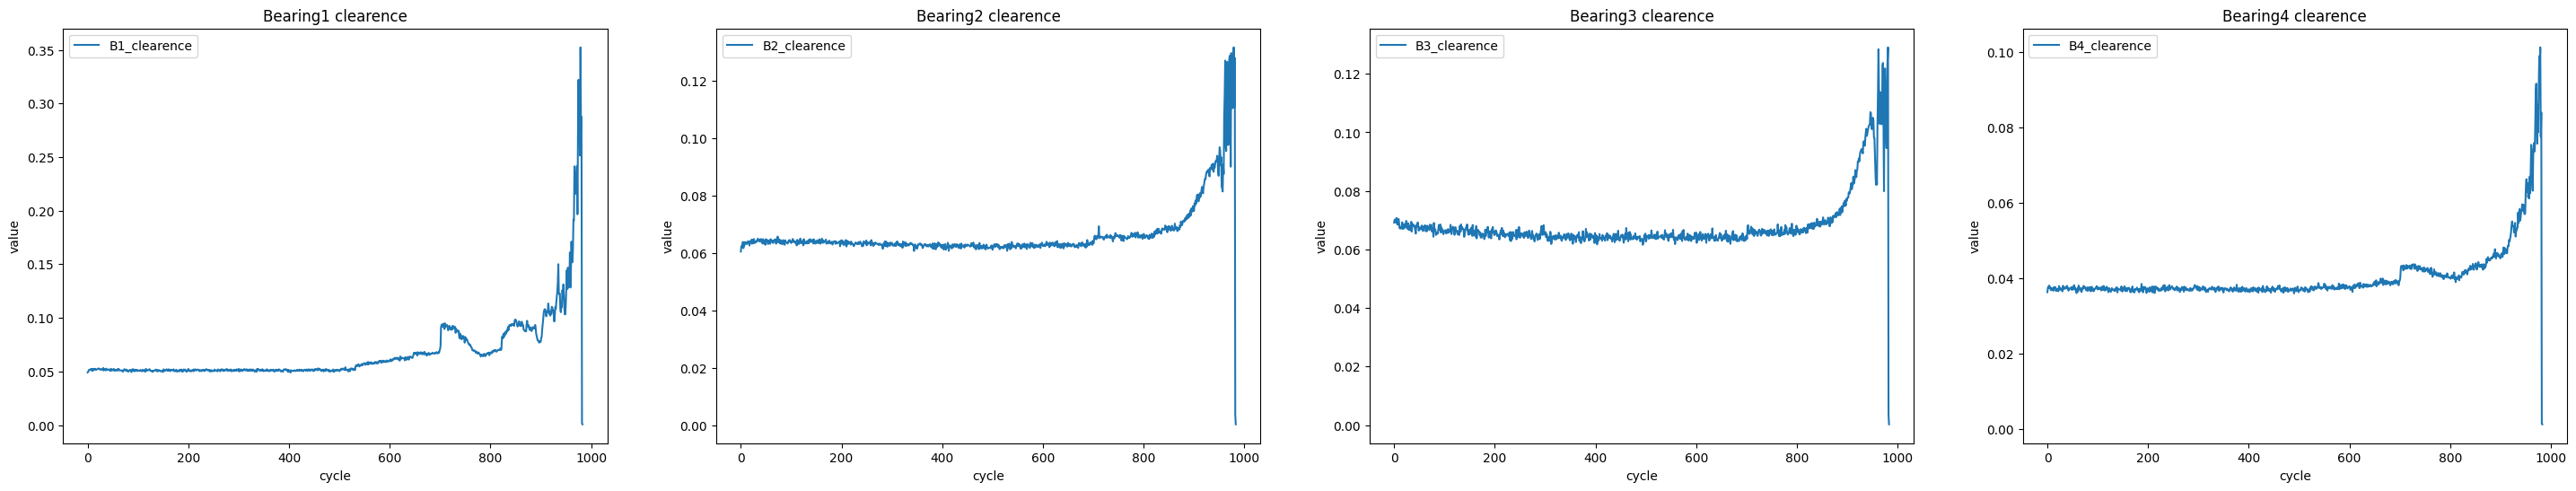

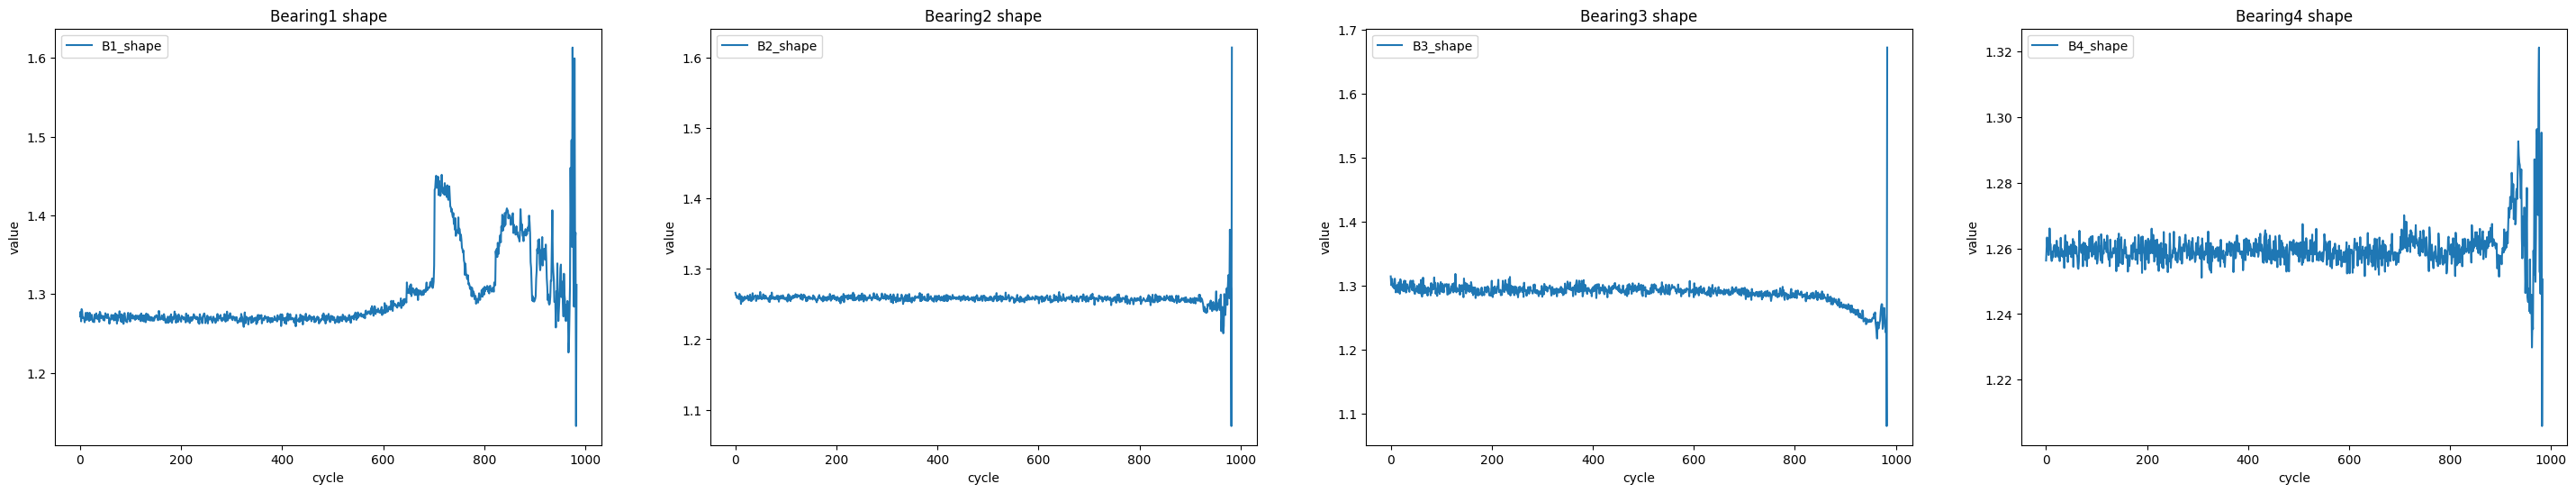

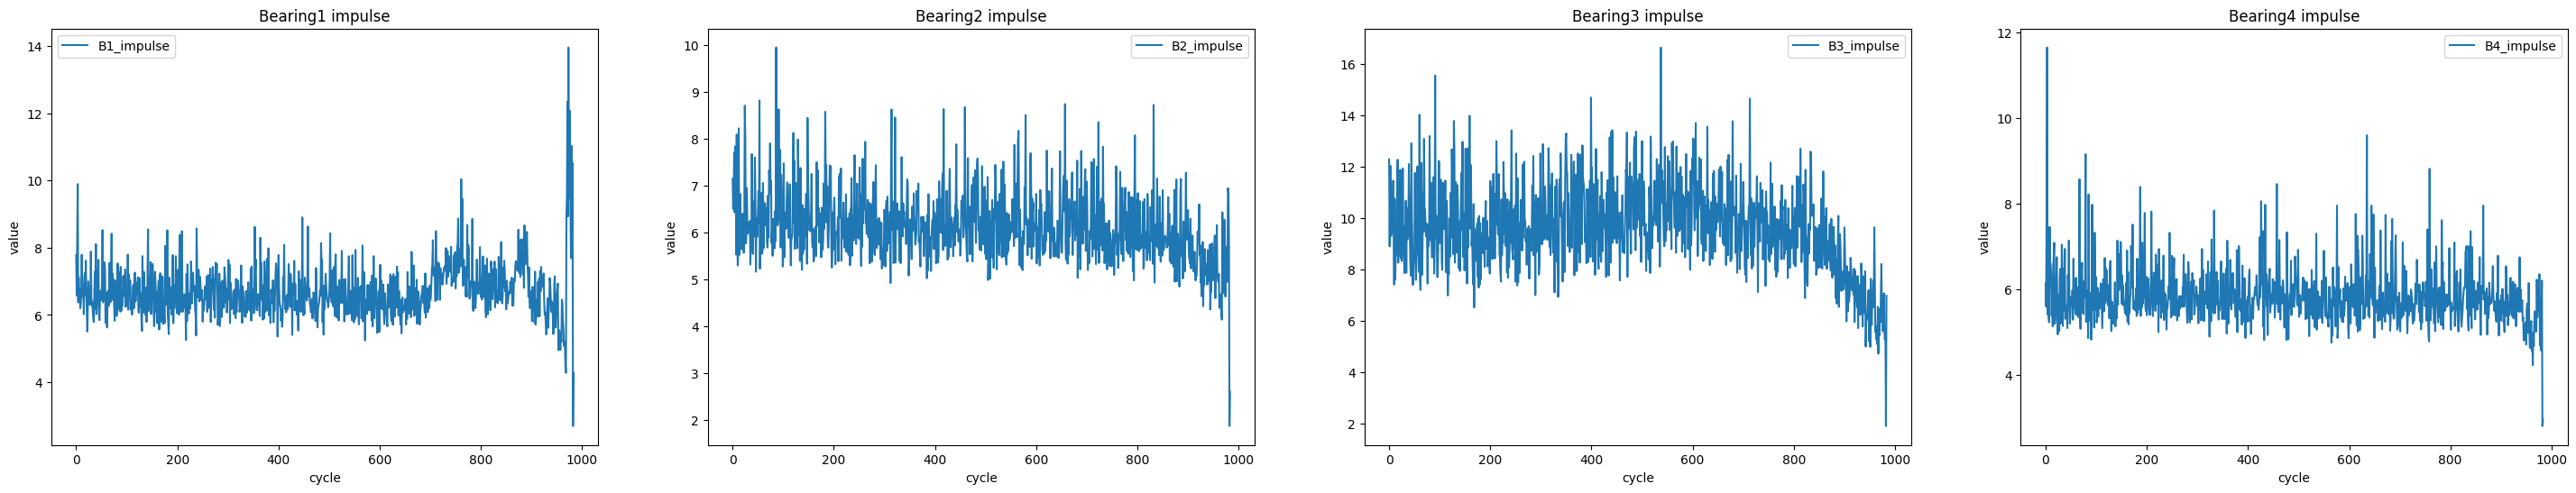

In [140]:
time_features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_xy = [["B"+str(n)+"_" for n in range(1,5)]] 
#print(bearings_xy)
for tf in time_features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(141)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(142)
    #...so on
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    axes = [ax1,ax2,ax3, ax4]
    
    for i in range(4):
        col = bearings_xy[0][i]+tf
        set2[col].plot(figsize = (36,6), title="Bearing{} ".format(i+1)+tf , legend = True, ax=axes[i])
#        col = bearings_xy[1][i]+tf
#        set2[col].plot(figsize = (36,6) , legend = True, ax=axes[i])
        axes[i].set(xlabel="cycle", ylabel="value")

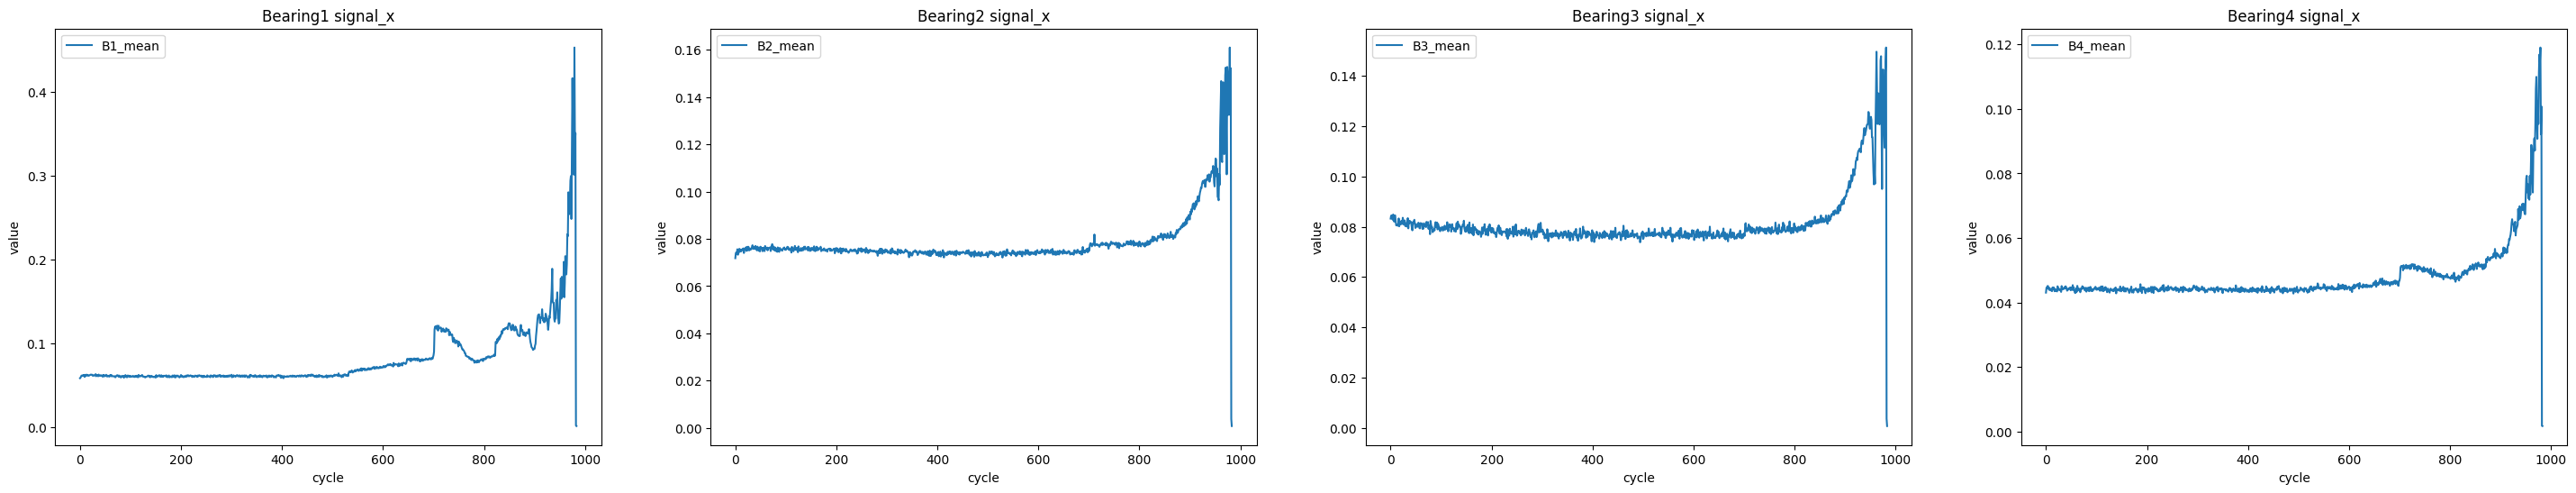

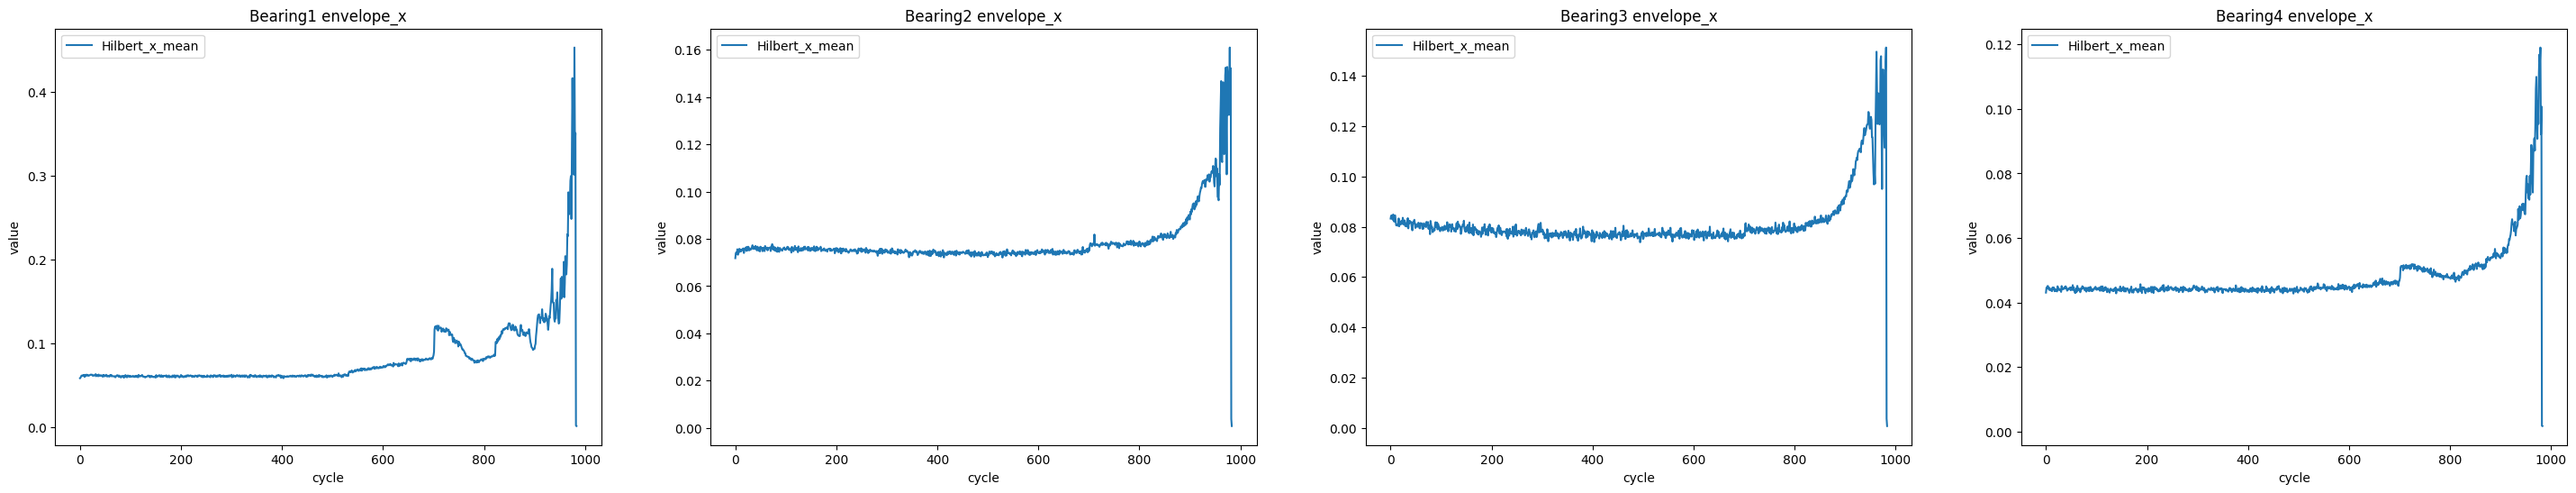

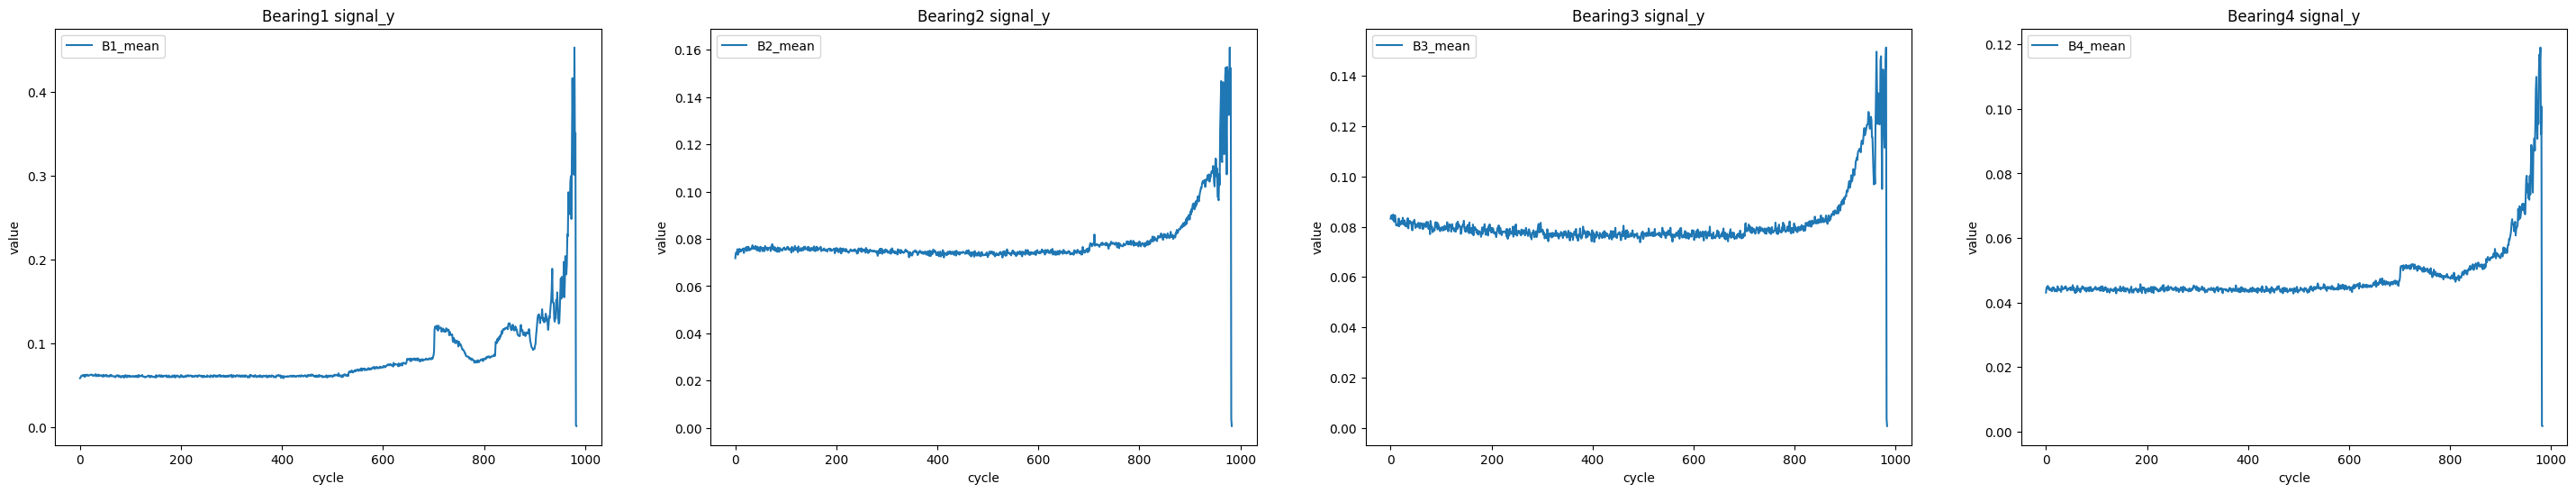

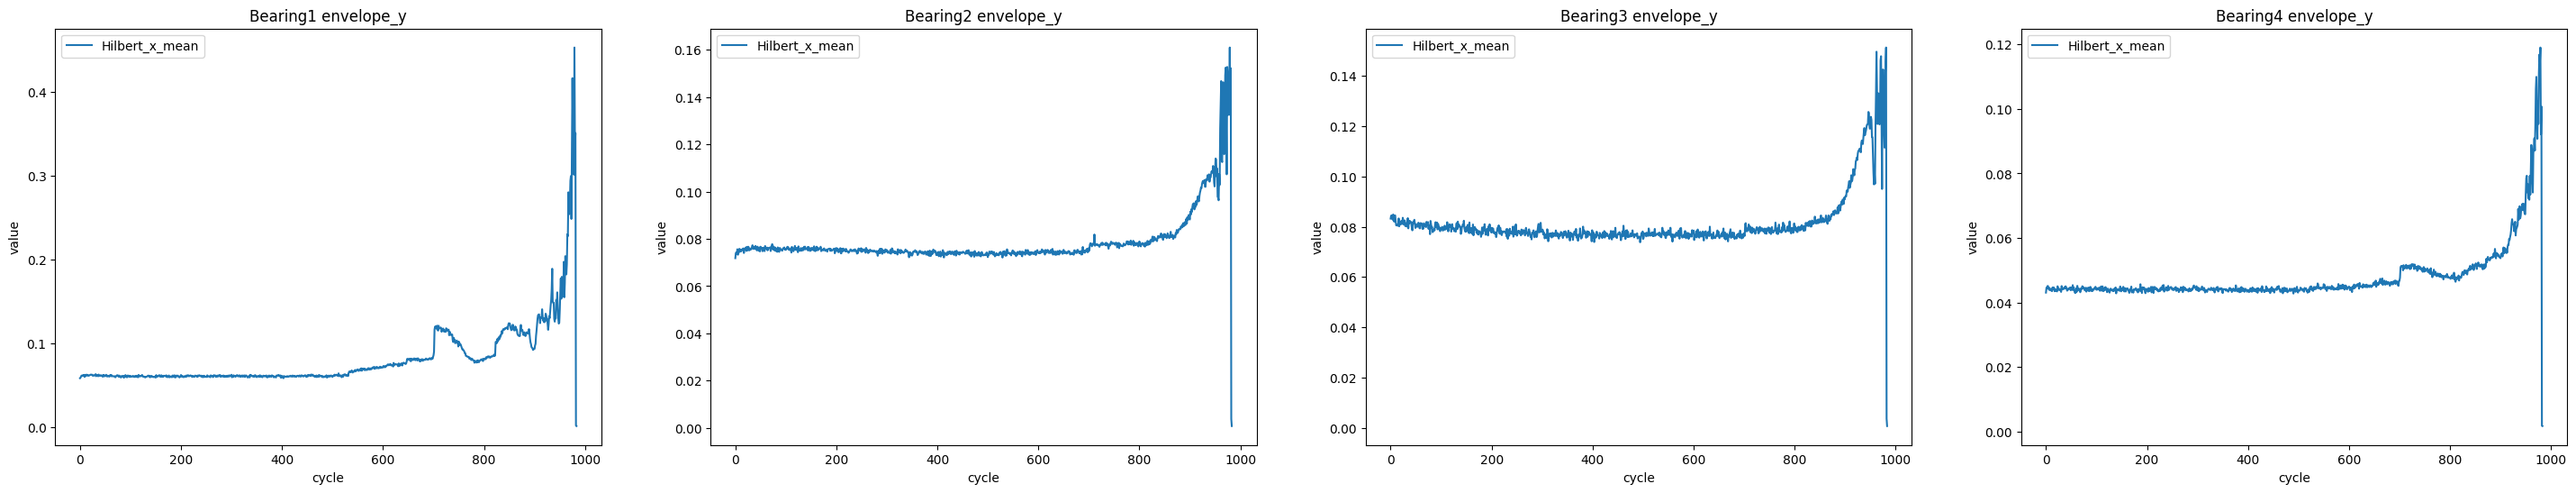

In [177]:
time_features_list = ["signal_x","envelope_x", "signal_y","envelope_y"]
bearings_xy = [["B"+str(n)+"_" for n in range(1,5)]] 
#print(bearings_xy)
for tf in time_features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(141)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(142)
    #...so on
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    axes = [ax1,ax2,ax3, ax4]
    
    if (tf== "signal_x" or tf== "signal_y"):
        for i in range(4):
            col = bearings_xy[0][i]+"mean"
            set2[col].plot(figsize = (36,6), title="Bearing{} ".format(i+1)+tf , legend = True, ax=axes[i])
            axes[i].set(xlabel="cycle", ylabel="value")
    else:
        for i in range(4):
            col = bearings_xy[0][i]+"mean"
            pd.DataFrame(hilbert(set2[col]).real, columns=['Hilbert_x_mean']).plot(figsize = (36,6), title="Bearing{} ".format(i+1)+tf , legend = True, ax=axes[i])
            axes[i].set(xlabel="cycle", ylabel="value") 

# Unsupervised

In [7]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
import tensorflow as tf
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv1D,MaxPooling1D,UpSampling1D,Conv1DTranspose,BatchNormalization,Lambda
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
label_dict = {
 0: 'Low',
 1: 'Medium',
 2: 'High',
}

In [146]:
batch_size = 64
epochs = 200
inChannel = 1
x = len(set1_fft)

train_data = set1_fft.reshape(-1, 1)
test_data = set2_fft.reshape(-1, 1)

train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2)

input_sig = Input(shape = (x, inChannel))
print (input_sig)
num_classes = 3

KerasTensor(type_spec=TensorSpec(shape=(None, 20479, 1), dtype=tf.float32, name='input_21'), name='input_21', description="created by layer 'input_21'")


In [132]:
def classifier_func(x):
    return x+x*K.one_hot(K.argmax(x, axis=1), num_classes= num_classes)

In [147]:
def encoder(input_sig, num_classes):

    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    #print(tf.shape(input_sig))
    conv1 = Conv1D(32, (3), activation='relu', padding='same',input_shape=(20479, 1))(input_sig) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv1D(32, (3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling1D(pool_size=(2), padding= 'same')(conv1) #14 x 14 x 32
    conv2 = Conv1D(64, (3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv1D(64, (3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling1D(pool_size= (2), padding='same')(conv2) #7 x 7 x 64
    conv3 = Conv1D(128, (3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv1D(128, (3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv1D(256, (3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv1D(256, (3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    den = Dense(128, activation='relu')(conv4)
    out = Dense(num_classes, activation='softmax')(den)
    return out

def decoder(out):    
    #decoder
    conv5 = Conv1D(128, (3), activation='relu', padding='same')(out) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv1D(128, (3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv1D(64, (3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv1D(64, (3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling1D((2))(conv6) #14 x 14 x 64
    conv7 = Conv1D(32, (3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv1D(32, (3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling1D((2))(conv7) # 28 x 28 x 32
    decoded = Conv1D(1, (3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [148]:
autoencoder = Model(input_sig, decoder(encoder(input_sig, num_classes)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [149]:
autoencoder.summary()
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 20479, 1)]        0         
                                                                 
 conv1d_499 (Conv1D)         (None, 20479, 32)         128       
                                                                 
 batch_normalization_468 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 conv1d_500 (Conv1D)         (None, 20479, 32)         3104      
                                                                 
 batch_normalization_469 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_78 (MaxPoolin  (None, 10240, 32)        0  

In [150]:
autoencoder.save_weights('models_autoencoder/autoencoder')

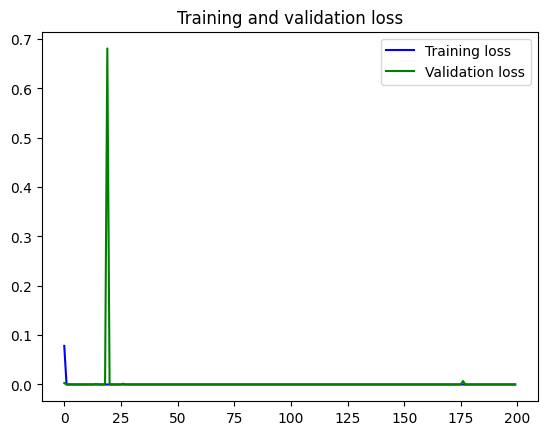

In [151]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, label='Training loss', color= "blue")
plt.plot(epochs, val_loss, label='Validation loss', color= "green")
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# # Change the labels from categorical to one-hot encoding
# train_Y_one_hot = to_categorical(train_labels)
# test_Y_one_hot = to_categorical(test_labels)

# # Display the change for category label using one-hot encoding
# print('Original label:', train_labels[0])
# print('After conversion to one-hot:', train_Y_one_hot[0])

In [110]:
# train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_data,test_size=0.2,random_state=13)

In [111]:
# def fc(enco):
#     flat = Flatten()(enco)
#     den = Dense(128, activation='relu')(flat)
#     out = Dense(num_classes, activation='softmax')(den)
#     return out

In [152]:
encode = encoder(input_sig, num_classes)
full_model = Model(input_sig,encode)
full_model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 20479, 1)]        0         
                                                                 
 conv1d_514 (Conv1D)         (None, 20479, 32)         128       
                                                                 
 batch_normalization_482 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 conv1d_515 (Conv1D)         (None, 20479, 32)         3104      
                                                                 
 batch_normalization_483 (Ba  (None, 20479, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling1d_80 (MaxPoolin  (None, 10240, 32)        0  

In [155]:
encode = full_model.predict(train_X)

print(label_dict)
    
neuron_class = np.zeros((num_classes))
for i in range(num_classes):
    neuron_class[i] = np.argmax(label_dict[i], axis=0)

print(neuron_class)

encode = full_model.predict(valid_X)

print (encode)

predicted = np.argmax(encode, axis=1)
for i, sample in enumerate(predicted):
    predicted[i] = neuron_class[predicted[i]]
print(neuron_class)

512/512 [==============================] - 2s 4ms/step
{0: 'Low', 1: 'Medium', 2: 'High'}
[0. 0. 0.]
128/128 [==============================] - 1s 4ms/step
[[[0.33333334 0.33333337 0.33333334]]

 [[0.33333334 0.33333337 0.33333334]]

 [[0.3333333  0.33333334 0.3333333 ]]

 ...

 [[0.33333334 0.33333337 0.33333334]]

 [[0.33333334 0.33333337 0.33333334]]

 [[0.3333333  0.33333334 0.3333333 ]]]
[0. 0. 0.]


# Supervised statistic

In [56]:
import scipy.stats as st
import statsmodels.stats.weightstats as stat

In [25]:
size = 10000
names, xlabels, frozen_rvs, samples = [], [], [], []
pd.options.display.max_columns = 6

# Extract names and sane parameters of all scipy probability distributions
# (except the deprecated ones) and loop through them to create lists of names,
# frozen random variables, samples of random variates and x labels
for name, params in st._distr_params.distcont:
    if name in ['alpha', 'argus']:
        loc, scale = 0, 1
        names.append(name)
        params = list(params) + [loc, scale]
        
        # Create instance of random variable
        dist = getattr(st, name)
        
        # Create frozen random variable using parameters and add it to the list
        # to be used to draw the probability density functions
        rv = dist(*params)
        frozen_rvs.append(rv)
        
        # Create sample of random variates
        samples.append(rv.rvs(size=size))
        
        # Create x label containing the distribution parameters
        p_names = ['loc', 'scale']
        if dist.shapes:
            p_names = [sh.strip() for sh in dist.shapes.split(',')] + ['loc', 'scale']
        xlabels.append(', '.join([f'{pn}={pv:.2f}' for pn, pv in zip(p_names, params)]))

# Create pandas dataframe containing all the samples
df = pd.DataFrame(data=np.array(samples).T, columns=[name for name in names])
# Rename the duplicate column names by adding a period and an integer at the end
df.columns = pd.io.parsers.base_parser.ParserBase({'usecols': None})._maybe_dedup_names(df.columns)

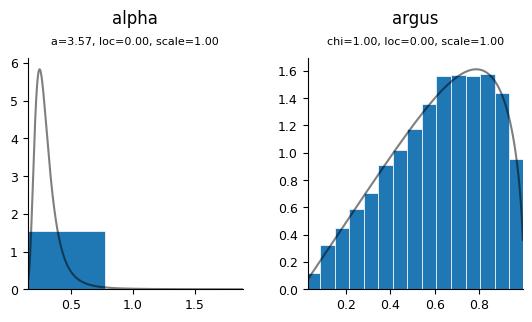

In [26]:
# Set parameters for figure dimensions
nplot = df.columns.size
cols = 3
rows = int(np.ceil(nplot/cols))
subp_w = 10/cols  # 10 corresponds to the figure width in inches
subp_h = 0.9*subp_w

# Create pandas grid of histograms
axs = df.hist(density=True, bins=15, grid=False, edgecolor='w',
              linewidth=0.5, legend=False,
              layout=(rows, cols), figsize=(cols*subp_w, rows*subp_h))

# Loop over subplots to draw probability density function and apply some
# additional formatting
for idx, ax in enumerate(axs.flat[:df.columns.size]):
    rv = frozen_rvs[idx]
    x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), size)
    ax.plot(x, rv.pdf(x), c='black', alpha=0.5)
    ax.set_title(ax.get_title(), pad=25)
    ax.set_xlim(x.min(), x.max())
    ax.set_xlabel(xlabels[idx], fontsize=8, labelpad=10)
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis='both', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax.figure.subplots_adjust(hspace=0.8, wspace=0.3)

In [11]:
def get_best_distribution(data):
    dist_results = []
    params = {}
    bins= len(data)
    dist_names_examples = ['alpha', 'anglit', 'arcsine']
    for dist_name, par in st._distr_params.distcont:                          #st._distr_params.distcont:

        if dist_name not in ['kstwo', 'levy_stable', 'studentized_range']:
            dist = getattr(st, dist_name)
            print (dist_name)
            param = dist.fit(data)

            arg = param[:-2]
            loc = param[-2]
            scale = param[-1]

            params[dist_name] = param
            # Applying the Kolmogorov-Smirnov test
            # D, p = st.kstest(data, dist_name, args=param)
            y, x = np.histogram(data, bins= bins, density=True)
            x = (x + np.roll(x, -1))[:-1] / 2.0
            pdf = dist.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y - pdf, 2.0))
            print("sse value for "+dist_name+" = "+str(sse))
            dist_results.append((dist_name, sse))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

x,y,z = get_best_distribution(set1_fft.tolist())

alpha
sse value for alpha = 2446906.35944487
anglit
sse value for anglit = 109822194.01584758
arcsine
sse value for arcsine = 101628718.93237099
argus
sse value for argus = 109390772.72644198
beta
sse value for beta = 26821590.8702119
betaprime
sse value for betaprime = 116180415.57331362
bradford
sse value for bradford = 108238939.43932669
burr
sse value for burr = 19067973.074701983
burr12
sse value for burr12 = 3663470.808614075
cauchy
sse value for cauchy = 16669799.996412214
chi
sse value for chi = 63768972.5528203
chi2
sse value for chi2 = 7606669.320707359
cosine
sse value for cosine = 109822194.01584758
crystalball
sse value for crystalball = 68924767.71482198
dgamma
sse value for dgamma = 19024722.797220785
dweibull
sse value for dweibull = 18944081.122129153
erlang
sse value for erlang = 113263839.25889613
expon
sse value for expon = 15526017.343885895
exponnorm
sse value for exponnorm = 1850769.619330854
exponpow
sse value for exponpow = 85550019.47599865
exponweib
sse value

c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\stats\_continuous_distns.py:5565: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


sse value for loglaplace = 100725817.44962892
lognorm
sse value for lognorm = 1838086.4400764913
loguniform
sse value for loguniform = 234385838.976627
lomax
sse value for lomax = 23571924.62704052
maxwell
sse value for maxwell = 54971892.38825425
mielke
sse value for mielke = 240182208.23476177
moyal
sse value for moyal = 8949017.264637815
nakagami
sse value for nakagami = 64638647.951227866
ncf


c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\stats\_continuous_distns.py:6627: RuntimeWarning: divide by zero encountered in _ncf_pdf
  return _boost._ncf_pdf(x, dfn, dfd, nc)


sse value for ncf = 108137644.22721513
nct
sse value for nct = 4774761.848078533
ncx2
sse value for ncx2 = 7491141.239414955
norm
sse value for norm = 67117976.88337353
norminvgauss
sse value for norminvgauss = 1494140.2394340301
pareto
sse value for pareto = 16548941.2472569
pearson3
sse value for pearson3 = 4548365.017227407
pearson3
sse value for pearson3 = 4548365.017227407
powerlaw
sse value for powerlaw = 116201688.71069385
powerlaw
sse value for powerlaw = 116201688.71069385
powerlognorm
sse value for powerlognorm = 1894360.4201484346
powernorm


c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\stats\_continuous_distns.py:7598: RuntimeWarning: divide by zero encountered in power
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\stats\_continuous_distns.py:7598: RuntimeWarning: invalid value encountered in multiply
  return c*_norm_pdf(x) * (_norm_cdf(-x)**(c-1.0))


sse value for powernorm = nan
rayleigh
sse value for rayleigh = 53956076.23280147
rdist
sse value for rdist = 109822194.01584758
recipinvgauss
sse value for recipinvgauss = 1739892.0923004218
reciprocal
sse value for reciprocal = 234385838.976627
rice
sse value for rice = 22251323.10596317
semicircular
sse value for semicircular = 109822194.01584758
skewcauchy
sse value for skewcauchy = 4529238.315813539
skewnorm
sse value for skewnorm = 10150732.520858599
studentized_range


c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_ma

KeyboardInterrupt: 

In [15]:
set1_good= set1 [["B1_x_freq_band_0", "B1_x_freq_band_1", "B2_x_freq_band_2", "B1_x_freq_band_3", "B2_x_freq_band_4", "B1_x_freq_band_5", "B2_x_freq_band_6",
                   "B1_x_freq_band_7", "B2_x_freq_band_8", "B1_x_freq_band_9", "B2_x_freq_band_10", "B1_x_freq_band_11"]]
set1_good= set1_good.iloc[0:400,:]

set1_bad= set1 [["B1_x_freq_band_0", "B1_x_freq_band_1", "B2_x_freq_band_2", "B1_x_freq_band_3", "B2_x_freq_band_4", "B1_x_freq_band_5", "B2_x_freq_band_6",
                   "B1_x_freq_band_7", "B2_x_freq_band_8", "B1_x_freq_band_9", "B2_x_freq_band_10", "B1_x_freq_band_11"]]
set1_bad= set1_bad.iloc[-400:,:]

print (len(set1_good))

400


C:\Users\User\AppData\Local\Temp\ipykernel_11428\688980029.py:14: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(freq, fft_x_g, 'b', markerfmt=" ", basefmt="-b")


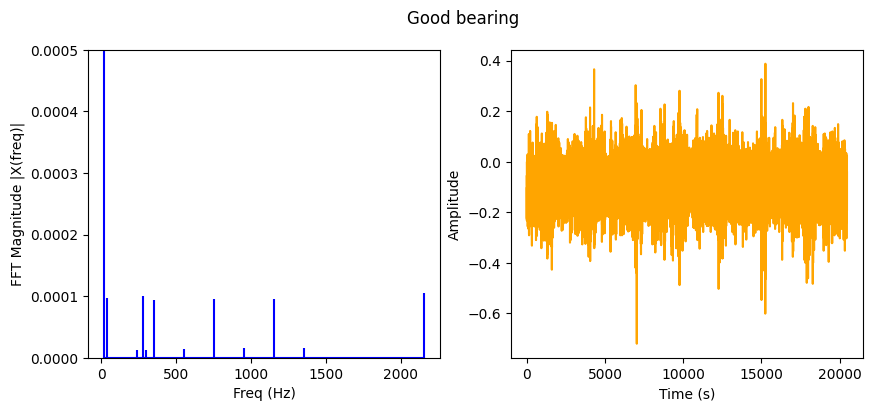

C:\Users\User\AppData\Local\Temp\ipykernel_11428\688980029.py:39: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(freq, fft_x_b, 'b', markerfmt=" ", basefmt="-b")


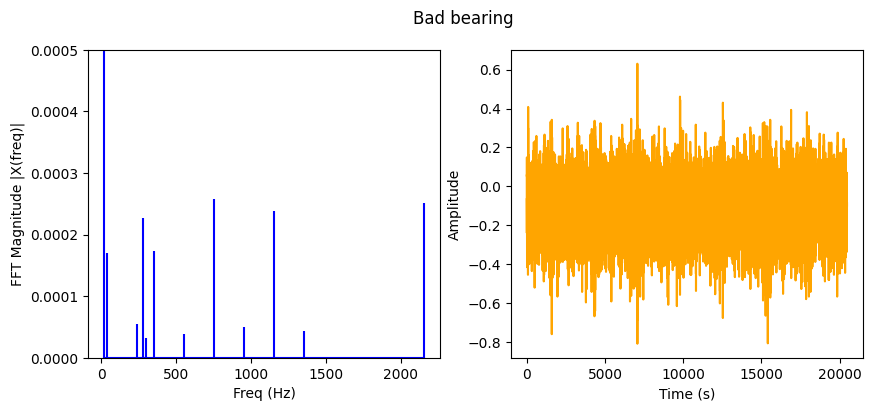

In [57]:
raw_data_g = pd.read_csv(os.path.join(dataset_path_1st, "2003.10.22.12.06.24"), sep='\t')

fft_x_g= set1_good.iloc[0:1,:].values
fft_x_g = np.squeeze(fft_x_g)

freq= [17, 36, 234, 276, 295, 350, 550, 750, 950, 1150, 1350, len(set1)]

ts = len(np.squeeze(raw_data_g.iloc[:,0:1].values))
t = np.arange(0,ts,1)

plt.figure(figsize = (10, 4))
plt.subplot(121)

plt.stem(freq, fft_x_g, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Magnitude |X(freq)|')
plt.ylim(0, 0.0005)

plt.subplot(122)
plt.plot(t, np.squeeze(raw_data_g.iloc[:,0:1].values), 'orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.suptitle('Good bearing')
plt.show()

raw_data_b = pd.read_csv(os.path.join(dataset_path_1st, "2003.11.25.23.39.56"), sep='\t')

fft_x_b= set1_bad.iloc[-1:,:].values
fft_x_b = np.squeeze(fft_x_b)

freq= [17, 36, 234, 276, 295, 350, 550, 750, 950, 1150, 1350, len(set1)]

ts = len(np.squeeze(raw_data_b.iloc[:,0:1].values))
t = np.arange(0,ts,1)

plt.figure(figsize = (10, 4))
plt.subplot(121)

plt.stem(freq, fft_x_b, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Magnitude |X(freq)|')
plt.ylim(0, 0.0005)

plt.subplot(122)

plt.plot(t, np.squeeze(raw_data_b.iloc[:,0:1].values), 'orange')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.suptitle('Bad bearing')
plt.show()


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.0 sec] [RSS: 0.237869] [loc=5.690 scale=0.733]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.7007] [loc=4.492 scale=1.198]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.7007] [loc=-67108859.508 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.03 sec] [RSS: 0.183854] [loc=5.638 scale=0.614]
[distfit] >INFO> [t         ] [0.29 sec] [RSS: 0.181848] [loc=5.593 scale=0.591]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 0.0403791] [loc=5.339 scale=0.523]
[distfit] >INFO> [gamma     ] [0.02 sec] [RSS: 0.0394992] [loc=4.406 scale=0.407]
[distfit] >INFO> [lognorm   ] [0.07 sec] [RSS: 0.0341236] [loc=4.107 scale=1.432]
[distfit] >INFO> [beta      ] [0.18 sec] [RSS: 0.039499] [loc=4.406 scale=246104.419]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.959541] [loc=4.492 scale=4.166]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 0.252389] [loc=-127.739 scale=20.307]
[distfit] >INFO> Compute confidence int

(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nlognorm(s=0.449983, loc=4.10656, scale=1.43176)'}, xlabel='Values', ylabel='Frequency'>)

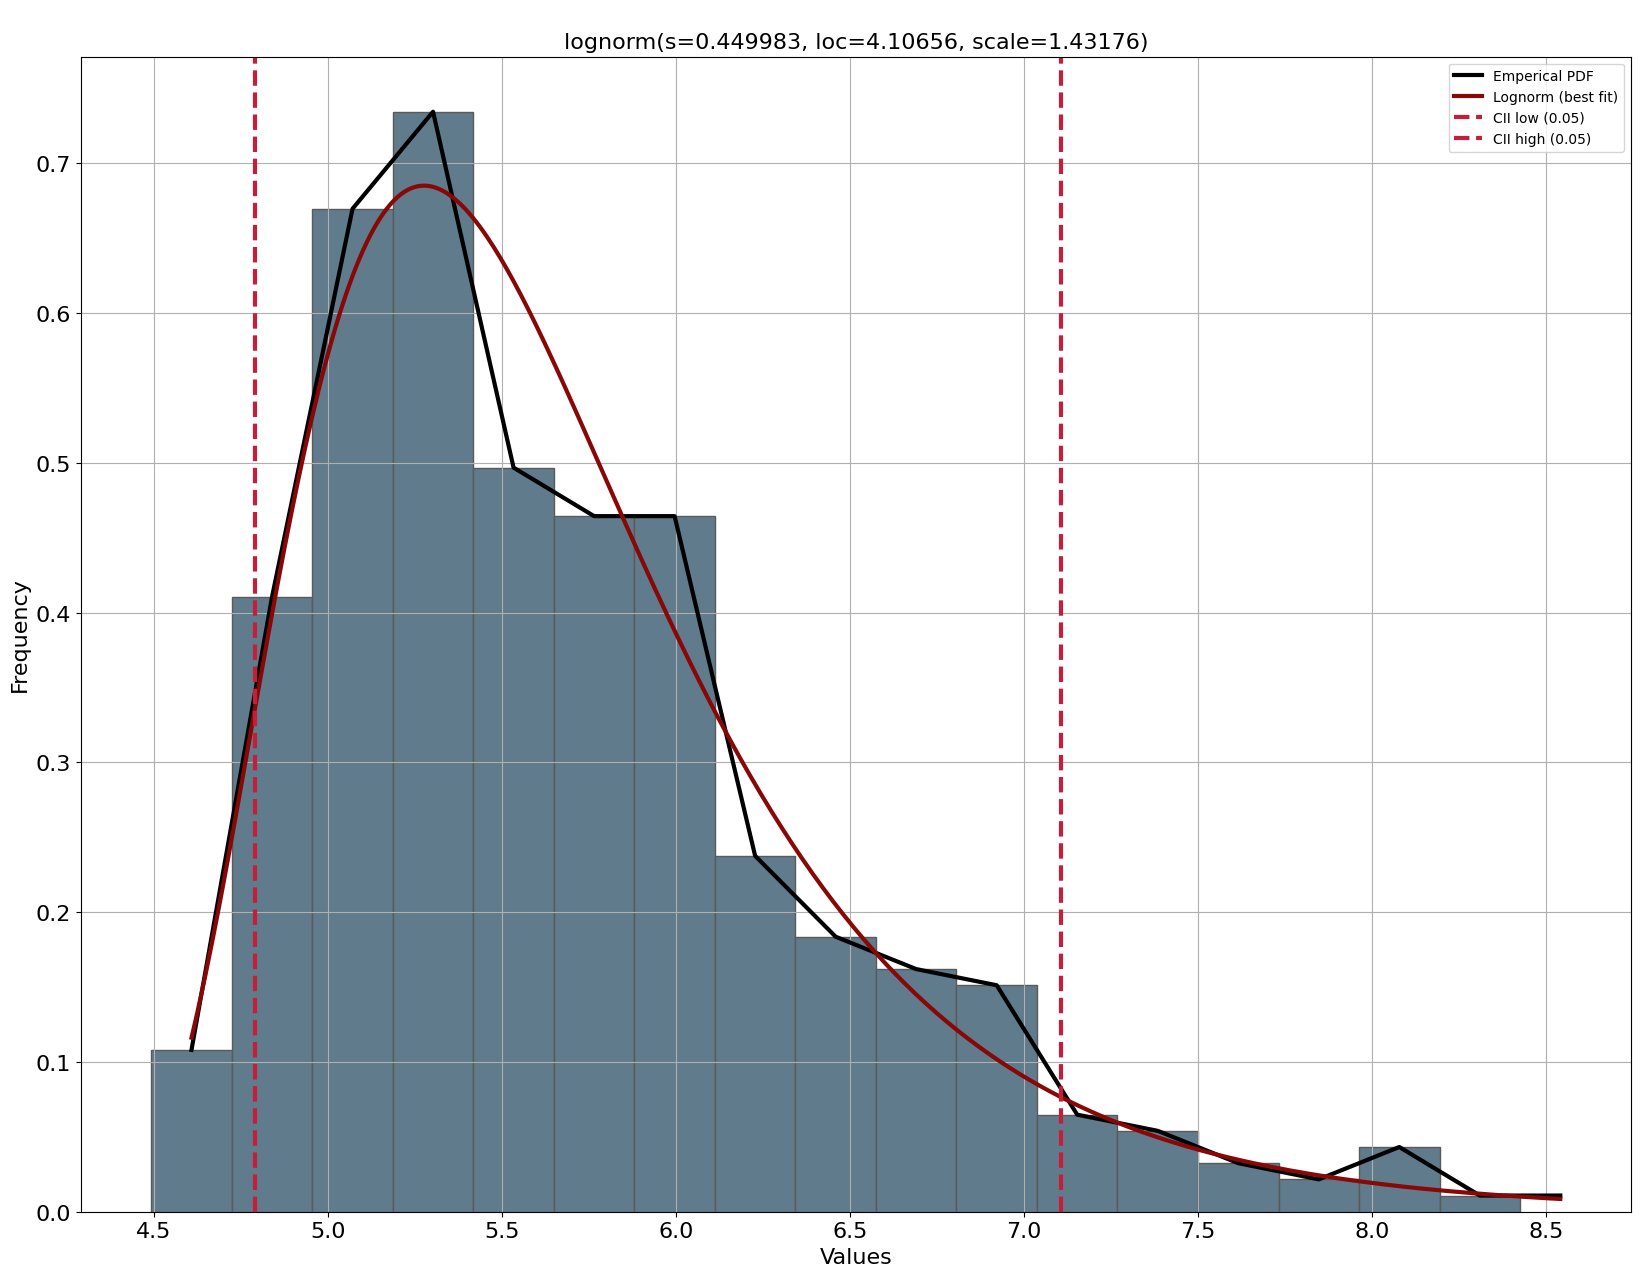

In [17]:
dfit = distfit(todf=True)
results = dfit.fit_transform(set1_good["B1_x_freq_band_0"].to_numpy())
dfit.plot()

[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Lognorm (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

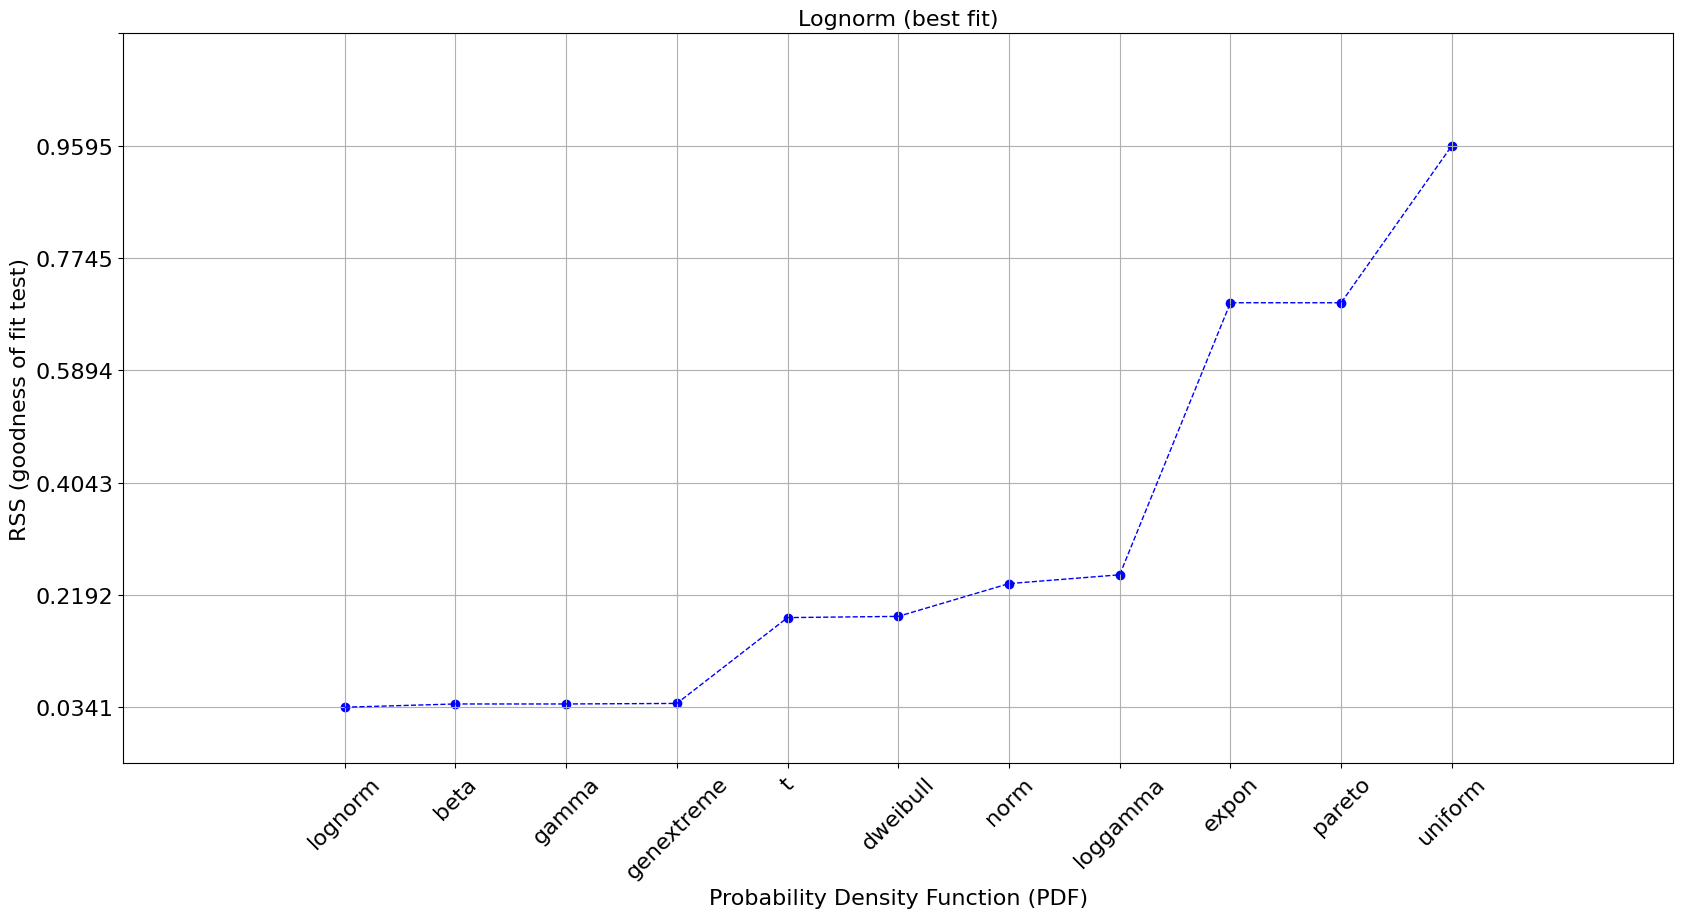

In [18]:
dfit.plot_summary()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.0571924] [loc=5.725 scale=0.535]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 1.62359] [loc=4.365 scale=1.360]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 1.62359] [loc=-67108859.635 scale=67108864.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.0744161] [loc=5.656 scale=0.459]
[distfit] >INFO> [t         ] [0.31 sec] [RSS: 0.055317] [loc=5.720 scale=0.522]
[distfit] >INFO> [genextreme] [0.12 sec] [RSS: 0.039324] [loc=5.507 scale=0.493]
[distfit] >INFO> [gamma     ] [0.23 sec] [RSS: 0.0376551] [loc=3.263 scale=0.117]
[distfit] >INFO> [lognorm   ] [0.10 sec] [RSS: 0.0382382] [loc=2.100 scale=3.585]
[distfit] >INFO> [beta      ] [0.13 sec] [RSS: 0.0370823] [loc=3.584 scale=15.387]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 1.18797] [loc=4.365 scale=3.285]
[distfit] >INFO> [loggamma  ] [0.12 sec] [RSS: 0.0621891] [loc=-153.152 scale=21.542]
[distfit] >INFO> Compute confidence in

(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nbeta(a=13.629, b=84.337, loc=3.58391, scale=15.3872)'}, xlabel='Values', ylabel='Frequency'>)

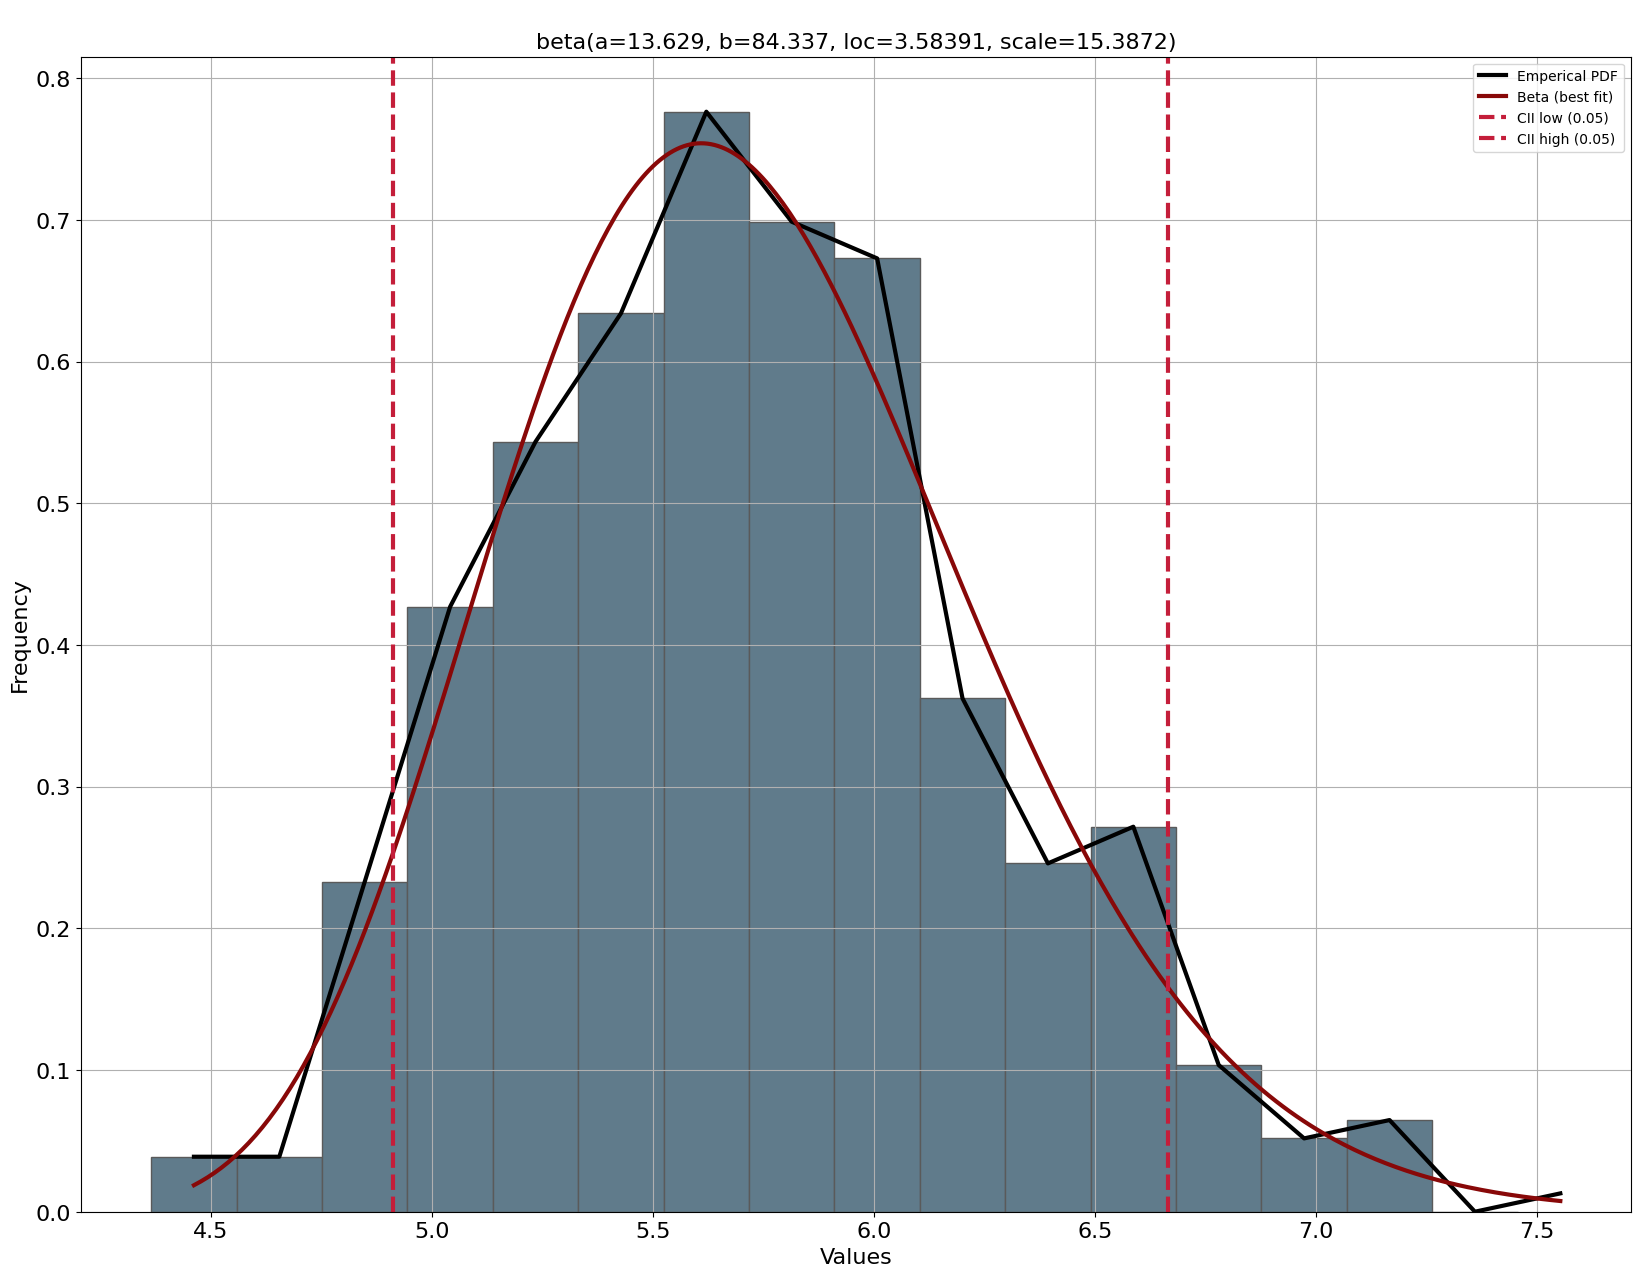

In [19]:
dfit = distfit(todf=True)
results = dfit.fit_transform(set1_bad["B1_x_freq_band_0"].to_numpy())
dfit.plot()

[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Beta (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

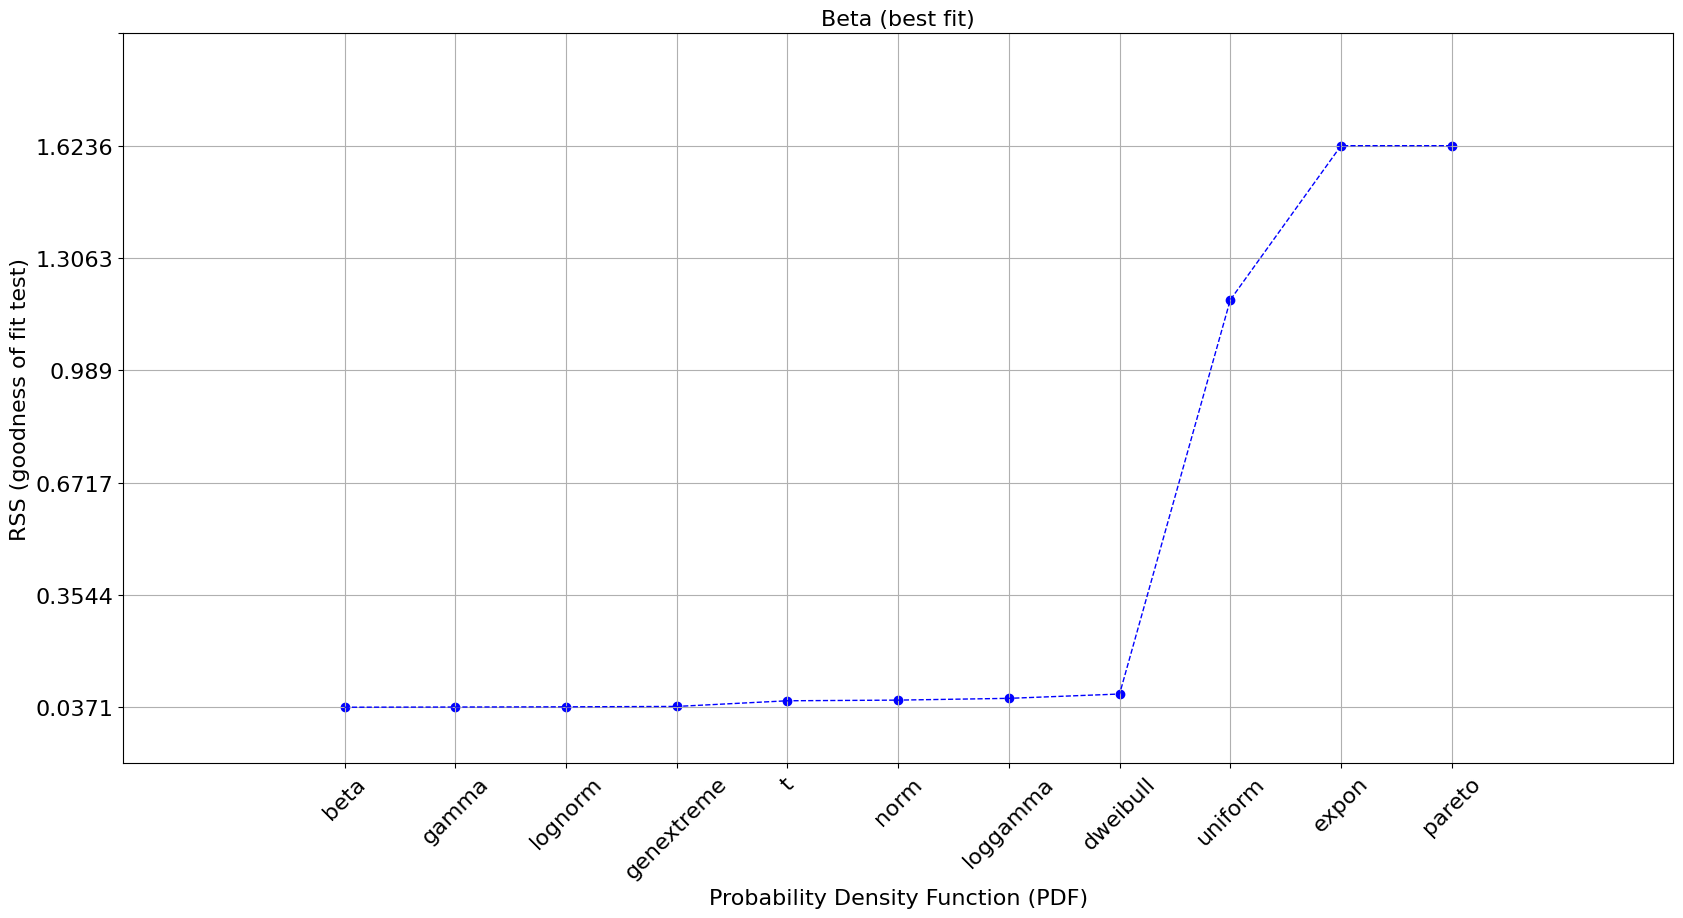

In [20]:
dfit.plot_summary()

Fitting 110 distributions:  97%|█████████▋| 107/110 [01:16<00:17,  5.93s/it]c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:  98%|█████████▊| 108/110 [01:35<00:19,  9.63s/it]c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly 

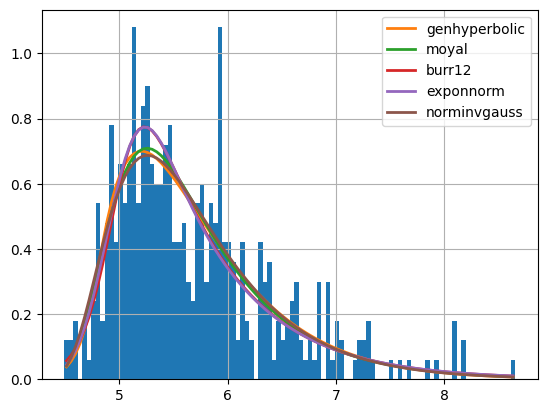

In [50]:
#Good bearing
f_g = fitter.Fitter(set1_good["B1_x_freq_band_0"].to_numpy(), timeout= 300)
f_g.fit()
good_summary= f_g.summary()
good_best= f_g.get_best()

sumsquare_error         aic          bic  kl_div  ks_statistic  \
genhyperbolic         1.732074  445.334695 -2146.900575     inf      0.028132   
moyal                 1.769065  435.985210 -2156.422437     inf      0.034540   
burr12                1.770502  436.450126 -2144.114604     inf      0.046452   
exponnorm             1.771322  433.746894 -2149.920855     inf      0.047963   
norminvgauss          1.779682  442.737183 -2142.046052     inf      0.027918   

               ks_pvalue  
genhyperbolic   0.900549  
moyal           0.713010  
burr12          0.343348  
exponnorm       0.306449  
norminvgauss    0.905395

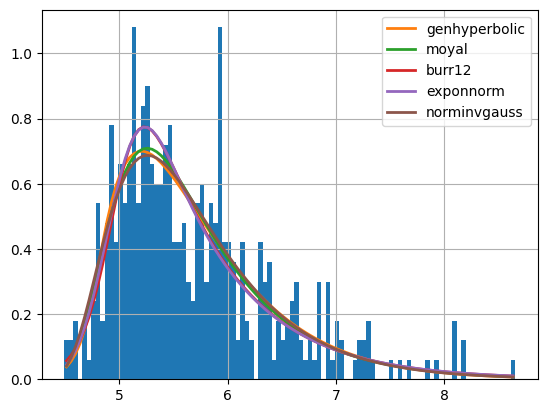

In [51]:
f_g.summary()

Fitting 110 distributions:  97%|█████████▋| 107/110 [01:17<00:12,  4.27s/it]c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:  99%|█████████▉| 109/110 [01:34<00:06,  6.86s/it]c:\Users\User\Desktop\UNI\MasterThesis\maintenance prediction\pred_man\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly 

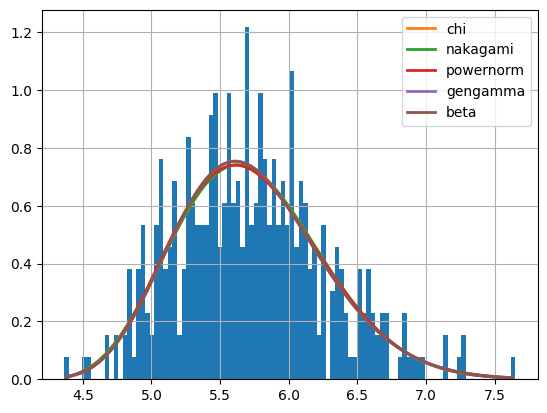

In [52]:
#Bad bearing
f_b = fitter.Fitter(set1_bad["B1_x_freq_band_0"].to_numpy(), timeout= 300)
f_b.fit()
bad_summary= f_b.summary()
bad_best= f_b.get_best()

sumsquare_error         aic          bic  kl_div  ks_statistic  \
chi               2.305948  389.607818 -2044.414704     inf      0.023306   
nakagami          2.305948  389.607252 -2044.414634     inf      0.023306   
powernorm         2.309831  389.996697 -2043.741697     inf      0.023288   
gengamma          2.310833  387.900013 -2037.576677     inf      0.019676   
beta              2.311128  388.158871 -2037.525645     inf      0.020002   

           ks_pvalue  
chi         0.978146  
nakagami    0.978141  
powernorm   0.978313  
gengamma    0.997043  
beta        0.996291

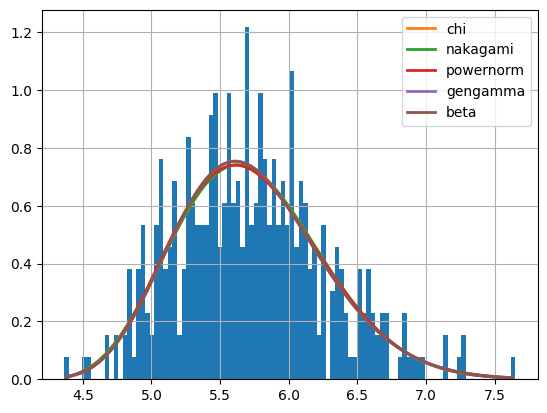

In [53]:
f_b.summary()

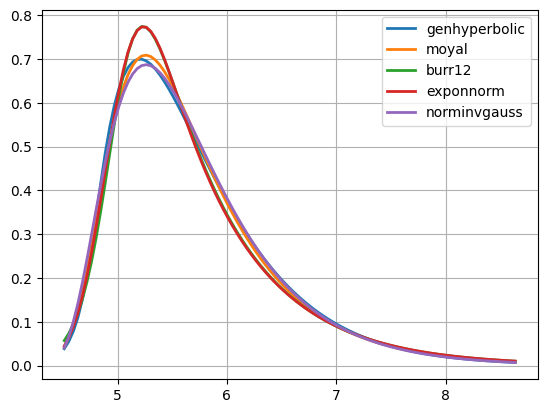

In [61]:
f_g.plot_pdf()

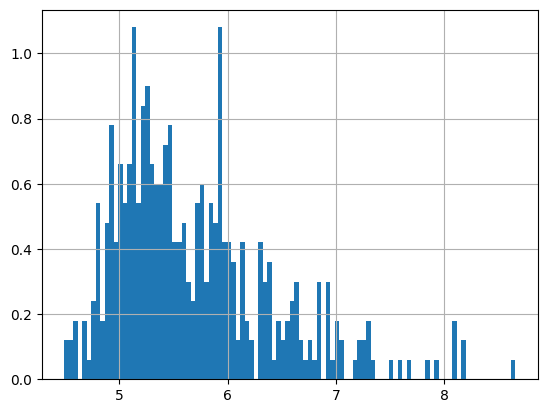

In [62]:
f_g.hist()

In [ ]:
dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']

In [58]:
# stat.ttest_ind(x1, x2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0)
t_stat = stat.ttest_ind(set1_good["B1_x_freq_band_0"].to_numpy(), set1_bad["B1_x_freq_band_0"].to_numpy(), alternative='two-sided', usevar='pooled', weights=(None, None), value=0)
print (t_stat)

(-0.7658101206186397, 0.44401573961585195, 798.0)


In [65]:
# stat.ztest(x1, x2=None, value=0, alternative='two-sided', usevar='pooled', ddof=1.0) 0.0003291
z_stat = stat.ztest(set1_good["B1_x_freq_band_0"], x2=None, value= 5.68985, alternative='two-sided')
print (z_stat)

(-0.0026175948777402334, 0.9979114638456543)


In [ ]:
mean1, std1 = set1_good.mean(), set1_good.std()
mean2, std2 = set1_bad.mean(), set1_bad.std()
test_statistic_good = (np.mean(set1_good) - mean1) / (std1 / np.sqrt(len(set1_good)))
test_statistic_bad = (np.mean(set1_bad) - mean1) / (std1 / np.sqrt(len(set1_bad)))
#Select the distribution in "gamma"
p_value_good = st.gamma.sf(abs(test_statistic_good), len(set1_good)-1)
p_value_bad = st.gamma.sf(abs(test_statistic_bad), len(set1_bad)-1)


# Supervised

In [ ]:
#Health Status labels are added according to following dictionary
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect_1" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminient_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}


Adding labels to the dataframe

In [ ]:
B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for row in set1["time"]:
    cnt += 1
    # B1
    if cnt<=151:
        B1_state.append("early")
    if 151 < cnt <=600:
        B1_state.append("suspect")
    if 600 < cnt <=1499:
        B1_state.append("normal")
    if 1499 < cnt <=2098:
        B1_state.append("suspect")
    if 2098 < cnt <= 2156:
        B1_state.append("imminent_failure")
    #B2
    if cnt<=500:
        B2_state.append("early")
    if 500 < cnt <=2000:
        B2_state.append("normal")
    if 2000 < cnt <=2120:
        B2_state.append("suspect")
    if 2120< cnt <=2156:
        B2_state.append("imminet_failure")

    #B3
    if cnt<=500:
        B3_state.append("early")
    if 500 < cnt <= 1790:
        B3_state.append("normal")
    if 1790 < cnt <=2120:
        B3_state.append("suspect")
    if 2120 < cnt <=2156:
        B3_state.append("Inner_race_failure")
    #B4
    if cnt<=200:
        B4_state.append("early")
    if 200 < cnt <=1000:
        B4_state.append("normal")
    if 1000 < cnt <= 1435:
        B4_state.append("suspect")
    if 1435 < cnt <=1840:
        B4_state.append("Inner_race_failure")
    if 1840 < cnt <=2156:
        B4_state.append("Stage_two_failure")
#controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1.head()

Splitting each bearing data and adding them end to end vertically

In [ ]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]
cols = ['Bx_mean','Bx_std','Bx_skew','Bx_kurtosis','Bx_entropy','Bx_rms','Bx_max','Bx_p2p','Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse',
        'By_mean','By_std','By_skew','By_kurtosis','By_entropy','By_rms','By_max','By_p2p','By_crest', 'By_clearence', 'By_shape', 'By_impulse',
        'class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols
final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data.describe()

Train-Test Split (70%-30%)

In [ ]:
X = final_data.copy()
y = X.pop("class")
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =1)

Evaluating Performance of Base Models

In [ ]:
xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
xgb_cl.fit(X_train, y_train)
preds = xgb_cl.predict(X_test)
accuracy_score(y_test, preds)

**From now on, only X axis data will be used**
                                                                                                                          
So data acquired from y axis will be excluded  

In [ ]:
x_axis_cols = ["Bx_"+tf for tf in time_features_list]
print(x_axis_cols)
X_x = X.copy()
X_x = X[x_axis_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy',
        'B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']
X_x.columns = cols
X_x_train, X_x_test, y_train, y_test = train_test_split(X_x, y, test_size = 0.3, random_state =1)

# Model Selection

Now we can compare several learning algorithms

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","XGBoost","CatGBoost","LightGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    cb.CatBoostClassifier(verbose = False),
    lgbm.LGBMClassifier()
    ]

for name, clf in zip(names,classifiers):
    print("training "+name+" ...")
    clf.fit(X_x_train,y_train)
    score = clf.score(X_x_test,y_test)
    print('Score of'+name+' is: '+str(score))
    #iterate over classifiers
    

# Hyperparameter Tuning
* Since accuracy score of the last 3 base model,namely XGBoost,CatBoost, LightBoost, are the highest ones, we will continue with one of them in further investigations  
* Parameters of the selected model will be tuned with optuna library
* Typical values were given as interval of parameters

In [ ]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        )
    xgb_cl = xgb.XGBClassifier(
            booster='gbtree',
            tree_method ='gpu_hist',
            use_label_encoder=False,
            **xgb_params)
    xgb_cl.fit(X_x_train, y_train)
    preds = xgb_cl.predict(X_x_test)
    accuracy_score(y_test, preds)
    return accuracy_score(y_test,preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

Final XGBoost parameters were obtained by hyperparametertuning using GPU but final model should be trained by CPU to get possibly better result                                             


In [ ]:
final_model = xgb.XGBClassifier(use_label_encoder=False,
                                **xgb_params)
final_model.fit(X_x_train, y_train)
preds = final_model.predict(X_x_test)
accuracy_score(y_test, preds)
#performance is increased

Loading Dataset 2 and 3 to observe the result of the final model on them


In [ ]:
set2 = time_features(dataset_path_2nd, id_set=2)
set2.to_csv('set2_timefeatures.csv')
set3 = time_features(dataset_path_3rd, id_set=3)
set3.to_csv('set3_timefeatures.csv')

In [ ]:
set2 = pd.read_csv("./set2_timefeatures.csv")
set3 = pd.read_csv("./set3_timefeatures.csv")
time_2 = set2['Unnamed: 0']
#Setting index columns to time
set2 = set2.rename(columns={'Unnamed: 0':'time'}).set_index('time')
set3 = set3.rename(columns={'Unnamed: 0':'time'}).set_index('time')

Vertically splitting bearing datum to obtain each bearings' data seperately

In [ ]:
B1_cols = [col for col in set2.columns if "B1" in col]
B2_cols = [col for col in set2.columns if "B2" in col]
B3_cols = [col for col in set2.columns if "B3" in col]
B4_cols = [col for col in set2.columns if "B4" in col]

set2_B1 = set2[B1_cols]
set2_B2 = set2[B2_cols]
set2_B3 = set2[B3_cols]
set2_B4 = set2[B4_cols]

set3_B1 = set3[B1_cols]
set3_B2 = set3[B2_cols]
set3_B3 = set3[B3_cols]
set3_B4 = set3[B4_cols]

set2_B1.columns = cols
set2_B2.columns = cols
set2_B3.columns = cols
set2_B4.columns = cols
set3_B1.columns = cols
set3_B2.columns = cols
set3_B3.columns = cols
set3_B4.columns = cols


# Results
Here, we using plotly library which is more useful than matplotlib in terms of interactivity                   
Extracted features are plotted with their "health state" label

In [ ]:
# HERE number and dataset of bearing can be changed !!!
bearing = set2_B1

#predicting state of bearing with final_model
preds = final_model.predict(bearing)
preds = le.inverse_transform(preds)
#inserting prediction and time to the dataframe
bearing.insert(12,'state',preds)
bearing.insert(13, 'time',bearing.index)

for tf in time_features_list:
    col = "B_{}".format(tf)
    print(col)
    fig=go.Figure((go.Scatter(x=bearing['time'], y=bearing[col],
                             mode='lines',
                             line=dict(color='rgba(0,0,220,0.8)'))))
    fig.add_traces(px.scatter(bearing, x='time', y=col, color='state').data)
    fig.update_layout(template='plotly_dark')
    fig.update_xaxes(showgrid=False)
    fig.show()
    

Downloading CSV File


In [ ]:
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)
create_download_link(filename='./set1_timefeatures.csv')


In [ ]:
create_download_link(filename='./set2_timefeatures.csv')

In [ ]:
create_download_link(filename='./set3_timefeatures.csv')

In [ ]:
import joblib
joblib.dump(final_model, 'model1.pkl')

# Conclusion
It seems that trained model is not realiable on other datasets when it comes to classification of the type of the fault with this type of approach. However, the trained model can distinguish whether the data sourced from healty or faulty bearing when considering "early" and "normal" states as healty. Morever, although it is not mentioned above, feature evaluation and selection process has been conducted on the extracted features with respect to average of the following three metrics, correlation,monotonicity,robustness[3]. It is observed that when the feature which have minimum value of metric defined in the study exculeded from the features dataframe, performance of the model decreased. In further works,contary the this study vibration data can be regarded as time series data and deep learing methods, especially RNNs can be utilized. Also, frequency based feature can be extracted and advanced feature engineering methods can be applied to increase the performance of the model. 

# References
1. https://www.kaggle.com/yasirabd/nasa-bearing-feature-extraction
2. https://www.mathworks.com/help/predmaint/ug/signal-features.html
3. https://www.mdpi.com/2076-3417/10/16/5639/htm#B13-applsci-10-05639


# Additional Resources
1. https://www.youtube.com/watch?v=YtebGVx-Fxw&list=RDCMUCtYLUTtgS3k1Fg4y5tAhLbw&start_radio=1
2. Cavalaglio Camargo Molano, J., Strozzi, M., Rubini, R., & Cocconcelli, M. (2019). Analysis of NASA Bearing Dataset of the University of Cincinnati by Means of Hjorth’s Parameters. In International Conference on Structural Engineering Dynamics ICEDyn 2019.

**NOTE**                                                                                                       
This work is carried out during my Data Science Internship in SensHero Predictive Maintenance Solutions
* In the first week general knowledge about rotary machines and bearings acquired and the literature about the dataset was reviewed.
* In the second week several methods are applied and the code rectified with respect to feedbacks